# DPX Temperature Analysis

In [66]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import hickle, cPickle
import scipy.stats
%matplotlib inline

import plotTemperatureToT as pttt
import ToTtoEnergy as tte
reload(tte)

sys.path.insert(0, '../../../energy_calibration/rebin/')
import rebin as rb

## Input Files

In [67]:
infile = '../../dpx_data/temperatureToT_5.hck'

## Combine files

In [69]:
energyList = [30, 40, 50, 75, 100, 125, 148]
infileList = ['../../dpx_data/temperatureToT_wSensor/temperatureToT_%d.p' % energy for energy in energyList]
# energyList = [25, 45, 75, 100] # [25, 75, 125]
# infileList = ['../../dpx_data/temperatureToT_Dennis1_2_%dkeV.hck' % energy for energy in energyList] # ['../../dpx_data/temperatureToT/DPX22/temperatureToT_DPX22_%dkeV.hck' % energy for energy in energyList]

def combineFiles(infileList, energyList):
    # Get first file
    if infileList[0].endswith('.p'):
        d = cPickle.load(open(infileList[0], 'rb'))
    else:
        d = hickle.load(infileList[0])

    # Add energy column if needed
    if not 'energy' in d.keys():
        energy = energyList[0] * 1000
        d['energy'] = [energy]*len(d['time'])

    dim = min(len(d['energy']), len(d['ToT']), len(d['time']))
    for key in d.keys():
        d[key] = d[key][:dim]
        
    for idx, infile in enumerate(infileList[1:]):
        print infile
        if infileList[idx].endswith('.p'):
            d_ = cPickle.load(open(infile, 'rb'))
        else:
            d_ = hickle.load(infile)
                        
        if not 'energy' in d_.keys():
            energy = energyList[idx+1] * 1000
            d_['energy'] = [energy]*len(d_['time'])
            
        dim = min(len(d_['energy']), len(d_['ToT']), len(d_['time']))
        for key in d_.keys():
            d_[key] = d_[key][:dim]
            
        for key in d.keys():
            d[key] += list(d_[key])
            
    return d

tempDict = combineFiles(infileList, energyList)

../../dpx_data/temperatureToT_wSensor/temperatureToT_40.p
../../dpx_data/temperatureToT_wSensor/temperatureToT_50.p
../../dpx_data/temperatureToT_wSensor/temperatureToT_75.p
../../dpx_data/temperatureToT_wSensor/temperatureToT_100.p
../../dpx_data/temperatureToT_wSensor/temperatureToT_125.p
../../dpx_data/temperatureToT_wSensor/temperatureToT_148.p


In [70]:
print set(tempDict['energy'])
len(tempDict['energy']), len(tempDict['time']), len(tempDict['ToT'])

set([40000, 100000, 125000, 30000, 50000, 148000, 75000])


(697, 697, 697)

## Perform calibration and return parameters for each pixel

In [71]:
reload(pttt)

# Load dict from file
'''
if infile.endswith('.p'):
    d = cPickle.load( open(infile, 'rb') )
else:
    d = hickle.load(infile)
'''

roomTemp = 1635
outDict = pttt.plotTemperature(tempDict, offsettemp=1635, cuttemp=1580, plot=True, outdir='temperatureDennis1')

IndexError: index 16 is out of bounds for axis 0 with size 16

## Simulate temperature effects on measured data

In [6]:
# Get energy calibration coefficients
paramsDict = hickle.load('../../dpx_data/energyConversion/paramsDict_DPX22.hck')

# Load spectrum from file
ToTfnList = ['../../dpx_data/Measurements/DPX22/AmMo_raw/ToTMeasurement_%d.hck' % num for num in range(5, 11)]
dataList = [np.asarray( hickle.load(open(ToTfn, 'r'))['Slot1'] ).T for ToTfn in ToTfnList]
# Combine the data
data = np.hstack(dataList)

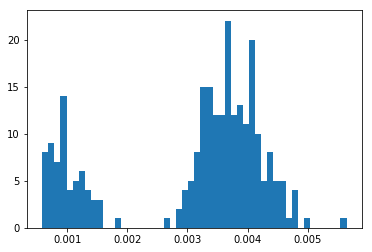

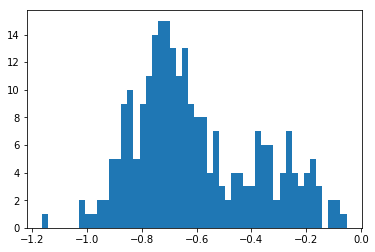

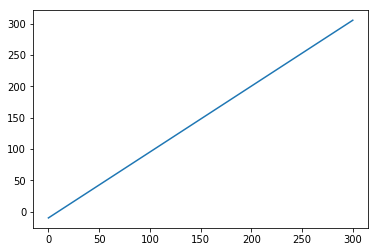

In [7]:
slope, offset, Toffset = outDict['slope'], np.asarray(outDict['offset']), outDict['Toffset']
_ = plt.hist(slope, bins=50)
plt.show()
_ = plt.hist(offset[abs(offset - np.mean(offset)) < 3*np.std(offset)], bins=50)
plt.show()

plt.plot(np.linspace(0, 300, 10), pttt.getRealToT(np.linspace(0, 300, 10), Toffset, 1650, slope[8], offset[8]))

In [56]:
def ToTtoEnergy(data, params):
    pixelData = data
    # pixelData = pixelData[pixelData > 0]
    p = params
    a, b, c, t, h, k = p['a'], p['b'], p['c'], p['t'], p['h'], p['k']

    pixelDataEnergy = tte.ToTtoEnergy(pixelData, a, b, c, t, h, k)
    # pixelDataEnergy = pixelDataEnergy[np.logical_and(pixelDataEnergy > 10, pixelDataEnergy <= 100)]

    return pixelDataEnergy

def ToTatT(data, T, slope, offset, Toffset):
    data = np.asarray( data )
    # data = data[data > 0]
    dataAtT = pttt.getRealToT(data, T, Toffset, slope, offset)
    return dataAtT
    
def getDataAtT(data, T, slope, offset, Toffset, energy=True):
    dataEnergyList = []
    for idx in range(256):
        try:
            dataEnergy = getDataAtTSingle(data[idx], T, slope[idx], offset[idx], Toffset, paramsDict[idx], energy=energy)
            dataEnergyList.append( dataEnergy )
        except:
            continue
    
    return dataEnergyList
    
def getDataAtTSingle(data, T, slope, offset, Toffset, params, energy=True, rmZero=False):
    dataAtT = np.asarray( ToTatT(data, T, slope, offset, Toffset) )
    if rmZero:
        dataAtT = dataAtT[dataAtT > 0]
    # try:
    if energy:
        dataEnergy = ToTtoEnergy(dataAtT, params)
    else:
        dataEnergy = dataAtT
    # except:
    #     return None
    
    return dataEnergy
    
def simDataAtTSingle(data, T, slope, offset, Toffset, params, energy=True, rmZero=False):
    data = np.asarray(data)
    dataAtT = np.asarray( pttt.simWrongToT(data, T, Toffset, slope, offset) )
    if rmZero:
        dataAtT = dataAtT[dataAtT > 0]
    if energy:
        dataEnergy = ToTtoEnergy(dataAtT, params)
    else:
        dataEnergy = dataAtT
    return dataEnergy

Toffset = 1635
TList= np.linspace(Toffset - 100, Toffset + 100, 100)
xMin, xMax = 10, 400
saveFig = False

if saveFig:
    binsList, histList = [], []
    for T in TList:
        dataTemp = getDataAtT(data, T, slope, offset, Toffset, energy=True)
        dataTemp = np.asarray( dataTemp ).flatten()
        hist, bins = np.histogram(dataTemp, bins=np.arange(xMin, xMax))
        binsList.append(bins), histList.append(hist)

    for idx in range(len(TList)):
        plt.step(binsList[idx][:-1], histList[idx], where='post', alpha=.7)
        plt.title('Temperature: %d DAC' % TList[idx])
        plt.ylim(0, 1.05*np.max(histList))
        plt.savefig('images/temperature_%d.jpg' % idx)
        plt.show()
        plt.clf()

## Bin energy data

In [9]:
def normal(x, mu, sigma):
    return 1./np.sqrt(2*sigma**2) * np.exp(-(x - mu)**2 / (2 * sigma**2))

def KDE(bins, hist):
    bins, hist = np.asarray(bins), np.asarray(hist)
    
    # Get bin widths
    binWidths = np.diff(bins)
    
    # Get bin centers
    binCenters = bins[:-1] # + 0.5 * binWidths
    
    f = lambda x: sum([hist[idx] * normal(x, binCenters[idx], .5 * binWidths[idx]) for idx in range(len(hist))])
    return f

def getCorrectedBins(bins, hist):
    # Get gradient
    grad = np.diff(np.insert(hist, 0, 0)) # / np.diff(bins)
    print grad

    binEdges = []
    binWidths = np.diff(bins[:-1])
    for i in range(len(grad) - 1):
        g1, g2 = grad[i], grad[i+1]
        b = bins[i] # + 0.5 * binWidths[i]
        bw = binWidths[i]

        if g1 == 0 and g2 == 0:
            binEdges.append(b + 0.5*bw)
            continue

        gFrac = abs(g1 / g2)
        if np.isinf(gFrac):
            gFrac = 0

        if gFrac > 1:
            gFrac = 1. / gFrac

        if i == 0:
            if gFrac < 0.5:
                gFrac = 1 - gFrac
            
        elif g1 >= 0 and g2 >= 0:
            if gFrac < 0.5:
                gFrac = 1 - gFrac

        elif g1 < 0 and g2 < 0:
            if gFrac >= 0.5:
                gFrac = 1 - gFrac

        elif g1 >= 0 and g2 < 0:
            if abs(g1) < abs(g2):
                gFrac = 1 - gFrac
            gFrac /= 2

        else:
            if abs(g1) < abs(g2):
                gFrac = 1 - gFrac

        binEdges.append(b + bw * gFrac)
        print grad[i], grad[i+1], gFrac, b

    return binEdges

[ 0.00000000e+00  0.00000000e+00  2.59740260e-05  2.45310245e-05
  1.02126528e-03  5.60355434e-03 -2.61938062e-03  3.90163170e-03
  7.46177908e-03  1.37041789e-03 -6.71606265e-03 -7.66916462e-03
 -2.17198732e-03 -2.32558140e-04  0.00000000e+00  0.00000000e+00]
0.0 2.5974025974025972e-05 1.0 18.0
2.5974025974025972e-05 2.4531024531024533e-05 0.9444444444444446 21.0
2.4531024531024533e-05 0.001021265284423179 0.9759797724399494 24.5
0.001021265284423179 0.005603554340396446 0.8177468759317992 33.5
0.005603554340396446 -0.00261938061938062 0.23372492352731442 43.0
-0.00261938061938062 0.0039016317016317015 0.3286448287045729 53.5
0.0039016317016317015 0.007461779081133921 0.5228822321336797 66.5
0.007461779081133921 0.0013704178885630483 0.81634166950507 81.5
0.0013704178885630483 -0.006716062653562652 0.3979746051180682 97.0
-0.006716062653562652 -0.00766916461916462 0.12427715571787878 113.0
-0.00766916461916462 -0.002171987315010571 0.2832104176748209 131.5
-0.002171987315010571 -0.000

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


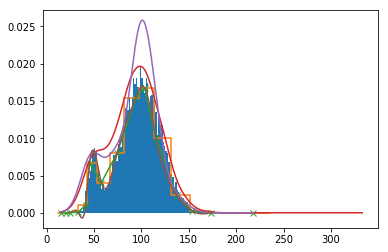

In [10]:
def smearSpectrumKDE(data, amplitude, sigma, bins):
    x = np.linspace(min(data), max(data), bins)
    print data
    y = np.sum(np.asarray([amplitude[i] * scipy.stats.norm.pdf(x - mu, scale=sigma) for i, mu in enumerate(data)]), axis=0)

    return x, y

binEdges = [12, 18, 21, 24.5, 33.5, 43, 53.5, 66.5, 81.5, 97, 113, 131.5, 151.5, 173, 200.5, 236, 430]
rand_data = list(np.random.normal(100, 20, 10000)) + list(np.random.normal(50, 5, 1000))
hist, bins = np.histogram(rand_data, bins=binEdges, density=True)

bins_corr = getCorrectedBins(bins, hist)

plt.hist(rand_data, bins=100, density=True)
plt.step(bins[:-1], hist, where='post')
plt.plot(bins_corr, hist[:-1], marker='x')
plt.plot(*smearSpectrumKDE(bins[:-1] + 0.5 * np.diff(bins), 20*hist, 10, 1000))
plt.plot(*smearSpectrumKDE(bins_corr, 20*hist[:-1], 10, 1000))

f = scipy.interpolate.interp1d(bins_corr, hist[:-1], kind='cubic')
x = np.linspace(25, 175, 1000)
plt.plot(x, f(x))

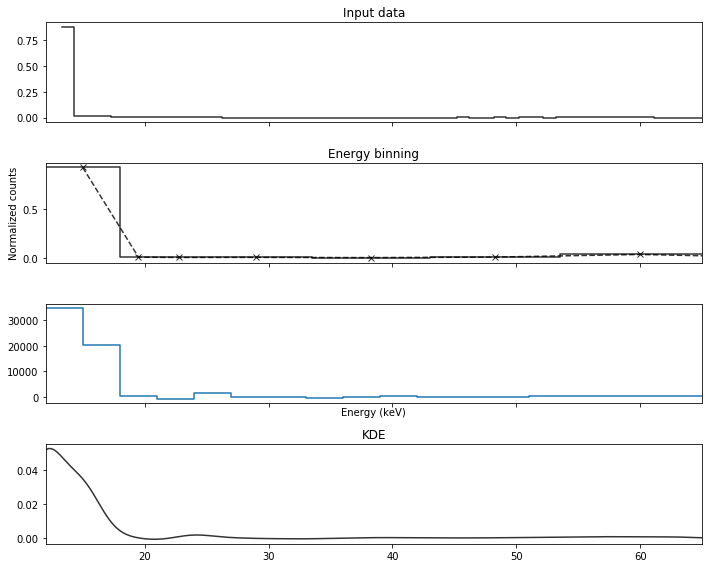

In [11]:
binEdges = [12, 18, 21, 24.5, 33.5, 43, 53.5, 66.5, 81.5, 97, 113, 131.5, 151.5, 173, 200.5, 236, 430]
# binEdges = [12, 40, 42, 44, 50, 55, 56, 66.5, 81.5, 97, 113, 131.5, 151.5, 173, 200.5, 236, 430]

fig, ax = plt.subplots(4, 1, figsize=(10, 8), sharex=True)
idx = 8

# Input data
pixelData = ToTtoEnergy(data[idx], paramsDict[idx])
pixelData = pixelData[np.logical_and(pixelData > 0, pixelData <= 100)]
histIn, binsIn = np.histogram(pixelData, bins=75)
ax[0].step(binsIn[:-1], histIn / float(np.sum(histIn)), where='post', color='k', alpha=.8)
ax[0].set_xlim(binEdges[0], 65)
ax[0].set_title('Input data')

# Apply energy bins
hist, bins = np.histogram(pixelData, bins=binEdges)
ax[1].step(bins[:-1], hist / float(np.sum(hist)), where='post', color='k', alpha=.8)
ax[1].plot(bins[:-1] + 0.5 * np.diff(bins), hist / float(np.sum(hist)), marker='x', ls='--', color='k', alpha=.8)
ax[1].set_title('Energy binning')

# Rebin energy
x = np.arange(binEdges[0], binEdges[-2], min(np.diff(binEdges))) # np.linspace(binEdges[0], binEdges[-2], 16)
x = np.append(x, binEdges[-1])
y = rb.rebin(bins, hist, x) # , interp_kind='piecewise_constant')
ax[2].step(x[:-1], y, where='post')

# Apply KDE
f = KDE(x, y)
x = np.linspace(min(bins), max(bins[:-1]), 1000)
y = f(x)
y /= np.sum(y)
ax[3].plot(x, y, color='k', alpha=.8)
ax[3].set_title('KDE')

ax[2].set_xlabel('Energy (keV)')
ax[1].set_ylabel('Normalized counts')

plt.tight_layout()
plt.show()

In [12]:
def histogramMean(bins, hist):
    return 1./np.sum(hist) * np.dot(bins[:-1], hist)

Toffset = 1635
T = Toffset + 10

# Data at specific temperature T
dataTemp = getDataAtT(data, T, slope, offset, Toffset, energy=False)
# Data at temperature Toffset
dataTempOffset = getDataAtT(data, Toffset, slope, offset, Toffset, energy=False)
plot = False

meanDict = {'corrected': [], 'actual': [], 'target': []}

histActual, histTarget, histCorrected = np.zeros(16), np.zeros(16), np.zeros(16)
for pixel in range(len(dataTemp)):
    # Convert binEdges from energy to ToT
    try:
        p = paramsDict[pixel]
    except:
        continue

    if plot:
        fig, ax = plt.subplots(4, 1, figsize=(10, 8), sharex=True)
    
    binEdgesToT = np.around(tte.EnergyToToT(np.asarray(binEdges), p['a'], p['b'], p['c'], p['t'], p['h'], p['k']))
    if binEdgesToT[0] > binEdgesToT[1]:
        binEdgesToT[0] = 0

    if not all(binEdgesToT):
        continue
        
    # Check if binEdgesToT increas monotonically
    if np.any(np.diff(binEdgesToT) < 0):
        continue
        
    # Bin the data to simualte DosiMode
    hist, bins = np.histogram(dataTemp[pixel], bins=binEdgesToT)
    histActual += np.asarray( hist )
    
    # - Analysis start -
    # Rebin energy
    x = np.arange(binEdgesToT[0], binEdgesToT[-2], min(np.diff(binEdgesToT))) 
    x = np.append(x, binEdgesToT[-1])
    y = rb.rebin(np.asarray(bins, dtype=np.float), np.asarray(hist, dtype=np.float), np.asarray(x, dtype=np.float)) # , interp_kind='piecewise_constant')

    # f = KDE(x, y)
    # x = np.linspace(min(x), max(x[:-1]), 1000)
    # y = f(x)[:-1]
    
    # Convert to energy at Toffset
    xReal = pttt.getRealToT(x, Toffset, T, slope[pixel], offset[pixel])
    
    # Rebin back
    binEdgesToT_ = np.asarray(binEdgesToT)
    # binEdgesToT_ = np.insert(binEdgesToT_, 0, 0)
    yBack = rb.rebin(xReal, y, binEdgesToT_) # , interp_kind='piecewise_constant')
    # yBack = yBack_[1:]
    # yBack[0] += yBack_[0]
    histCorrected += np.asarray(yBack)
    # - Analysis end -
    
    histOffset, binsOffset = np.histogram(dataTempOffset[pixel], bins=binEdgesToT)
    histTarget += np.asarray(histOffset)
    
    meanDict['actual'].append( histogramMean(bins, hist) ) 
    meanDict['target'].append( histogramMean(binsOffset, histOffset) )
    meanDict['corrected'].append( histogramMean(binEdgesToT, yBack) )
            
    if plot:
        ax[0].step(bins[:-1], hist, where='post', alpha=.5)
        ax[0].step(binsOffset[:-1], histOffset, where='post', alpha=.5)
        ax[1].step(x[:-1], y, where='post', alpha=.5)
        ax[2].step(xReal[:-1], y, where='post', alpha=.5)
        ax[3].step(binEdgesToT[:-1], yBack, where='post', alpha=.5)
        ax[3].step(binsOffset[:-1], histOffset, where='post', alpha=.5)
        plt.show()
        # ax[3].set_ylim(0, 3000)

ToTtoEnergy.py:112: RuntimeWarning: invalid value encountered in less
  res = np.where(x < b, a*((x - k)/h - b) - c * (np.pi / 2 + t / ((x - k)/h - b)), 0)
../../../energy_calibration/rebin/rebin.py:200: RuntimeWarning: invalid value encountered in double_scalars
  / areas1[sub2old[i]] )


ZeroDivisionError: float division by zero

In [ ]:
idx = 118
pixelData = data[idx]
# pixelData = np.random.normal(200, 20, 5000) # + list(np.random.normal(26, 1, 3000)) + list(np.random.normal(40, 10, 1000))
pixelData = pixelData[np.logical_and(pixelData > 0, pixelData <= 1000)]
TAdd = 10

def correctDosi(pixelData, TAdd, idx):
    pixelDataAtT = pttt.getRealToT(pixelData, Toffset, Toffset + TAdd, slope[idx], offset[idx])

    p = paramsDict[idx]
    binEdgesToT = np.around(tte.EnergyToToT(np.asarray(binEdges), p['a'], p['b'], p['c'], p['t'], p['h'], p['k']))
    # print binEdgesToT

    fig, ax = plt.subplots()
    # ax.set_yscale("log", nonposy='clip')
    # Measured spectrum
    _ = ax.hist(pixelData, bins=50, alpha=.3, density=True, color='C0')
    hist, bins = np.histogram(pixelData, bins=binEdgesToT, density=True)
    ax.step(bins[:-1], hist, where='post', color='C0')

    # Spectrum at specified temperature
    _ = ax.hist(pixelDataAtT, bins=50, alpha=.3, density=True, color='C2')
    histAtT, binsAtT = np.histogram(pixelDataAtT, bins=binEdgesToT, density=True)
    binsAtT_, histAtT_ = binsAtT, histAtT
    ax.step(binsAtT[:-1], histAtT, where='post', color='C2')

    binEdgesCorr = getCorrectedBins(bins, hist)
    ax.plot(np.append(binEdgesCorr, 0)[:-1], hist[:-1], marker='x', markersize=10, ls='--', color='C0')

    binsAtT = pttt.getRealToT(binEdgesCorr, Toffset, Toffset + TAdd, slope[idx], offset[idx])
    ax.plot(np.append(binsAtT, 0)[:-1], hist[:-1], marker='x', markersize=10, ls='--', color='C2')

    bw_ = binsAtT - np.diff(np.append(binsAtT, 0))
    # ax.step(bw_[1:], hist[:-2], where='post', color='C3')

    diffCorr = (binEdgesToT[1:-1] - binEdgesCorr)
    diffT = (binEdgesToT[1:-1] - binsAtT)
    '''
    print hist
    print
    print diffCorr[hist[:-1] > 0]
    print diffT[hist[:-1] > 0]
    print
    print (diffCorr / diffT)[hist[:-1] > 0]
    print (diffT / diffCorr)[hist[:-1] > 0]
    print
    print (binEdgesCorr - binsAtT)[hist[:-1] > 0]
    print 
    print (histAtT/hist)[hist > 0]
    print (hist/histAtT)[hist > 0]
    '''

    hNew = np.asarray(list(hist))
    hAdd = 0

    for idx, h in enumerate(hist[:-1]):
        # h += hAdd
        # if h == 0:
        #    continue

        bw = float(binEdgesToT[idx+1] - binEdgesToT[idx])
        bwn = float(binEdgesToT[idx+2] - binEdgesToT[idx+1])
        
        # if TAdd > 40:
        fac = ((diffCorr[idx] - diffT[idx]) / bw)
        fac = (0.25 - diffT[idx] / bw) / (0.25 - diffCorr[idx] / bw)
        # fac = 0.5 + (diffT[idx] / bw)
        # fac = abs(1 - diffCorr[idx]/diffT[idx])
        if fac > 1:
            fac = 1./fac
        # print fac, h, (1 - 1./ diffT[idx]), (abs(binsAtT/binEdgesCorr)[idx])
        # print binEdgesToT[idx+1], binEdgesToT[idx], diffT[idx], diffCorr[idx], 1./fac, fac
        if fac < 0:
            if diffT[idx] > 0:
                continue
            else:
                fac = 0
        # fac = 1. / abs(fac)

        # fac = (1 - 1./ diffT[idx]) # * (abs(binsAtT/binEdgesCorr)[idx])
        # if fac > 1:
        #    fac = 1. / fac

        # fac = 0.
        # hNew.append( h * fac )

        print fac, 1 - fac, h * (1 - fac) / bwn * bw, diffT[idx], bwn

        idx_ = 0
        if diffT[idx] < 0 and abs(diffT[idx]) >= bwn:
            idx_ = 1

        try:
            if fac == 0:
                print 'One'
                hNew[idx + idx_ + 1] = h / bw * bwn
            else:
                print 'Two', idx_
                hNew[idx + idx_ + 1] += hNew[idx] * (1 - fac) / bwn * bw
                hNew[idx] *= fac
        except:
            pass

        # hAdd = h * (1 - fac)
        
    # ax.step(bins[:-2], hNew, where='post', color='C1')
    ax.step(bins[:-1], hNew, where='post', color='C1')

    ax.set_xlim(0, 400)
    ax.set_xlabel('ToT')
    ax.set_ylabel('Normalized counts')
    plt.show()

    return histogramMean(bins, hist), histogramMean(binsAtT_, histAtT_), histogramMean(bins, hNew), histogramMean(bw_[1:], hist[:-3])

fracList = []
Trange = np.arange(10, 110, 10)
for T in Trange:
    a, b, c, d = correctDosi(pixelData, T, idx)
    fracList.append((b/c, b/a))
    
fracList = np.asarray(fracList)
plt.plot(Trange, fracList[:,1], color='C2', label='w/o correction')
plt.plot(Trange, fracList[:,0], color='C0', label='w correction')
plt.legend(loc='best')
plt.xlabel(r'Temperature shift $\Delta T$ (DAC)')
plt.ylabel(r'Mean energy at $T$ / Mean energy at $T + \Delta T$')
plt.show()
print fracList

In [ ]:
meanActual, meanCorrected, meanTarget = np.asarray(meanDict['actual']), np.asarray(meanDict['corrected']), np.asarray(meanDict['target'])
plt.hist(meanActual, bins=15, alpha=.5, label='Actual')
plt.hist(meanTarget, bins=15, alpha=.5, label='Target')
plt.hist(meanCorrected, bins=15, alpha=.5, label='Corrected')
plt.legend()
plt.show()

plt.hist(abs(meanActual - meanTarget), bins=15, alpha=.5)
plt.hist(abs(meanCorrected - meanTarget), bins=15, alpha=.5)
plt.show()

fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
ax[0].plot(np.append(getCorrectedBins(binEdges, histActual), 0), histActual, marker='x', ls='', color='C0')
ax[0].step(binEdges[:-1], histActual, where='post', label='Actual', color='C0')
ax[0].step(binEdges[:-1], histTarget, where='post', label='Target', color='C1')
ax[0].plot(np.append(getCorrectedBins(binEdges, histCorrected), 0), histCorrected, marker='x', ls='', color='C2')
ax[0].step(binEdges[:-1], histCorrected, where='post', label='Corrected', color='C2')
ax[1].axhline(y=1, ls='--', color='k')
ax[1].semilogy(binEdges[:-1] + 0.5*np.diff(binEdges), histTarget / histActual, markersize=20, ls='', marker='+')
ax[1].semilogy(binEdges[:-1] + 0.5*np.diff(binEdges), histTarget / histCorrected, markersize=20, ls='', marker='+')
ax[0].legend()
plt.xlim(12, 100)

In [ ]:
import scipy.interpolate

# randomData = pixelData 
randomData = list(np.random.normal(60, 1, 5000)) + list(np.random.normal(26, 1, 3000)) + list(np.random.normal(40, 10, 1000))
binEdges = [12, 18, 21, 24.5, 33.5, 43, 53.5, 66.5, 81.5, 97, 113, 131.5, 151.5, 173, 200.5, 236, 430]

hist, bins = np.histogram(randomData, bins=binEdges, density=True)
hist /= max(hist)
print hist

# Use corrected bin centers
binEdges_ = getCorrectedBins(bins, hist)

# Show input data
histIn, binsIn = np.histogram(randomData, bins=100, density=True)
histIn /= max(histIn)
plt.step(binsIn[:-1], histIn, where='post')

# Plot corrected bin positions
hist_ = hist[:-1] # * np.diff(np.append(binEdges_, 0))
plt.plot(binEdges_, hist_/max(hist_), marker='x', ls='--', color='k')

# Find peaks
sign = np.sign(np.insert(np.diff(hist_), 0, 1))
sign = sign[sign != 0]
peakIdx = (np.argwhere(np.diff(sign) < 0) + 2).flatten()
print 'Peaks:', peakIdx

peaks = np.asarray(binEdges_)[peakIdx]
sigmas = [2] * len(peaks)
As = np.asarray(hist_/max(hist_))[peakIdx]
offsetList = [0.] * len(peaks)

def multiGaussPlot(x, *p):
    y = np.zeros(len(x))
    yfine = np.zeros(1000)
    xfine = np.linspace(x[0], x[-1], 1000)    
    
    # Polynomial background
    if wBG:
        poly = p[-5:]
        bg = np.poly1d(poly)
        y = bg(x)
        yfine = bg(xfine)
    
    y[y < 0] = 0
    yfine[yfine < 0] = 0
    
    params = p[:-5]
    # Peaks
    for idx in range(0, len(params), 3):
        A, mu, sigma = params[idx], params[idx+1], params[idx+2]
        y += (A * np.exp(-(x - mu)**2/(2*sigma**2)))
        yfine += (A * np.exp(-(xfine - mu)**2/(2*sigma**2)))

    return y

wBG, wAREA = False, False
def multiGauss(x, *p):
    y = np.zeros(len(x))
    yfine = np.zeros(1000)
    xfine = np.linspace(x[0], x[-1], 1000)    
    
    # Polynomial background
    if wBG:
        poly = p[-5:]
        bg = np.poly1d(poly)
        y = bg(x)
        yfine = bg(xfine)
    
    y[y < 0] = 0
    yfine[yfine < 0] = 0
    
    params = p[:-5]
    # Peaks
    for idx in range(0, len(params), 3):
        A, mu, sigma = params[idx], params[idx+1], params[idx+2]
        y += (A * np.exp(-(x - mu)**2/(2*sigma**2)))
        yfine += (A * np.exp(-(xfine - mu)**2/(2*sigma**2)))

    if wAREA:
        areaList = []
        for idx in range(len(binEdges) - 1):
            b1, b2 = binEdges[idx], binEdges[idx+1]
            y_ = yfine[np.logical_and(xfine >= b1, xfine < b2)]
            if not any(y_):
                areaList.append( 0 )
                continue
            x_ = xfine[np.logical_and(xfine >= b1, xfine < b2)]

            areaList.append( scipy.integrate.simps(y_, x_) )
            # print areaList
                
        areaList = np.asarray(areaList)
        areaList /= float(np.max(areaList))
        
        '''
        plt.clf()
        plt.step(bins[:-1], hist, where='post')
        plt.step(bins[:-1], areaList, where='post')
        plt.step(xfine, yfine, where='post')
        plt.xlim(12, 70)
        plt.show()
        '''
        
        error = np.asarray(hist) / areaList
        errMean, errStd = np.nanmean( error ), np.nanstd( error )
        error = np.nansum(np.abs( np.asarray(hist) / areaList - 1 ))
        # print error
        # print errStd
        return errStd
    
    else:
        errStd, error = 0, 0
        return np.sqrt(np.square(y - hist[:-1]))
    
def polyArea(x, poly):
    return np.asarray([1./(k + 1) * x**(k + 1) for k in range(len(poly))])

def multiGaussArea(x1, x2, *p):
    # poly = p[-3:]
    # pA = np.sum(polyArea(x2, poly) - polyArea(x1, poly))
    x = np.linspace(x1, x2, 100)
    return scipy.integrate.simps(multiGauss(x, *p), x) # scipy.integrate.quad(multiGauss, x1, x2)[0]

p0 = np.hstack((np.vstack((As, peaks, sigmas)).T.flatten(), [0.001]*5)).flatten()
bounds = [[0, 0, 0] * len(peaks) + [-np.inf]*5, [1, np.inf, np.inf]*len(peaks) + [np.inf]*5]
# bounds[1][2], bounds[1][5] = 3., 3.
print bounds
print p0
popt, pcov = scipy.optimize.curve_fit(multiGauss, binEdges_, np.zeros(len(binEdges_)), p0=p0, bounds=bounds)
wBG = True
popt, pcov = scipy.optimize.curve_fit(multiGauss, binEdges_, np.zeros(len(binEdges_)), p0=popt, bounds=bounds)
wAREA = True
bounds = [[0.8*p if p >= 0 else 1.2*p for p in popt], [1.2*p if p >= 0 else 0.8*p for p in popt]]
bounds[0][2] = 0.
# bounds[1][2] = 5.

print bounds
popt, pcov = scipy.optimize.curve_fit(multiGauss, binEdges_, np.zeros(len(binEdges_)), p0=popt, bounds=bounds)
print np.reshape(popt[:-5], (3, -1))

# p = np.polyfit(x_, hist__/max(hist__), 13)
# f = np.poly1d(p)
# f = scipy.interpolate.interp1d(binEdges_, hist_/max(hist_), kind='cubic')
# f = KDE(np.append(binEdges_, 0), hist_)

x = np.linspace(min(binEdges_), max(binEdges_), 1000)
wArea = False
yFit = multiGaussPlot(x, *popt)
plt.plot(x, yFit / np.max(yFit))

# plt.plot(x, f(x))
plt.step(bins[:-1], hist, where='post')
plt.xlim(0, 100)
# plt.ylim(0, 1.05)

In [16]:
areaList = []
for idx in range(len(binEdges) - 1):
    b1, b2 = binEdges[idx], binEdges[idx+1]
    areaList.append( scipy.integrate.simps(np.linspace(b1, b2, 100), *p) )
    print areaList

areaList = np.asarray(areaList)
error = np.sqrt( np.sum(np.square( np.asarray(hist) / areaList - 1 )) )


TypeError: simps() argument after * must be an iterable, not numpy.float64

# Dose Temperature Stability
Includes:

In [51]:
sys.path.insert(0, '../../../getConversionFactors/')
sys.path.insert(0, '../../../csv/')

import plot_csv_support as pcs
import getConversionFactors as gcf
import getConversionFactors_poly as gcfp

reload(pttt)
reload(pcs)
reload(gcf)
reload(gcfp)

<module 'getConversionFactors_poly' from '../../../getConversionFactors/getConversionFactors_poly.pyc'>

[12, 18, 21, 24.5, 33.5, 43, 53.5, 66.5, 81.5, 97, 113, 131.5, 151.5, 173, 200.5, 236, 430]
[  6.    3.    3.5   9.    9.5  10.5  13.   15.   15.5  16.   18.5  20.
  21.5  27.5  35.5 194. ]
14.933333333333334
[ 15.    19.5   22.75  29.    38.25  48.25  60.    74.    89.25 105.
 122.25 141.5  162.25 186.75 218.25 333.  ]
[32, 37, 47, 57.5, 68.5, 80, 91.5, 104, 117, 131, 145, 163.5, 183.5, 207.5, 234.5, 269.5, 430]
[  5.   10.   10.5  11.   11.5  11.5  12.5  13.   14.   14.   18.5  20.
  24.   27.   35.  160.5]
15.833333333333334
[ 34.5   42.    52.25  63.    74.25  85.75  97.75 110.5  124.   138.
 154.25 173.5  195.5  221.   252.   349.75]
[12, 17, 31, 40, 45.5, 50.5, 60.5, 68, 91, 102.5, 133, 148, 163, 196, 220, 257, 430]
[  5.   14.    9.    5.5   5.   10.    7.5  23.   11.5  30.5  15.   15.
  33.   24.   37.  173. ]
16.333333333333332
[ 14.5   24.    35.5   42.75  48.    55.5   64.25  79.5   96.75 117.75
 140.5  155.5  179.5  208.   238.5  343.5 ]


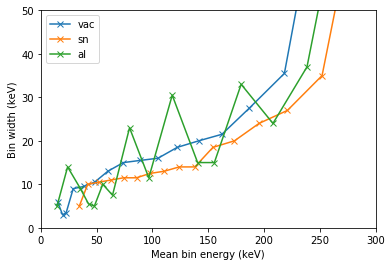

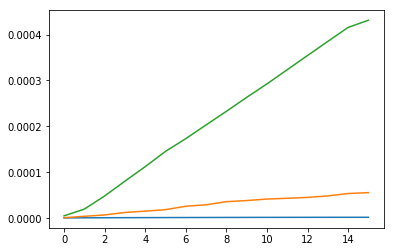

In [54]:
binEdgesTh = {'vac': [12, 18, 21, 24.5, 33.5, 43, 53.5, 66.5, 81.5, 97, 113, 131.5, 151.5, 173, 200.5, 236, 430],
        'sn': [32, 37, 47, 57.5, 68.5, 80, 91.5, 104, 117, 131, 145, 163.5, 183.5, 207.5, 234.5, 269.5, 430],
        'al': [12, 17, 31, 40, 45.5, 50.5, 60.5, 68, 91, 102.5, 133, 148, 163, 196, 220, 257, 430]}

# binEdgesTh = {'vac': np.linspace(12, 400, 17), 'al': np.linspace(12, 400, 17), 'sn': np.linspace(12, 400, 17)}
# list(np.linspace(12, 100, 8)) + list(np.linspace(105, 300, 9))
# [12, 60, 100, 135, 165, 180, 200, 215, 225, 230, 235, 240, 245, 250, 255, 260, 430]

for key in binEdgesTh.keys():
    print binEdgesTh[key]
    print np.diff(binEdgesTh[key])
    print np.mean( np.diff(binEdgesTh[key])[:-1] )
    bc = binEdgesTh[key][:-1] + 0.5*np.diff(binEdgesTh[key])
    print bc
    plt.plot(bc, np.diff(binEdgesTh[key]), marker='x', label=key)
    plt.xlabel('Mean bin energy (keV)')
    plt.ylabel('Bin width (keV)')
plt.xlim(0, 300)
plt.ylim(0, 50)
plt.legend()
plt.savefig('binWidths.svg')
plt.show()
    
polyParams = [-6.13432151e-09,  2.08479453e-06,  6.76750181e-10, -4.04786053e-07, 6.04542804e-05, 5.54387308e-09, -3.50905545e-06,  5.37851109e-04] 
degs = [2, 3, 3]
alphaPoly = gcfp.alphaPolyDev(polyParams, degs, binEdgesTh)
plt.plot(np.reshape(alphaPoly, (3, 16)).T)
slope, offset, Toffset = outDict['slope'], np.asarray(outDict['offset']), outDict['Toffset']
idx = 13

In [200]:
Toffset = 1600

In [15]:
import scipy.integrate

def alphaPolyShow(p, deg, x):
    resList = []
    p1, p2, p3 = deg
    idxList = [range(p1), range(p1, p1+p2), range(p1+p2, p1+p2+p3)]

    title = ['vac', 'al', 'sn']
    for i in range(3):
        f = np.poly1d(np.asarray(p)[idxList[i]])
        resList.append( f(x) )

    return resList 

def alphaInt(x, y, edges):
    x = np.asarray(x)
    y = np.asarray(y)
    
    res = []
    for i in range(len(edges) - 1):
        # try:
        y_ = y[np.logical_and(x > edges[i], x <= edges[i+1])]
        x_ = x[np.logical_and(x > edges[i], x <= edges[i+1])]
        res.append( scipy.integrate.trapz(y_, x=x_) )
        # except:
        #    res.append( 0 )
        
    return res

def histMean(bins, hist):
    hist = np.nan_to_num(hist)
    bw = np.asarray(bins[:-1]) + 0.5 * np.diff(bins)
    mean = np.dot(bw, hist) / np.nansum(hist)
    return mean, np.sqrt(np.dot(hist/float(np.sum(hist)), np.square(np.asarray(bw) - mean)))

## Apply Temperature Shift

In [58]:
reload(gcfp)

def temperatureShiftSim(ToTvac, ToTal, ToTsn, dose, debug=False):
    dose_temp = []
    dose_old = []
    w_list = []
    mean_energy_list = []
    int_list = []
    mean_temp_list, sigma_temp_list = [], []
    
    TAddRange = np.arange(-100, 120, 20)
    for TAdd in TAddRange:
        data_vac_temp = simDataAtTSingle(ToTvac, Toffset, slope[idx], offset[idx], Toffset + TAdd, paramsDict[idx], energy=True, rmZero=True)
        data_al_temp = simDataAtTSingle(ToTal, Toffset, slope[idx], offset[idx], Toffset + TAdd, paramsDict[idx], energy=True, rmZero=True)
        data_sn_temp = simDataAtTSingle(ToTsn, Toffset, slope[idx], offset[idx], Toffset + TAdd, paramsDict[idx], energy=True, rmZero=True)

        x = np.linspace(10, 450, 5000)
        alphaShow = alphaPolyShow(polyParams, degs, x)
        
        if debug:
            fig, ax = plt.subplots()
            ax2 = ax.twinx()
            for i in range(3):
                # ax2.plot(x, np.sin(x* + i))
                ax2.semilogy(x, alphaShow[i])

        hist_vac_temp, bins = np.histogram(data_vac_temp, bins=binEdgesTh['vac'])
        hist_al_temp, bins = np.histogram(data_al_temp, bins=binEdgesTh['al'])
        hist_sn_temp, bins = np.histogram(data_sn_temp, bins=binEdgesTh['sn'])

        hist_temp = np.hstack((hist_vac_temp, hist_al_temp, hist_sn_temp))
        p = paramsDict[idx]

        # Scale x-axis with temperature
        new_x = getDataAtTSingle(tte.EnergyToToT(x, p['a'], p['b'], p['c'], p['t'], p['h'], p['k']), Toffset, slope[idx], offset[idx], Toffset + TAdd, paramsDict[idx], energy=True)

        binEdgesNew = {}
        titles = ['vac', 'al', 'sn']
        for t in titles:
            binEdgesToT = np.around(tte.EnergyToToT(np.asarray(binEdgesTh[t]), p['a'], p['b'], p['c'], p['t'], p['h'], p['k']))
            binEdges = getDataAtTSingle(binEdgesToT, Toffset, slope[idx], offset[idx], Toffset + TAdd, paramsDict[idx], energy=True)
            binEdgesNew[t] = binEdges

        alphaPoly_ = gcfp.alphaPolyDev(polyParams, degs, binEdgesNew)
        '''
        alphaPolY = []
        for i in range(3):
            alphaPolY += list(np.reshape(alphaPoly_, (3, -1))[i] * np.diff(binEdgesTh[titles[i]]) / np.diff(binEdgesNew[titles[i]]))
        alphaPoly_ = alphaPolY
        '''

        alphaPoly__ = []
        for i in range(3):
            be = np.diff(binEdgesTh[titles[i]])
            h = np.reshape(hist_temp, (3, -1))[i]
            
            if False: # np.count_nonzero(h):
                e = binEdgesTh[titles[i]][np.argmax(h)]

                # binEdgesToT = np.around(tte.EnergyToToT(binEdgesTh[titles[i]], p['a'], p['b'], p['c'], p['t'], p['h'], p['k']))
                # binEdgesTemp = getDataAtTSingle(binEdgesToT, Toffset + TAdd, slope[idx], offset[idx], Toffset, paramsDict[idx], energy=True)
                # hMean_ToT, hSigma_ToT = histMean(binEdgesToT, h)
                
                hMean, hSigma = histMean(binEdgesTh[titles[i]], h)
                # hMean *= get_mean(hMean, TAdd)
                hMean_ToT = np.around(tte.EnergyToToT([hMean], p['a'], p['b'], p['c'], p['t'], p['h'], p['k']))[0]
                hMean_temp = getDataAtTSingle([hMean_ToT], Toffset, slope[idx], offset[idx], Toffset + TAdd, paramsDict[idx], energy=True)[0]

                hSigma_ToT = np.around(tte.EnergyToToT([hMean + get_sigma(hMean, hSigma)], p['a'], p['b'], p['c'], p['t'], p['h'], p['k']))[0]
                hSigma_temp = getDataAtTSingle([hSigma_ToT], Toffset, slope[idx], offset[idx], Toffset + TAdd, paramsDict[idx], energy=True)[0] - hMean_temp
                
                # hMean_temp, hSigma_temp = histMean(binEdgesTemp, h)
                
                h = rb.rebin(np.asarray(binEdgesNew[titles[i]]), np.asarray(h, dtype=float), np.asarray(binEdgesTh[titles[i]]), interp_kind='piecewise_constant')
                h[0] = 0
                hMean_t, hSigma_t = histMean(binEdgesTh[titles[i]], h)
                if i == 1:
                    print 'Sigma:', hMean, hSigma, get_sigma(hMean, hSigma), hMean_temp, hSigma_temp
                    mean_temp_list.append( hMean_temp ), sigma_temp_list.append( hSigma_temp )
                    w_list.append( (hMean_t, hMean_temp, hSigma_t, hSigma_temp) )
                    
                bc = binEdgesTh[titles[i]][:-1] + .5 * np.diff(binEdgesTh[titles[i]])
                h_idx = np.argwhere(np.abs(bc - hMean_temp) <= hSigma_temp).flatten()
                h_filt = np.asarray(h[h_idx])
                be_filt = np.asarray(be[h_idx])
                bc_filt = bc[h_idx]
                mean_dist = (1. / np.abs(bc - hMean_temp))[h_idx]
                # print bc, hMean_t, hSigma_t
                # print np.abs(bc - hMean_temp) <= hSigma_temp
                w = np.dot(mean_dist / np.sum(mean_dist), be_filt) # be[np.argmin(np.abs(binEdgesTh[titles[i]] - hMean_t))] # be[np.argmax(h)]
                # w = np.sum(h_filt / np.sum(h_filt) * be_filt)
                if i == 1:
                    mean_energy_list.append(hMean)
                w = 1.
                # w = np.sum(h / float(np.sum(h)) * be)
                # if i == 1:
                #    w_list.append( w )
                # print w
            else:
                w = 0

            hist = np.reshape(hist_temp, (3, -1))[i]
            if debug:
                ax.step(binEdgesTh[titles[i]][:-1], hist, where='post')
                
            bins_corr = getCorrectedBins(binEdgesTh[titles[i]], hist)
            bins_corr = getDataAtTSingle(tte.EnergyToToT(bins_corr, p['a'], p['b'], p['c'], p['t'], p['h'], p['k']), Toffset + TAdd, slope[idx], offset[idx], Toffset, paramsDict[idx], energy=True)
            bc = binEdgesTh[titles[i]][:-1] + .5 * np.diff(binEdgesTh[titles[i]])
            be = np.diff(binEdgesTh[titles[i]])
            if debug:
                ax.plot(bc, hist, marker='+', ls='')
                ax.plot(bins_corr, hist[:-1], marker='x')

            # non_zero = np.zeros(len(hist)-1)
            # non_zero[np.nonzero(hist)] = 1
            # idx_new = np.asarray([be[:-1][np.argmin(np.abs(bins_corr - b))] for b in bc[:-1]]) * non_zero
            # w = list(idx_new) + [idx_new[0]] 

            f = scipy.interpolate.interp1d(bc, be, kind='cubic')
            #try:
            #    w_mean = np.mean(f(np.linspace(hMean_t - 10, hMean_t + 10, 100)))
            #except:
            #    w_mean = f(hMean_t)
            
            '''
            if hMean_temp == 0:
                w_mean = 0.
            try:
                w_mean = f(hMean_temp)
                w = yEdge_interp2(hMean_temp) * (0.8*w_mean + 0.05*hMean_temp)
                # w = 0.3*w_mean + 0.13*hMean_temp
                # w = 0.05*w_mean + 0.05*hMean_temp
                print 'Weight:', 0.8*w_mean + 0.05*hMean_temp, w_mean, hMean_temp
                w = 1. / be
            except:
                w = 1. / be
            '''
            
            try:
                w = get_corr(hMean_temp, hSigma_temp) / be # get_correction(hMean_temp, hSigma_temp) / be # yEdge_interp2(hMean_temp) * yEdge_interp(hMean_temp) / be # f_interp(hMean_t) / be
                print 'Weight:', hMean_temp, hSigma, w
            except:
                w = 1. / np.asarray(binEdgesNew[titles[i]][:-1])
            w = 1. # / be
                
            # * alphaInt(new_x, alphaShow[i], [binEdgesTh[titles[i]][0], binEdgesTh[titles[i]][-1]])
            alphaPoly__ += list( np.asarray(alphaInt(new_x, alphaShow[i], binEdgesTh[titles[i]])) * w) # (w / be))

            if i == 1:
                int_list.append( alphaInt(new_x, alphaShow[i], [binEdgesTh[titles[i]][0], binEdgesTh[titles[i]][-1]]) )

        #for i in range(3):
        #    alphaPolY += list(np.reshape(alphaPoly_, (3, -1))[i] * np.diff(binEdgesTh[titles[i]]) / np.diff(binEdgesNew[titles[i]]))

        alphaPoly__ = np.nan_to_num(alphaPoly__)
        # print np.reshape(alphaPoly__, (3, -1))
        if debug:
            ax.set_title('TAdd = %.2f' % TAdd)
            plt.xlim(10, 200)
            plt.show()

        # plt.plot(x, new_x)

        dose_t = np.dot(hist_temp, alphaPoly__)
        dose_temp.append( dose_t )
        dose_old.append(np.dot(hist_temp, alphaPoly))

    dose_temp_resp = np.asarray(dose_temp) / dose
    if debug:
        plt.plot(TAddRange, dose_temp_resp, color='C0', label='w/ correction')
        plt.plot(TAddRange, np.asarray(dose_old) / dose, color='C2', label='w/o correction')
        plt.xlabel(r'Temperature $T$ (DAC)')
        plt.ylabel(r'(Dose at $T$) / (Dose at calibration temp.)')
        plt.legend()
        plt.show()

        plt.plot(TAddRange, mean_temp_list)
        plt.show()

        plt.plot(binEdgesTh['vac'][:-1], np.diff(binEdgesTh['vac']))
        plt.plot(binEdgesTh['al'][:-1], np.diff(binEdgesTh['al']))
        plt.plot(binEdgesTh['sn'][:-1], np.diff(binEdgesTh['sn']))
        plt.show()
        plt.plot(mean_energy_list, w_list, marker='x')
        plt.title('w_list')
        plt.show()
        plt.plot(mean_energy_list, 1. / np.asarray(dose_temp_resp))
        plt.show()
        plt.plot(TAddRange, 1. / np.asarray(int_list), marker='x')
        
    return dose_temp_resp, np.asarray(dose_old) / dose, mean_temp_list, sigma_temp_list

[ 0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0]
0 1 1 66.5
1 -1 0 81.5
-1 0 0 97


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in long_scalars


[    0     0     0     1    -1    55   172 10331   710 -3387 -7871   -10
     0     0     0     0]
0 1 1 31
1 -1 0 40
-1 55 0 45.5
55 172 1 50.5
172 10331 1 60.5
10331 710 0.928571428571 68
710 -3387 0 91
-3387 -7871 0 102.5
-7871 -10 0.0012706480305 133
-10 0 0 148
[ 0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0]
0 1 1 80
1 -1 0 91.5
-1 0 0 104


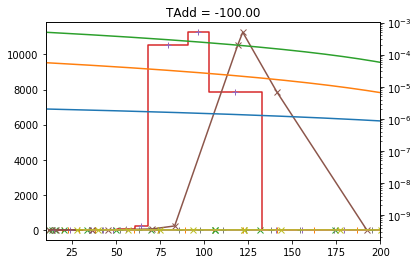

[ 0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0]
0 1 1 66.5
1 -1 0 81.5
-1 0 0 97
[    0     0     0     1    -1    65   237 12951 -2197 -5734 -5321    -1
     0     0     0     0]
0 1 1 31
1 -1 0 40
-1 65 0 45.5
65 237 1 50.5
237 12951 1 60.5
12951 -2197 0.0833333333333 68
-2197 -5734 0 91
-5734 -5321 0 102.5
-5321 -1 0.00018793459876 133
-1 0 0 148
[ 0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0]
0 1 1 80
1 -1 0 91.5
-1 0 0 104


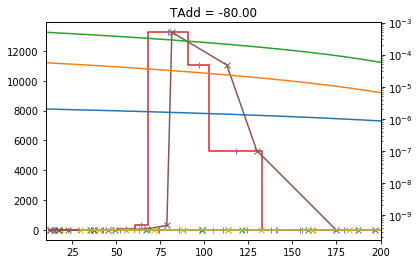

[ 0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0]
0 1 1 66.5
1 -1 0 81.5
-1 0 0 97
[    0     0     0     1     0    78   363 15944 -6406 -6869 -3111     0
     0     0     0     0]
0 1 1 31
1 0 1 40
0 78 1 45.5
78 363 1 50.5
363 15944 1 60.5
15944 -6406 0.166666666667 68
-6406 -6869 0 91
-6869 -3111 0.5 102.5
-3111 0 0 133
[ 0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0]
0 1 1 68.5
1 -1 0 80
-1 0 0 91.5


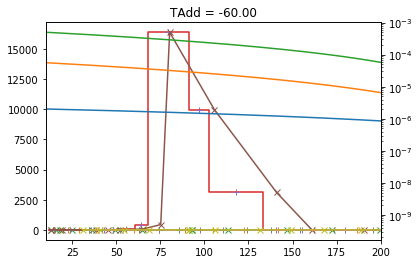

[ 0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0]
0 1 1 66.5
1 -1 0 81.5
-1 0 0 97
[     0      0      0      1      0     99    571  19023 -11668  -6519
  -1507      0      0      0      0      0]
0 1 1 31
1 0 1 40
0 99 1 45.5
99 571 1 50.5
571 19023 1 60.5
19023 -11668 0.25 68
-11668 -6519 0 91
-6519 -1507 0.25 102.5
-1507 0 0 133
[ 0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0]
0 1 1 68.5
1 -1 0 80
-1 0 0 91.5


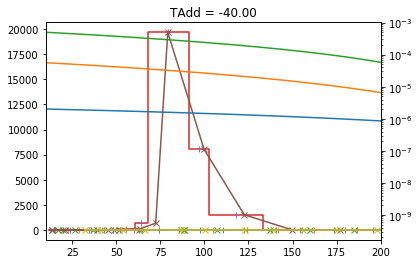

[ 0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0]
0 1 1 66.5
1 -1 0 81.5
-1 0 0 97
[     0      0      0      1      1    130    894  21597 -16964  -5102
   -557      0      0      0      0      0]
0 1 1 31
1 1 1 40
1 130 1 45.5
130 894 1 50.5
894 21597 1 60.5
21597 -16964 0.25 68
-16964 -5102 0.333333333333 91
-5102 -557 0.111111111111 102.5
-557 0 0 133
[ 0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0]
0 1 1 68.5
1 -1 0 80
-1 0 0 91.5


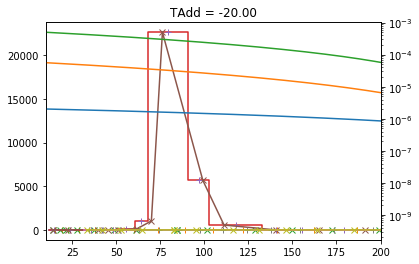

[ 0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0]
0 1 1 53.5
1 -1 0 66.5
-1 0 0 81.5
[     0      0      0      1      2    194   1414  23265 -21701  -3038
   -137      0      0      0      0      0]
0 1 1 31
1 2 1 40
2 194 1 45.5
194 1414 1 50.5
1414 23265 1 60.5
23265 -21701 0.25 68
-21701 -3038 0.142857142857 91
-3038 -137 0.0454545454545 102.5
-137 0 0 133
[ 0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0]
0 1 1 68.5
1 -1 0 80
-1 0 0 91.5


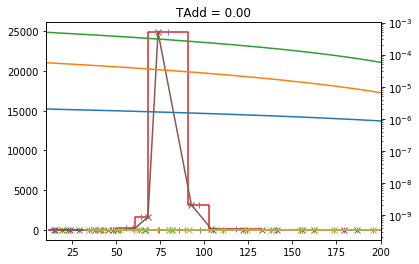

[ 0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0]
0 1 1 53.5
1 -1 0 66.5
-1 0 0 81.5
[     0      0      0      1      3    296   2290  23172 -24431  -1319
    -12      0      0      0      0      0]
0 1 1 31
1 3 1 40
3 296 1 45.5
296 2290 1 50.5
2290 23172 1 60.5
23172 -24431 0 68
-24431 -1319 0.0555555555556 91
-1319 -12 0.00917431192661 102.5
-12 0 0 133
[ 0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0]
0 1 1 57.5
1 -1 0 68.5
-1 0 0 80


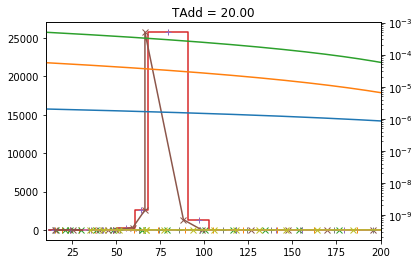

[ 0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0]
0 1 1 53.5
1 -1 0 66.5
-1 0 0 81.5
[     0      0      0      1      3    480   3703  20787 -24624   -350
      0      0      0      0      0      0]
0 1 1 31
1 3 1 40
3 480 1 45.5
480 3703 1 50.5
3703 20787 1 60.5
20787 -24624 0 68
-24624 -350 0.0142857142857 91
-350 0 0 102.5
[ 0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0]
0 1 1 57.5
1 -1 0 68.5
-1 0 0 80


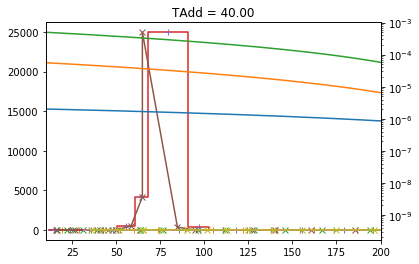

[ 0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0]
0 1 1 53.5
1 -1 0 66.5
-1 0 0 81.5
[     0      0      0      1      3    859   5829  15710 -22364    -38
      0      0      0      0      0      0]
0 1 1 31
1 3 1 40
3 859 1 45.5
859 5829 1 50.5
5829 15710 1 60.5
15710 -22364 0 68
-22364 -38 0.00170068027211 91
-38 0 0 102.5
[ 0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0]
0 1 1 57.5
1 -1 0 68.5
-1 0 0 80


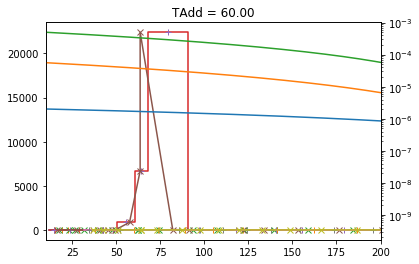

[ 0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0]
0 1 1 53.5
1 -1 0 66.5
-1 0 0 81.5
[     0      0      0      1      5   1639   8823   7412 -17880      0
      0      0      0      0      0      0]
0 1 1 31
1 5 1 40
5 1639 1 45.5
1639 8823 1 50.5
8823 7412 1 60.5
7412 -17880 0 68
-17880 0 0 91
[ 0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0]
0 1 1 57.5
1 -1 0 68.5
-1 0 0 80


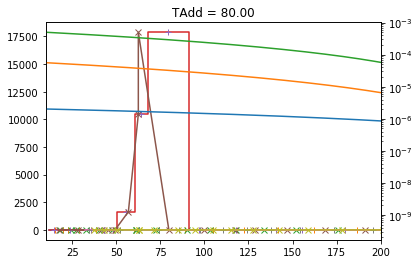

[ 0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0]
0 1 1 53.5
1 -1 0 66.5
-1 0 0 81.5
[     0      0      0      1     16   3278  11995  -3893 -11397      0
      0      0      0      0      0      0]
0 1 1 31
1 16 1 40
16 3278 1 45.5
3278 11995 1 50.5
11995 -3893 0.125 60.5
-3893 -11397 0 68
-11397 0 0 91
[ 0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 47
1 -1 0 57.5
-1 0 0 68.5


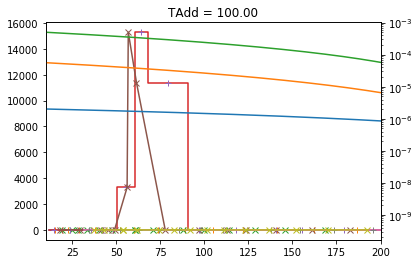

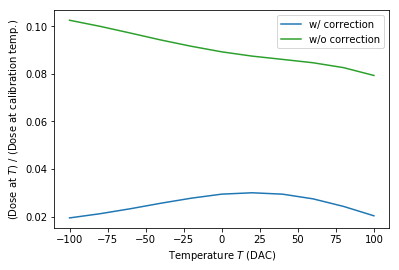

ValueError: x and y must have same first dimension, but have shapes (11,) and (0,)

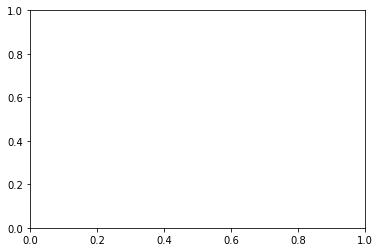

In [57]:
energy = 300
ToTvac = list(np.random.normal(energy, 1, 1)) # + list(np.random.normal(300, 2, 1))
# ToTal = np.random.uniform(150, 250, 1) 
ToTal = list(np.random.normal(energy, 20, 30000)) #+ list(np.random.uniform(12, 800, 10000))
ToTsn = np.random.normal(energy, 1, 1)
dose_temp_test, dose_old_test, mean_test, sigma_test = temperatureShiftSim(ToTvac, ToTal, ToTsn, 10, debug=True)

In [59]:
idx=140
dat = getDataAtTSingle(ToTal, 0, slope[idx], offset[idx], 0, paramsDict[idx], energy=True)
print np.mean(dat), np.std(dat)
print mean_test
print sigma_test
print dose_temp_test
print dose_old_test
print [float(get_correction(mean_test[i], sigma_test[i])) for i in range(len(mean_test))]
plt.plot(mean_test, dose_old_test)
plt.plot(mean_test, dose_temp_test)

74.40036814652079 8.284918436598618


NameError: name 'mean_test' is not defined

## Generate random data

0.033688761610723775


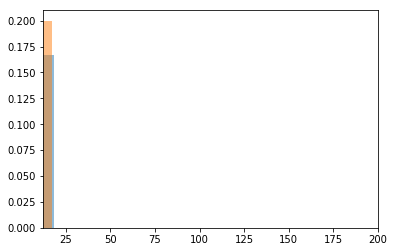

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 331 -331    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
331 -331 1 12
-331 0 0 17
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in long_scalars


[ 1007 -1007     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]
1007 -1007 1 12
-1007 0 0 17
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 2648 -2648     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]
2648 -2648 1 12
-2648 0 0 17
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 6297 -6297     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]
6297 -6297 1 12
-6297 0 0 17
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 12816 -12816      0      0      0      0      0      0      0      0
      0      0      0      0      0      0]
12816 -12816 1 12
-12816 0 0 17
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 20794 -20794      0      0      0      0      0      0      0      0
      0      0      0      0      0      0]
20794 -20794 1 12
-20794 0 0 17
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0

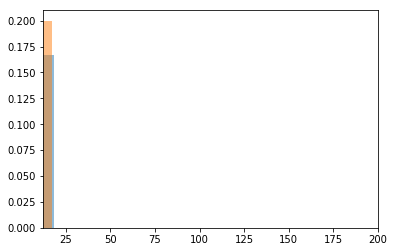

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 554 -554    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
554 -554 1 12
-554 0 0 17
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1486 -1486     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]
1486 -1486 1 12
-1486 0 0 17
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 3696 -3696     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]
3696 -3696 1 12
-3696 0 0 17
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 8054 -8054     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]
8054 -8054 1 12
-8054 0 0 17
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 15101 -15101      0      0      0      0      0      0      0      0
      0      0      0      0      0      0]
15101 -15101 1 12
-15101 0 0 17
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  

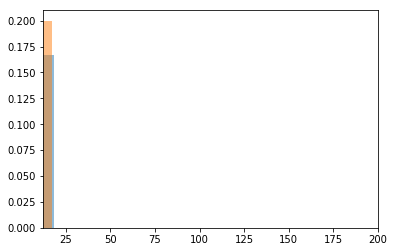

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 833 -833    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
833 -833 1 12
-833 0 0 17
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 2222 -2222     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]
2222 -2222 1 12
-2222 0 0 17
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 5018 -5018     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]
5018 -5018 1 12
-5018 0 0 17
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 10222 -10222      0      0      0      0      0      0      0      0
      0      0      0      0      0      0]
10222 -10222 1 12
-10222 0 0 17
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 17365 -17365      0      0      0      0      0      0      0      0
   

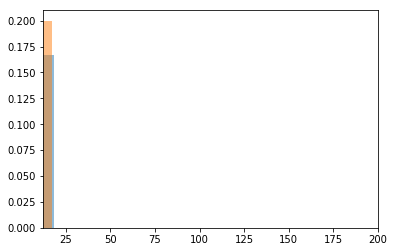

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1382 -1382     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]
1382 -1382 1 12
-1382 0 0 17
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 3160 -3160     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]
3160 -3160 1 12
-3160 0 0 17
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 6710 -6710     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]
6710 -6710 1 12
-6710 0 0 17
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 12389 -12389      0      0      0      0      0      0      0      0
      0      0      0      0      0      0]
12389 -12389 1 12
-12389 0 0 17
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 19686 -19686      0      0      0      0      0      0      0      0
      0      0      0      0      0      0]
19686 -19686 1 12
-19686 0 0 17
[0 0 0 0 0 0 0 0

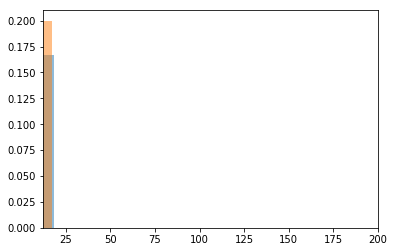

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 2038 -2038     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]
2038 -2038 1 12
-2038 0 0 17
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 4424 -4424     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]
4424 -4424 1 12
-4424 0 0 17
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 8621 -8621     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]
8621 -8621 1 12
-8621 0 0 17
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 14799 -14799      0      0      0      0      0      0      0      0
      0      0      0      0      0      0]
14799 -14799 1 12
-14799 0 0 17
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 21633 -21633      0      0      0      0      0      0      0      0
      0      0      

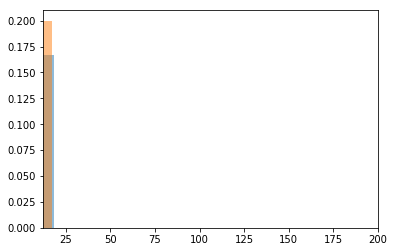

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 2744 -2744     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]
2744 -2744 1 12
-2744 0 0 17
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 5759 -5759     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]
5759 -5759 1 12
-5759 0 0 17
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 10632 -10632      0      0      0      0      0      0      0      0
      0      0      0      0      0      0]
10632 -10632 1 12
-10632 0 0 17
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 16999 -16999      0      0      0      0      0      0      0      0
      0      0      0      0      0      0]
16999 -16999 1 12
-16999 0 0 17
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 23506 -23506      0      0      0      0      0      0      0      0
      0      0      0      0      0  

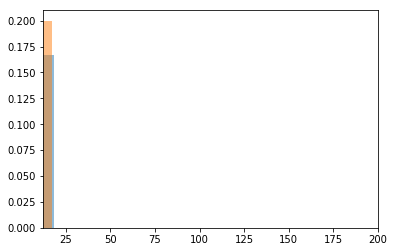

[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 4046 -4046     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]
4046 -4046 1 12
-4046 0 0 17
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 7599 -7599     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]
7599 -7599 1 12
-7599 0 0 17
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 12783 -12783      0      0      0      0      0      0      0      0
      0      0      0      0      0      0]
12783 -12783 1 12
-12783 0 0 17
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 19236 -19236      0      0      0      0      0      0      0      0
      0      0      0      0      0      0]
19236 -19236 1 12
-19236 0 0 17
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0 

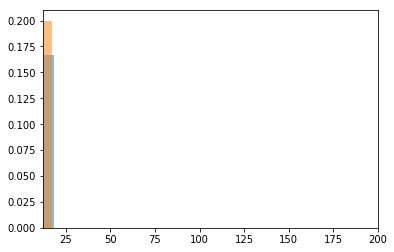

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 5524 -5524     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]
5524 -5524 1 12
-5524 0 0 17
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 9758 -9758     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]
9758 -9758 1 12
-9758 0 0 17
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 15423 -15423      0      0      0      0      0      0      0      0
      0      0      0      0      0      0]
15423 -15423 1 12
-15423 0 0 17
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 21522 -21521     -1      0      0      0      0      0      0      0
      0      0      0      0      0      0]
21522 -21521 0.5 12
-21521 -1 4.6466242275e-05 17
-1 0 0 31
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 26401 -26392     -9      0      0      0  

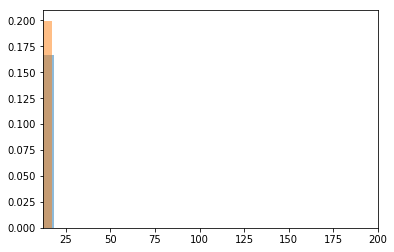

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 7108 -7108     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]
7108 -7108 1 12
-7108 0 0 17
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 11714 -11714      0      0      0      0      0      0      0      0
      0      0      0      0      0      0]
11714 -11714 1 12
-11714 0 0 17
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 17573 -17573      0      0      0      0      0      0      0      0
      0      0      0      0      0      0]
17573 -17573 1 12
-17573 0 0 17
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 23296 -23294     -2      0      0      0      0      0      0      0
      0      0      0      0      0      0]
23296 -23294 0.5 12
-23294 -2 8.585901949e-05 17
-2 0 0 31
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 27420 -27414     -6     

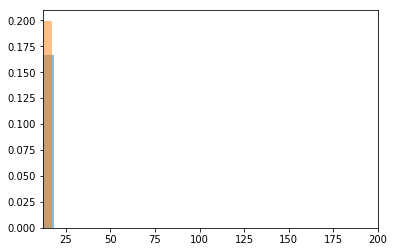

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 9097 -9097     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]
9097 -9097 1 12
-9097 0 0 17
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 14074 -14074      0      0      0      0      0      0      0      0
      0      0      0      0      0      0]
14074 -14074 1 12
-14074 0 0 17
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 19743 -19742     -1      0      0      0      0      0      0      0
      0      0      0      0      0      0]
19743 -19742 0.5 12
-19742 -1 5.06534292372e-05 17
-1 0 0 31
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 24924 -24923     -1      0      0      0      0      0      0      0
      0      0      0      0      0      0]
24924 -24923 0.5 12
-24923 -1 4.01235806283e-05 17
-1 0 0 31
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  

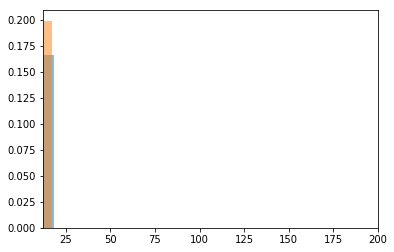

[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 11191 -11191      0      0      0      0      0      0      0      0
      0      0      0      0      0      0]
11191 -11191 1 12
-11191 0 0 17
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 16396 -16396      0      0      0      0      0      0      0      0
      0      0      0      0      0      0]
16396 -16396 1 12
-16396 0 0 17
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 21989 -21986     -3      0      0      0      0      0      0      0
      0      0      0      0      0      0]
21989 -21986 0.5 12
-21986 -3 0.000136462882096 17
-3 0 0 31
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 26333 -26322    -11      0      0      0      0      0      0      0
      0      0      0      0      0      0]
26333 -26322 0.5 12
-26322 -11 0.

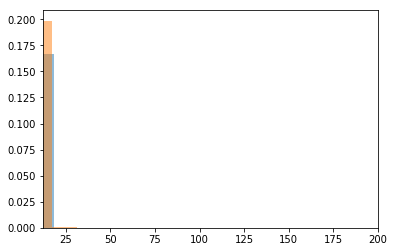

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 13504 -13503     -1      0      0      0      0      0      0      0
      0      0      0      0      0      0]
13504 -13503 0.5 12
-13503 -1 7.40576168259e-05 17
-1 0 0 31
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 18749 -18748     -1      0      0      0      0      0      0      0
      0      0      0      0      0      0]
18749 -18748 0.5 12
-18748 -1 5.33390228291e-05 17
-1 0 0 31
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 23659 -23651     -8      0      0      0      0      0      0      0
      0      0      0      0      0      0]
23659 -23651 0.5 12
-23651 -8 0.000338294993234 17
-8 0 0 31
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 27306 -27289    -17      0      0      0      0      0      0      0
      0      0      0      0      0      0]
27306 -27289 0.5 12
-27289 -17 0.000623052959502 17
-17 0 0 31
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0 

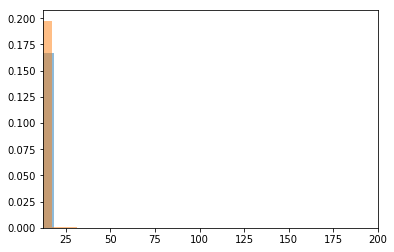

[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 15793 -15792     -1      0      0      0      0      0      0      0
      0      0      0      0      0      0]
15793 -15792 0.5 12
-15792 -1 6.33232016211e-05 17
-1 0 0 31
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 20826 -20820     -6      0      0      0      0      0      0      0
      0      0      0      0      0      0]
20826 -20820 0.5 12
-20820 -6 0.00028818443804 17
-6 0 0 31
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 25205 -25191    -14      0      0      0      0      0      0      0
      0      0      0      0      0      0]
25205 -25191 0.5 12
-25191 -14 0.000555864369094 17
-14 0 0 31
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 28062 -28016    -46      0      0      0      0      0      0      0
      0      0    

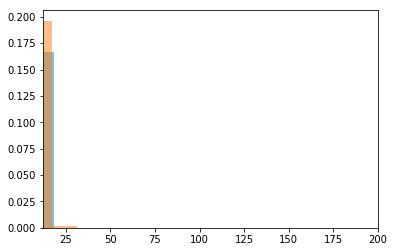

[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 18178 -18173     -5      0      0      0      0      0      0      0
      0      0      0      0      0      0]
18178 -18173 0.5 12
-18173 -5 0.000275178866263 17
-5 0 0 31
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 22855 -22846     -9      0      0      0      0      0      0      0
      0      0      0      0      0      0]
22855 -22846 0.5 12
-22846 -9 0.000394011032309 17
-9 0 0 31
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 26502 -26478    -24      0      0      0      0      0      0      0
      0      0      0      0      0      0]
26502 -26478 0.5 12
-26478 -24 0.00090661831369 17
-24 0 0 31
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 28716 -28645    -71      0      0      0      0      0      0      0
      0      0    

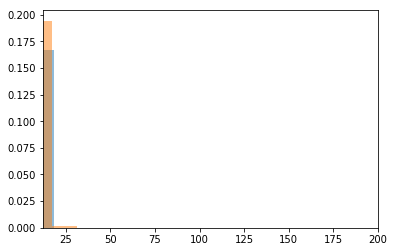

[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 20433 -20423    -10      0      0      0      0      0      0      0
      0      0      0      0      0      0]
20433 -20423 0.5 12
-20423 -10 0.00048971596474 17
-10 0 0 31
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 24536 -24514    -22      0      0      0      0      0      0      0
      0      0      0      0      0      0]
24536 -24514 0.5 12
-24514 -22 0.000897666068223 17
-22 0 0 31
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 27514 -27466    -48      0      0      0      0      0      0      0
      0      0      0      0      0      0]
27514 -27466 0.5 12
-27466 -48 0.00174825174825 17
-48 0 0 31
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 29078 -28956   -122      0      0      0      0      0      0      0
      0      0 

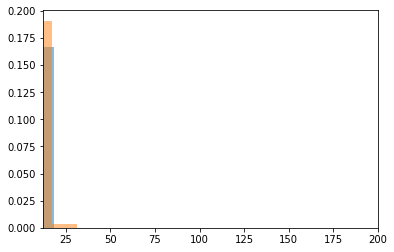

[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 22334 -22313    -21      0      0      0      0      0      0      0
      0      0      0      0      0      0]
22334 -22313 0.5 12
-22313 -21 0.000941619585687 17
-21 0 0 31
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 25924 -25883    -41      0      0      0      0      0      0      0
      0      0      0      0      0      0]
25924 -25883 0.5 12
-25883 -41 0.00158478605388 17
-41 0 0 31
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 28182 -28067   -115      0      0      0      0      0      0      0
      0      0      0      0      0      0]
28182 -28067 0.5 12
-28067 -115 0.00409836065574 17
-115 0 0 31
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 29264 -29003   -261      0      0      0      0      0      0      0
      0      

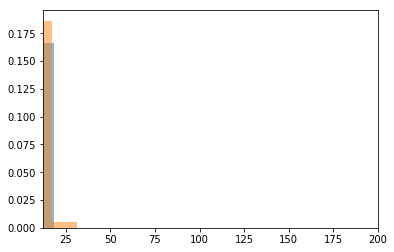

[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 24120 -24074    -46      0      0      0      0      0      0      0
      0      0      0      0      0      0]
24120 -24074 0.5 12
-24074 -46 0.0019120458891 17
-46 0 0 31
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 27048 -26954    -94      0      0      0      0      0      0      0
      0      0      0      0      0      0]
27048 -26954 0.5 12
-26954 -94 0.0034965034965 17
-94 0 0 31
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 28727 -28541   -186      0      0      0      0      0      0      0
      0      0      0      0      0      0]
28727 -28541 0.5 12
-28541 -186 0.00653594771242 17
-186 0 0 31
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 29274 -28836   -438      0      0      0      0      0      0      0
      0      0  

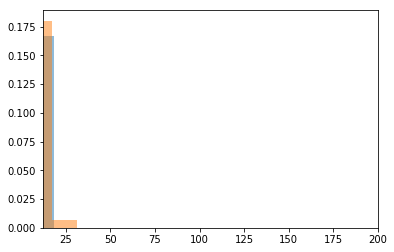

[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 25591 -25524    -67      0      0      0      0      0      0      0
      0      0      0      0      0      0]
25591 -25524 0.5 12
-25524 -67 0.00263157894737 17
-67 0 0 31
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 27824 -27681   -143      0      0      0      0      0      0      0
      0      0      0      0      0      0]
27824 -27681 0.5 12
-27681 -143 0.00518134715026 17
-143 0 0 31
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 28971 -28649   -322      0      0      0      0      0      0      0
      0      0      0      0      0      0]
28971 -28649 0.5 12
-28649 -322 0.0113636363636 17
-322 0 0 31
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 29144 -28470   -674      0      0      0      0      0      0      0
      0      

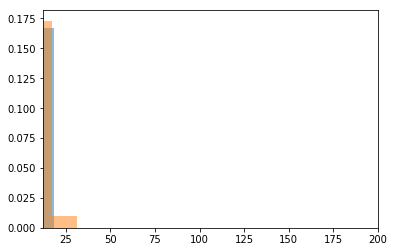

[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 26643 -26494   -149      0      0      0      0      0      0      0
      0      0      0      0      0      0]
26643 -26494 0.5 12
-26494 -149 0.00564971751412 17
-149 0 0 31
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 28355 -28097   -258      0      0      0      0      0      0      0
      0      0      0      0      0      0]
28355 -28097 0.5 12
-28097 -258 0.00925925925926 17
-258 0 0 31
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 29034 -28499   -535      0      0      0      0      0      0      0
      0      0      0      0      0      0]
29034 -28499 0.5 12
-28499 -535 0.0188679245283 17
-535 0 0 31
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 28866 -27820  -1046      0      0      0      0      0      0      0
      0    

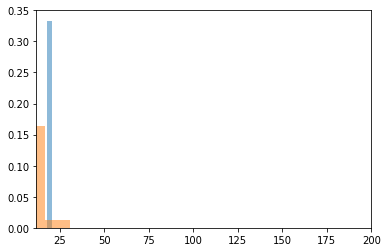

[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 27513 -27266   -247      0      0      0      0      0      0      0
      0      0      0      0      0      0]
27513 -27266 0.5 12
-27266 -247 0.00909090909091 17
-247 0 0 31
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 28682 -28231   -451      0      0      0      0      0      0      0
      0      0      0      0      0      0]
28682 -28231 0.5 12
-28231 -451 0.0161290322581 17
-451 0 0 31
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 28946 -28121   -825      0      0      0      0      0      0      0
      0      0      0      0      0      0]
28946 -28121 0.5 12
-28121 -825 0.0294117647059 17
-825 0 0 31
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 12
1 -1 0 18
-1 0 0 21
[ 28373 -26789  -1584      0      0      0      0      0      0      0
   

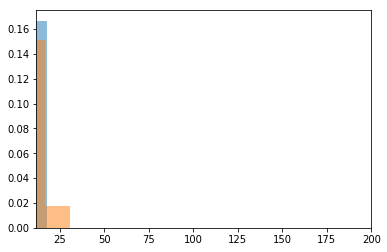

[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 28112 -27651   -461      0      0      0      0      0      0      0
      0      0      0      0      0      0]
28112 -27651 0.5 12
-27651 -461 0.0169491525424 17
-461 0 0 31
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 28665 -27861   -804      0      0      0      0      0      0      0
      0      0      0      0      0      0]
28665 -27861 0.5 12
-27861 -804 0.0294117647059 17
-804 0 0 31
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 28441 -27028  -1413      0      0      0      0      0      0      0
      0      0      0      0      0      0]
28441 -27028 0.5 12
-27028 -1413 0.0526315789474 17
-1413 0 0 31
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 27464 -24946  -2518      0      0      0      0      0      0      0
      0    

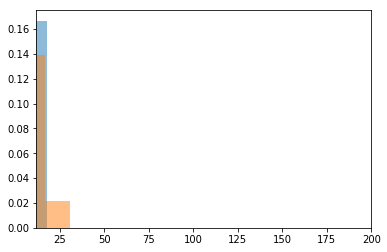

[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 28378 -27685   -693      0      0      0      0      0      0      0
      0      0      0      0      0      0]
28378 -27685 0.5 12
-27685 -693 0.025641025641 17
-693 0 0 31
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 28538 -27382  -1156      0      0      0      0      0      0      0
      0      0      0      0      0      0]
28538 -27382 0.5 12
-27382 -1156 0.0434782608696 17
-1156 0 0 31
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 28013 -26088  -1925      0      0      0      0      0      0      0
      0      0      0      0      0      0]
28013 -26088 0.5 12
-26088 -1925 0.0769230769231 17
-1925 0 0 31
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 26618 -23249  -3369      0      0      0      0      0      0      0
      0   

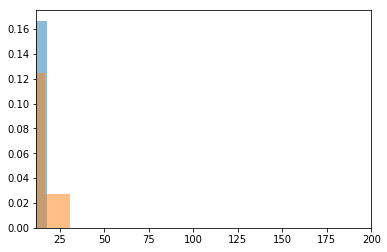

[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 28305 -27222  -1083      0      0      0      0      0      0      0
      0      0      0      0      0      0]
28305 -27222 0.5 12
-27222 -1083 0.04 17
-1083 0 0 31
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 28092 -26380  -1712      0      0      0      0      0      0      0
      0      0      0      0      0      0]
28092 -26380 0.5 12
-26380 -1712 0.0666666666667 17
-1712 0 0 31
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 27090 -24224  -2866      0      0      0      0      0      0      0
      0      0      0      0      0      0]
27090 -24224 0.5 12
-24224 -2866 0.125 17
-2866 0 0 31
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 25289 -20585  -4704      0      0      0      0      0      0      0
      0      0      0      0

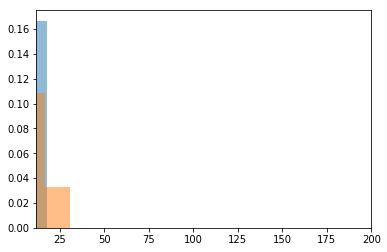

[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 27984 -26376  -1608      0      0      0      0      0      0      0
      0      0      0      0      0      0]
27984 -26376 0.5 12
-26376 -1608 0.0625 17
-1608 0 0 31
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 27309 -24748  -2561      0      0      0      0      0      0      0
      0      0      0      0      0      0]
27309 -24748 0.5 12
-24748 -2561 0.111111111111 17
-2561 0 0 31
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 25974 -21974  -4000      0      0      0      0      0      0      0
      0      0      0      0      0      0]
25974 -21974 0.5 12
-21974 -4000 0.2 17
-4000 0 0 31
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 23807 -17617  -6190      0      0      0      0      0      0      0
      0      0      0      0 

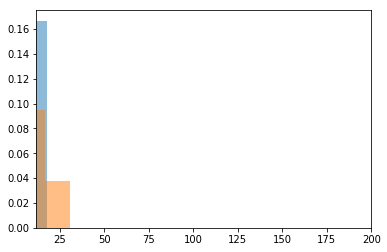

[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 27476 -25168  -2308      0      0      0      0      0      0      0
      0      0      0      0      0      0]
27476 -25168 0.5 12
-25168 -2308 0.1 17
-2308 0 0 31
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 26414 -22889  -3525      0      0      0      0      0      0      0
      0      0      0      0      0      0]
26414 -22889 0.5 12
-22889 -3525 0.166666666667 17
-3525 0 0 31
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 24653 -19316  -5337      0      0      0      0      0      0      0
      0      0      0      0      0      0]
24653 -19316 0.5 12
-19316 -5337 0.333333333333 17
-5337 0 0 31
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 22000 -14003  -7996     -1      0      0      0      0      0      0
      0      0      0

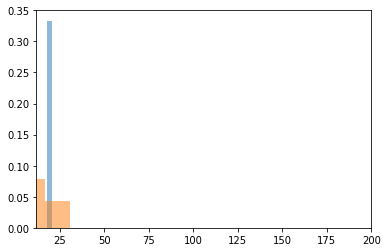

[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 26560 -23241  -3318     -1      0      0      0      0      0      0
      0      0      0      0      0      0]
26560 -23241 0.5 12
-23241 -3318 0.142857142857 17
-3318 -1 0.000301386377336 31
-1 0 0 40
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 25134 -20298  -4835     -1      0      0      0      0      0      0
      0      0      0      0      0      0]
25134 -20298 0.5 12
-20298 -4835 0.25 17
-4835 -1 0.000206825232678 31
-1 0 0 40
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 22925 -15856  -7068     -1      0      0      0      0      0      0
      0      0      0      0      0      0]
22925 -15856 0.5 12
-15856 -7068 0.5 17
-7068 -1 0.000141482739106 31
-1 0 0 40
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 20016 -10035  -9979

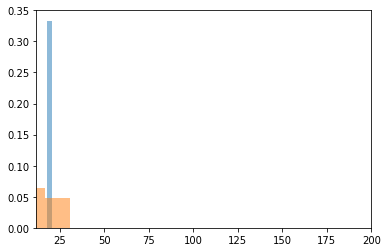

[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 25309 -20684  -4623     -2      0      0      0      0      0      0
      0      0      0      0      0      0]
25309 -20684 0.5 12
-20684 -4623 0.25 17
-4623 -2 0.000432713111207 31
-2 0 0 40
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 23448 -16913  -6533     -2      0      0      0      0      0      0
      0      0      0      0      0      0]
23448 -16913 0.5 12
-16913 -6533 0.5 17
-6533 -2 0.000306184935701 31
-2 0 0 40
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 20892 -11790  -9100     -2      0      0      0      0      0      0
      0      0      0      0      0      0]
20892 -11790 0.5 12
-11790 -9100 0 17
-9100 -2 0.00021978021978 31
-2 0 0 40
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 17724  -5451 -12271     -2      0

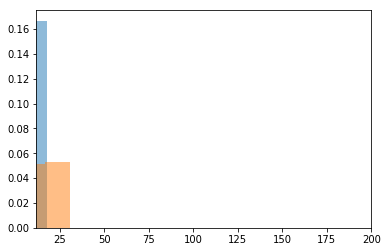

[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 23895 -17833  -6058     -4      0      0      0      0      0      0
      0      0      0      0      0      0]
23895 -17833 0.5 12
-17833 -6058 0.5 17
-6058 -4 0.000660501981506 31
-4 0 0 40
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 21823 -13652  -8167     -4      0      0      0      0      0      0
      0      0      0      0      0      0]
21823 -13652 0.5 12
-13652 -8167 0 17
-8167 -4 0.000489955903969 31
-4 0 0 40
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 19040  -8084 -10952     -4      0      0      0      0      0      0
      0      0      0      0      0      0]
19040 -8084 0.666666666667 12
-8084 -10952 0 17
-10952 -4 0.00036523009496 31
-4 0 0 40
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 15563  -1132 -14425     -

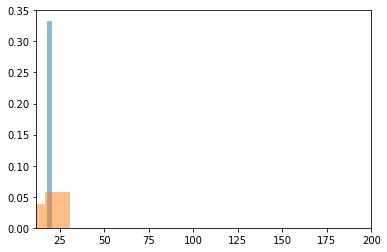

[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 21943 -13906  -8037      0      0      0      0      0      0      0
      0      0      0      0      0      0]
21943 -13906 0.5 12
-13906 -8037 0 17
-8037 0 0 31
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 19425  -8856 -10569      0      0      0      0      0      0      0
      0      0      0      0      0      0]
19425 -8856 0.666666666667 12
-8856 -10569 0 17
-10569 0 0 31
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 16465  -2932 -13531     -2      0      0      0      0      0      0
      0      0      0      0      0      0]
16465 -2932 0.833333333333 12
-2932 -13531 0 17
-13531 -2 0.000147819660015 31
-2 0 0 40
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 12942   4112 -17050     -4      0      0      0      0      0      0


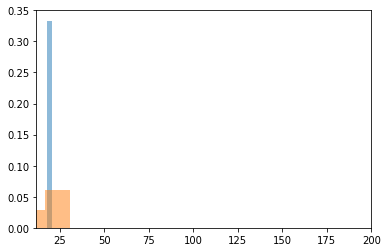

[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[19976 -9977 -9983   -16     0     0     0     0     0     0     0     0
     0     0     0     0]
19976 -9977 0.666666666667 12
-9977 -9983 0 17
-9983 -16 0.0016051364366 31
-16 0 0 40
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 17237  -4496 -12720    -21      0      0      0      0      0      0
      0      0      0      0      0      0]
17237 -4496 0.75 12
-4496 -12720 0 17
-12720 -21 0.00165289256198 31
-21 0 0 40
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 14208   1561 -15746    -23      0      0      0      0      0      0
      0      0      0      0      0      0]
14208 1561 0.888888888889 12
1561 -15746 0 17
-15746 -23 0.00146198830409 31
-23 0 0 40
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 10705   8561 -19237    -29      

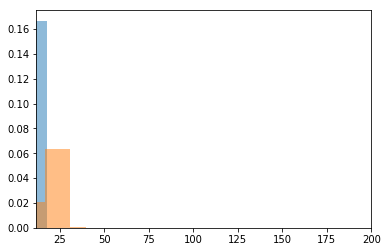

[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 17761  -5536 -12216     -8     -1      0      0      0      0      0
      0      0      0      0      0      0]
17761 -5536 0.75 12
-5536 -12216 0 17
-12216 -8 0.000654878847413 31
-8 -1 0.125 40
-1 0 0 45.5
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 14939    111 -15041     -8     -1      0      0      0      0      0
      0      0      0      0      0      0]
14939 111 0.992537313433 12
111 -15041 0 17
-15041 -8 0.000531914893617 31
-8 -1 0.125 40
-1 0 0 45.5
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 11879   6226 -18090    -14     -1      0      0      0      0      0
      0      0      0      0      0      0]
11879 6226 1 12
6226 -18090 0 17
-18090 -14 0.00077399380805 31
-14 -1 0.0714285714286 40
-1 0 0 45.5
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0 

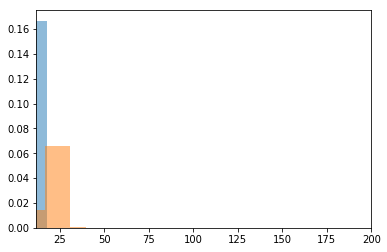

[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 15356   -747 -14581    -27     -1      0      0      0      0      0
      0      0      0      0      0      0]
15356 -747 0.952380952381 12
-747 -14581 0 17
-14581 -27 0.00185185185185 31
-27 -1 0.037037037037 40
-1 0 0 45.5
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 12643   4671 -17273    -40     -1      0      0      0      0      0
      0      0      0      0      0      0]
12643 4671 0.5 12
4671 -17273 0 17
-17273 -40 0.00232018561485 31
-40 -1 0.025 40
-1 0 0 45.5
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[  9582  10780 -20308    -52     -2      0      0      0      0      0
      0      0      0      0      0      0]
9582 10780 1 12
10780 -20308 0 17
-20308 -52 0.0025641025641 31
-52 -2 0.0384615384615 40
-2 0 0 45.5
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0

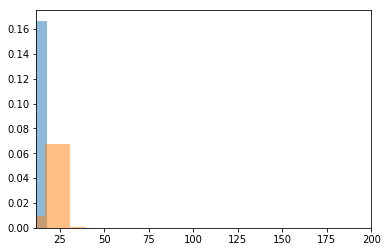

[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 12971   4010 -16933    -48      0      0      0      0      0      0
      0      0      0      0      0      0]
12971 4010 0.666666666667 12
4010 -16933 0 17
-16933 -48 0.00284090909091 31
-48 0 0 40
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 10200   9540 -19680    -60      0      0      0      0      0      0
      0      0      0      0      0      0]
10200 9540 1 12
9540 -19680 0 17
-19680 -60 0.0030487804878 31
-60 0 0 40
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[  7478  14961 -22356    -83      0      0      0      0      0      0
      0      0      0      0      0      0]
7478 14961 1 12
14961 -22356 0 17
-22356 -83 0.00371747211896 31
-83 0 0 40
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[  4999  19885 -24767   -117      0

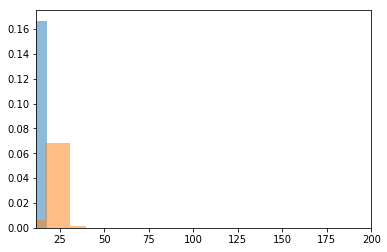

[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 10742   8414 -19059    -93     -4      0      0      0      0      0
      0      0      0      0      0      0]
10742 8414 1 12
8414 -19059 0 17
-19059 -93 0.00490196078431 31
-93 -4 0.0434782608696 40
-4 0 0 45.5
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[  8343  13184 -21401   -122     -4      0      0      0      0      0
      0      0      0      0      0      0]
8343 13184 1 12
13184 -21401 0 17
-21401 -122 0.00571428571429 31
-122 -4 0.0333333333333 40
-4 0 0 45.5
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[  5915  18001 -23751   -161     -4      0      0      0      0      0
      0      0      0      0      0      0]
5915 18001 1 12
18001 -23751 0 17
-23751 -161 0.00680272108844 31
-161 -4 0.025 40
-4 0 0 45.5
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  

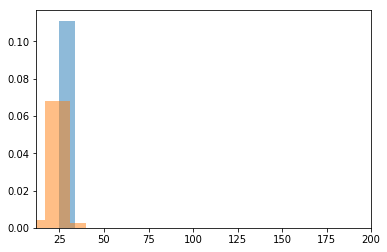

[ 0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 18
1 -1 0 21
-1 0 0 24.5
[  8603  12568 -20958   -200    -13      0      0      0      0      0
      0      0      0      0      0      0]
8603 12568 1 12
12568 -20958 0 17
-20958 -200 0.00961538461538 31
-200 -13 0.0666666666667 40
-13 0 0 45.5
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 18
1 -1 0 21
-1 0 0 24.5
[  6321  17079 -23134   -253    -13      0      0      0      0      0
      0      0      0      0      0      0]
6321 17079 1 12
17079 -23134 0 17
-23134 -253 0.010989010989 31
-253 -13 0.0526315789474 40
-13 0 0 45.5
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 18
1 -1 0 21
-1 0 0 24.5
[  4367  20919 -24953   -319    -14      0      0      0      0      0
      0      0      0      0      0      0]
4367 20919 1 12
20919 -24953 0 17
-24953 -319 0.0128205128205 31
-319 -14 0.0454545454545 40
-14 0 0 45.5
[0 0 0 0 0 0 0 0 0 0 0 0 0

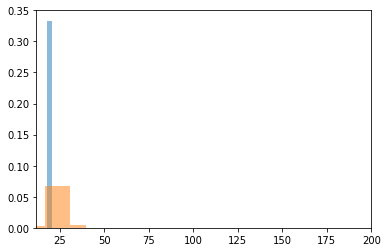

[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[  6831  15989 -22487   -320    -10     -3      0      0      0      0
      0      0      0      0      0      0]
6831 15989 1 12
15989 -22487 0 17
-22487 -320 0.0142857142857 31
-320 -10 0.03125 40
-10 -3 0.333333333333 45.5
-3 0 0 50.5
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[  4867  19838 -24297   -391    -14     -3      0      0      0      0
      0      0      0      0      0      0]
4867 19838 1 12
19838 -24297 0 17
-24297 -391 0.0161290322581 31
-391 -14 0.037037037037 40
-14 -3 0.25 45.5
-3 0 0 50.5
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[  3167  23128 -25781   -493    -18     -3      0      0      0      0
      0      0      0      0      0      0]
3167 23128 1 12
23128 -25781 0 17
-25781 -493 0.0192307692308 31
-493 -18 0.037037037037 40
-18 -3 0.166666666667 45.5
-3 0 0 50.5
[

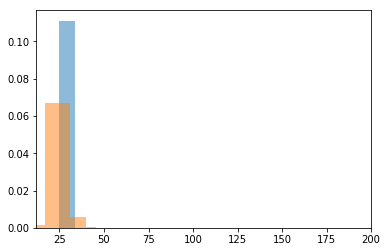

[ 0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 18
1 -1 0 21
-1 0 0 24.5
[  5259  18937 -23691   -468    -34     -3      0      0      0      0
      0      0      0      0      0      0]
5259 18937 1 12
18937 -23691 0 17
-23691 -468 0.02 31
-468 -34 0.0769230769231 40
-34 -3 0.0909090909091 45.5
-3 0 0 50.5
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 18
1 -1 0 21
-1 0 0 24.5
[  3582  22190 -25166   -569    -34     -3      0      0      0      0
      0      0      0      0      0      0]
3582 22190 1 12
22190 -25166 0 17
-25166 -569 0.0227272727273 31
-569 -34 0.0625 40
-34 -3 0.0909090909091 45.5
-3 0 0 50.5
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 21
1 -1 0 24.5
-1 0 0 33.5
[  2226  24750 -26224   -709    -40     -3      0      0      0      0
      0      0      0      0      0      0]
2226 24750 1 12
24750 -26224 0 17
-26224 -709 0.0277777777778 31
-709 -40 0.0588235294118 40
-40

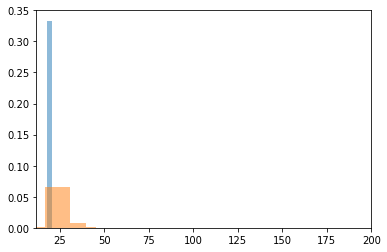

[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[  3869  21402 -24478   -738    -46     -6     -3      0      0      0
      0      0      0      0      0      0]
3869 21402 1 12
21402 -24478 0 17
-24478 -738 0.030303030303 31
-738 -46 0.0625 40
-46 -6 0.142857142857 45.5
-6 -3 0.5 50.5
-3 0 0 60.5
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[  2541  23898 -25491   -888    -50     -8     -2      0      0      0
      0      0      0      0      0      0]
2541 23898 1 12
23898 -25491 0 17
-25491 -888 0.0357142857143 31
-888 -50 0.0588235294118 40
-50 -8 0.166666666667 45.5
-8 -2 0.25 50.5
-2 0 0 60.5
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[  1511  25730 -26067  -1112    -52     -8     -2      0      0      0
      0      0      0      0      0      0]
1511 25730 1 12
25730 -26067 0 17
-26067 -1112 0.0434782608696 31
-1112 -52 0.047619047619 4

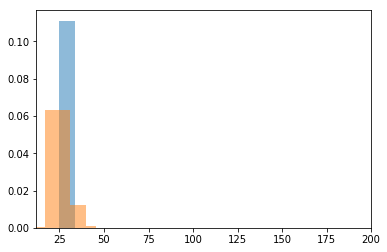

[ 0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 21
1 -1 0 24.5
-1 0 0 33.5
[  2724  23144 -24566  -1217    -67    -15     -3      0      0      0
      0      0      0      0      0      0]
2724 23144 1 12
23144 -24566 0 17
-24566 -1217 0.05 31
-1217 -67 0.0555555555556 40
-67 -15 0.25 45.5
-15 -3 0.2 50.5
-3 0 0 60.5
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 21
1 -1 0 24.5
-1 0 0 33.5
[  1698  24958 -25123  -1441    -74    -15     -3      0      0      0
      0      0      0      0      0      0]
1698 24958 1 12
24958 -25123 0 17
-25123 -1441 0.0588235294118 31
-1441 -74 0.0526315789474 40
-74 -15 0.25 45.5
-15 -3 0.2 50.5
-3 0 0 60.5
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 21
1 -1 0 24.5
-1 0 0 33.5
[   955  26169 -25325  -1698    -83    -15     -3      0      0      0
      0      0      0      0      0      0]
955 26169 1 12
26169 -25325 0.25 17
-25325 -1698 0.0714285714286 31

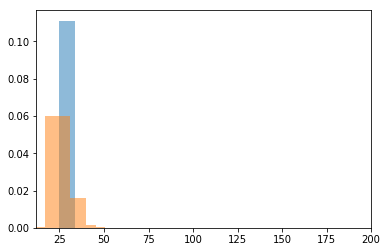

[ 0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 18
1 -1 0 21
-1 0 0 24.5
[  1848  24316 -24377  -1623   -137    -17    -10      0      0      0
      0      0      0      0      0      0]
1848 24316 1 12
24316 -24377 0 17
-24377 -1623 0.0666666666667 31
-1623 -137 0.0909090909091 40
-137 -17 0.125 45.5
-17 -10 0 50.5
-10 0 0 60.5
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 18
1 -1 0 21
-1 0 0 24.5
[  1132  25426 -24465  -1913   -152    -19     -9      0      0      0
      0      0      0      0      0      0]
1132 25426 1 12
25426 -24465 0.25 17
-24465 -1913 0.0833333333333 31
-1913 -152 0.0833333333333 40
-152 -19 0.125 45.5
-19 -9 0.5 50.5
-9 0 0 60.5
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 18
1 -1 0 21
-1 0 0 24.5
[   629  26041 -24203  -2270   -167    -23     -7      0      0      0
      0      0      0      0      0      0]
629 26041 1 12
26041 -24203 0.25 17
-24203 -2270 0.1 

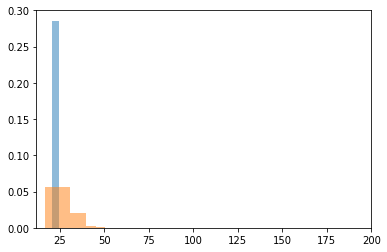

[ 0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 12
1 -1 0 18
-1 0 0 21
[  1241  24555 -23238  -2238   -249    -57    -14      0      0      0
      0      0      0      0      0      0]
1241 24555 1 12
24555 -23238 0.25 17
-23238 -2238 0.1 31
-2238 -249 0.125 40
-249 -57 0.25 45.5
-57 -14 0.25 50.5
-14 0 0 60.5
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 12
1 -1 0 18
-1 0 0 21
[   757  25112 -22924  -2598   -278    -56    -13      0      0      0
      0      0      0      0      0      0]
757 25112 1 12
25112 -22924 0.25 17
-22924 -2598 0.125 31
-2598 -278 0.111111111111 40
-278 -56 0.25 45.5
-56 -13 0.25 50.5
-13 0 0 60.5
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 12
1 -1 0 18
-1 0 0 21
[   416  25341 -22393  -2981   -314    -58    -11      0      0      0
      0      0      0      0      0      0]
416 25341 1 12
25341 -22393 0.25 17
-22393 -2981 0.142857142857 31
-2981 -314 0.111111

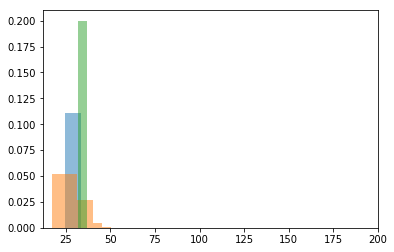

[ 0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 18
1 -1 0 21
-1 0 0 24.5
[   804  24193 -21404  -3155   -304   -100    -34      0      0      0
      0      0      0      0      0      0]
804 24193 1 12
24193 -21404 0.25 17
-21404 -3155 0.166666666667 31
-3155 -304 0.1 40
-304 -100 0.333333333333 45.5
-100 -34 0.5 50.5
-34 0 0 60.5
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 18
1 -1 0 21
-1 0 0 24.5
[   457  24361 -20741  -3597   -342   -108    -30      0      0      0
      0      0      0      0      0      0]
457 24361 1 12
24361 -20741 0.25 17
-20741 -3597 0.2 31
-3597 -342 0.1 40
-342 -108 0.333333333333 45.5
-108 -30 0.333333333333 50.5
-30 0 0 60.5
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 32
-1 0 0 37
[ 0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 18
1 -1 0 21
-1 0 0 24.5
[   250  24173 -19789  -4107   -387   -114    -26      0      0      0
      0      0      0      0      0      0]
250 24173 1 12
2

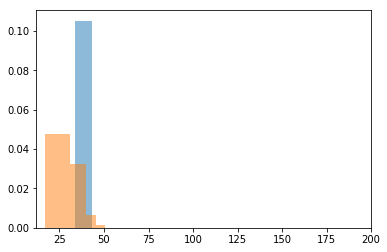

[ 0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0]
0 1 1 24.5
1 -1 0 33.5
-1 0 0 43
[   475  23530 -19412  -3929   -474   -119    -70      0     -1      0
      0      0      0      0      0      0]
475 23530 1 12
23530 -19412 0.25 17
-19412 -3929 0.25 31
-3929 -474 0.125 40
-474 -119 0.333333333333 45.5
-119 -70 0 50.5
-70 0 0 60.5
0 -1 0 68
-1 0 0 91
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0]
0 1 1 24.5
1 -1 0 33.5
-1 0 0 43
[   259  23353 -18452  -4453   -511   -132    -63      0     -1      0
      0      0      0      0      0      0]
259 23353 1 12
23353 -18452 0.25 17
-18452 -4453 0.25 31
-4453 -511 0.125 40
-511 -132 0.333333333333 45.5
-132 -63 0.5 50.5
-63 0 0 60.5
0 -1 0 68
-1 0 0 91
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0]
0 1 1 24.5
1 -1 0 33.5
-1 0 0 43
[   127  22921 -17260  -5011   -577   -142    -57      0     -1      0
      0      0      0      0      0      0]
127 22921 1 12
22921 -17

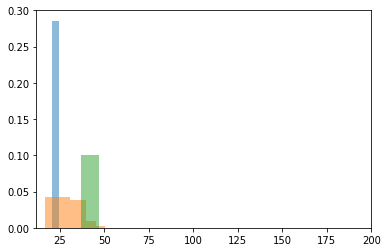

[ 0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 12
1 -1 0 18
-1 0 0 21
[   288  22115 -16558  -4825   -707   -187   -122     -3     -1      0
      0      0      0      0      0      0]
288 22115 1 12
22115 -16558 0.25 17
-16558 -4825 0.333333333333 31
-4825 -707 0.166666666667 40
-707 -187 0.333333333333 45.5
-187 -122 0 50.5
-122 -3 0.025 60.5
-3 -1 0.333333333333 68
-1 0 0 91
[ 0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 32
1 -1 0 37
-1 0 0 47
[ 0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 12
1 -1 0 18
-1 0 0 21
[   153  21668 -15333  -5390   -779   -202   -114     -2     -1      0
      0      0      0      0      0      0]
153 21668 1 12
21668 -15333 0.25 17
-15333 -5390 0.5 31
-5390 -779 0.166666666667 40
-779 -202 0.333333333333 45.5
-202 -114 0 50.5
-114 -2 0.0175438596491 60.5
-2 -1 0.5 68
-1 0 0 91
[ 0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 32
1 -1 0 37
-1 0 0 47
[ 0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 12
1 -1 0 18
-1 0 

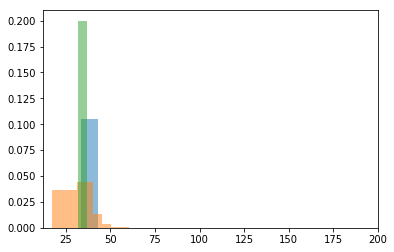

[ 0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 21
1 -1 0 24.5
-1 0 0 33.5
[   175  20375 -13461  -5628   -974   -264   -210    -11     -2      0
      0      0      0      0      0      0]
175 20375 1 12
20375 -13461 0.25 17
-13461 -5628 0.5 31
-5628 -974 0.2 40
-974 -264 0.333333333333 45.5
-264 -210 0 50.5
-210 -11 0.0526315789474 60.5
-11 -2 0.2 68
-2 0 0 91
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 32
-1 0 0 37
[ 0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 21
1 -1 0 24.5
-1 0 0 33.5
[    87  19792 -12156  -6131  -1095   -289   -196    -10     -2      0
      0      0      0      0      0      0]
87 19792 1 12
19792 -12156 0.25 17
-12156 -6131 0 31
-6131 -1095 0.2 40
-1095 -289 0.333333333333 45.5
-289 -196 0 50.5
-196 -10 0.0526315789474 60.5
-10 -2 0.2 68
-2 0 0 91
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 32
-1 0 0 37
[ 0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 21
1 -1 0 24.5
-1 0 0 33.5
[    45  18951 -10471  -6803  -1

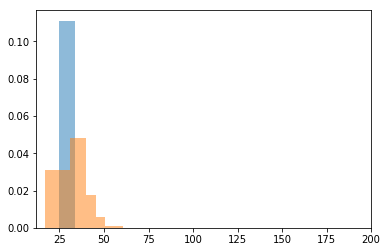

[ 0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 21
1 -1 0 24.5
-1 0 0 33.5
[    95  18560 -10541  -6156  -1181   -410   -336    -28     -3      0
      0      0      0      0      0      0]
95 18560 1 12
18560 -10541 0.25 17
-10541 -6156 0 31
-6156 -1181 0.2 40
-1181 -410 0.5 45.5
-410 -336 0 50.5
-336 -28 0.0833333333333 60.5
-28 -3 0.111111111111 68
-3 0 0 91
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 21
1 -1 0 24.5
-1 0 0 33.5
[   58 17740 -8909 -6803 -1291  -450  -319   -23    -3     0     0     0
     0     0     0     0]
58 17740 1 12
17740 -8909 0.25 17
-8909 -6803 0 31
-6803 -1291 0.2 40
-1291 -450 0.5 45.5
-450 -319 0 50.5
-319 -23 0.0769230769231 60.5
-23 -3 0.142857142857 68
-3 0 0 91
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 21
1 -1 0 24.5
-1 0 0 33.5
[   17 16816 -7085 -7507 -1429  -487  -303   -20    -2     0     0     0
     0     0     0     0]
17 16816 1 12
16816 -708

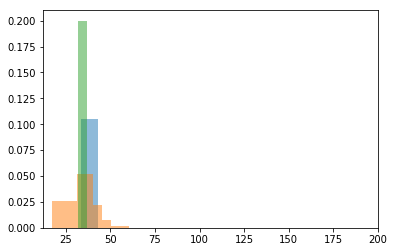

[ 0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0]
0 1 1 24.5
1 -1 0 33.5
-1 0 0 43
[   52 16341 -6990 -6948 -1396  -469  -546   -40    -4     0     0     0
     0     0     0     0]
52 16341 1 12
16341 -6990 0.166666666667 17
-6990 -6948 0 31
-6948 -1396 0.25 40
-1396 -469 0.5 45.5
-469 -546 0 50.5
-546 -40 0.0769230769231 60.5
-40 -4 0.1 68
-4 0 0 91
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0]
0 1 1 24.5
1 -1 0 33.5
-1 0 0 43
[   24 15511 -5430 -7453 -1569  -521  -527   -31    -4     0     0     0
     0     0     0     0]
24 15511 1 12
15511 -5430 0.166666666667 17
-5430 -7453 0 31
-7453 -1569 0.25 40
-1569 -521 0.333333333333 45.5
-521 -527 0 50.5
-527 -31 0.0588235294118 60.5
-31 -4 0.142857142857 68
-4 0 0 91
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0]
0 1 1 24.5
1 -1 0 33.5
-1 0 0 43
[    8 14484 -3533 -8092 -1753  -585  -501   -25    -3     0     0     0
     0     0     0     0]
8 14484 1 12
14484 -

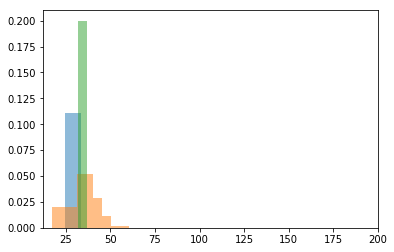

[ 0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 21
1 -1 0 24.5
-1 0 0 33.5
[   25 13825 -3552 -6974 -1807  -631  -799   -74   -13     0     0     0
     0     0     0     0]
25 13825 1 12
13825 -3552 0.125 17
-3552 -6974 0 31
-6974 -1807 0.333333333333 40
-1807 -631 0.5 45.5
-631 -799 0 50.5
-799 -74 0.1 60.5
-74 -13 0.2 68
-13 0 0 91
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 21
1 -1 0 24.5
-1 0 0 33.5
[   11 12984 -2056 -7377 -1989  -738  -762   -61   -12     0     0     0
     0     0     0     0]
11 12984 1 12
12984 -2056 0.0714285714286 17
-2056 -7377 0 31
-7377 -1989 0.333333333333 40
-1989 -738 0.5 45.5
-738 -762 0 50.5
-762 -61 0.0833333333333 60.5
-61 -12 0.2 68
-12 0 0 91
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 21
1 -1 0 24.5
-1 0 0 33.5
[    5 11979  -256 -7930 -2169  -841  -728   -52    -8     0     0     0
     0     0     0     0]
5 11979 1 12
11979 -256 0.010638297872

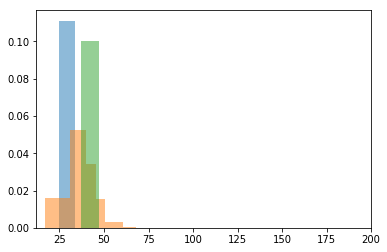

[ 0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 21
1 -1 0 24.5
-1 0 0 33.5
[   13 11839 -1130 -6679 -2094  -710 -1073  -150   -16     0     0     0
     0     0     0     0]
13 11839 1 12
11839 -1130 0.0454545454545 17
-1130 -6679 0 31
-6679 -2094 0.333333333333 40
-2094 -710 0.5 45.5
-710 -1073 0 50.5
-1073 -150 0.142857142857 60.5
-150 -16 0.111111111111 68
-16 0 0 91
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 32
-1 0 0 37
[ 0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 21
1 -1 0 24.5
-1 0 0 33.5
[    4 10976   429 -7167 -2225  -820 -1056  -131   -10     0     0     0
     0     0     0     0]
4 10976 1 12
10976 429 0.96 17
429 -7167 0 31
-7167 -2225 0.333333333333 40
-2225 -820 0.5 45.5
-820 -1056 0 50.5
-1056 -131 0.125 60.5
-131 -10 0.0769230769231 68
-10 0 0 91
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 32
-1 0 0 37
[ 0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 21
1 -1 0 24.5
-1 0 0 33.5
[    1 10063  1976 -7493 -2458  -943 -1

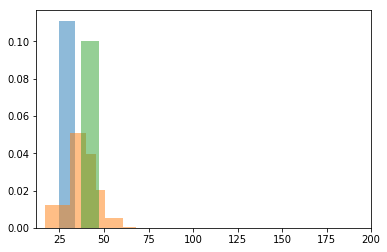

[ 0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 21
1 -1 0 24.5
-1 0 0 33.5
[    6  9488  1572 -6370 -2191  -605 -1629  -209   -62     0     0     0
     0     0     0     0]
6 9488 1 12
9488 1572 0.833333333333 17
1572 -6370 0 31
-6370 -2191 0.5 40
-2191 -605 0.333333333333 45.5
-605 -1629 0 50.5
-1629 -209 0.142857142857 60.5
-209 -62 0.333333333333 68
-62 0 0 91
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 32
-1 0 0 37
[ 0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 21
1 -1 0 24.5
-1 0 0 33.5
[    3  8708  2842 -6542 -2419  -738 -1628  -176   -50     0     0     0
     0     0     0     0]
3 8708 1 12
8708 2842 0.666666666667 17
2842 -6542 0 31
-6542 -2419 0.5 40
-2419 -738 0.333333333333 45.5
-738 -1628 0 50.5
-1628 -176 0.111111111111 60.5
-176 -50 0.333333333333 68
-50 0 0 91
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 32
-1 0 0 37
[ 0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 21
1 -1 0 24.5
-1 0 0 33.5
[    2  7881  4210 -6774 -2

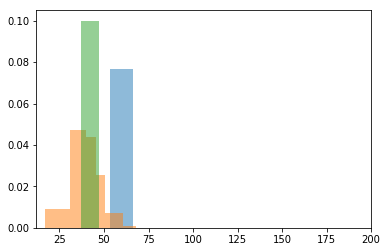

[ 0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0]
0 1 1 43
1 -1 0 53.5
-1 0 0 66.5
[    0  7516  3392 -5668 -2047  -555 -2232  -307   -99     0     0     0
     0     0     0     0]
0 7516 1 12
7516 3392 0.5 17
3392 -5668 0 31
-5668 -2047 0.5 40
-2047 -555 0.333333333333 45.5
-555 -2232 0 50.5
-2232 -307 0.142857142857 60.5
-307 -99 0.333333333333 68
-99 0 0 91
[ 0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 37
1 -1 0 47
-1 0 0 57.5
[ 0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0]
0 1 1 43
1 -1 0 53.5
-1 0 0 66.5
[    0  6820  4480 -5731 -2271  -704 -2255  -259   -80     0     0     0
     0     0     0     0]
0 6820 1 12
6820 4480 1 17
4480 -5731 0 31
-5731 -2271 0.5 40
-2271 -704 0.333333333333 45.5
-704 -2255 0 50.5
-2255 -259 0.125 60.5
-259 -80 0.333333333333 68
-80 0 0 91
[ 0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 37
1 -1 0 47
-1 0 0 57.5
[ 0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0]
0 1 1 43
1 -1 0 53.5
-1 0 0 66.5
[    0  6096  5602 -5781 -2493  -905 -

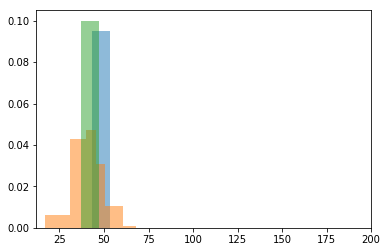

[ 0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0]
0 1 1 33.5
1 -1 0 43
-1 0 0 53.5
[    1  5667  4761 -4698 -2052   -52 -2939  -511  -177     0     0     0
     0     0     0     0]
1 5667 1 12
5667 4761 1 17
4761 -4698 0.25 31
-4698 -2052 0.5 40
-2052 -52 0.025641025641 45.5
-52 -2939 0 50.5
-2939 -511 0.2 60.5
-511 -177 0.5 68
-177 0 0 91
[ 0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 32
1 -1 0 37
-1 0 0 47
[ 0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0]
0 1 1 33.5
1 -1 0 43
-1 0 0 53.5
[    1  5082  5648 -4699 -2190  -252 -3002  -455  -133     0     0     0
     0     0     0     0]
1 5082 1 12
5082 5648 1 17
5648 -4699 0.25 31
-4699 -2190 0.5 40
-2190 -252 0.125 45.5
-252 -3002 0 50.5
-3002 -455 0.166666666667 60.5
-455 -133 0.333333333333 68
-133 0 0 91
[ 0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 32
1 -1 0 37
-1 0 0 47
[ 0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0]
0 1 1 33.5
1 -1 0 43
-1 0 0 53.5
[    0  4501  6454 -4548 -2362  -553 -2980  -424   -88    

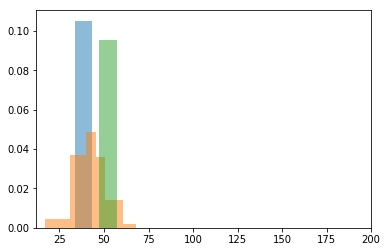

[ 0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0]
0 1 1 24.5
1 -1 0 33.5
-1 0 0 43
[    0  4366  5018 -3336 -1755   242 -3463  -771  -300    -1     0     0
     0     0     0     0]
0 4366 1 12
4366 5018 1 17
5018 -3336 0.25 31
-3336 -1755 0 40
-1755 242 0.125 45.5
242 -3463 0 50.5
-3463 -771 0.25 60.5
-771 -300 0.5 68
-300 -1 0.00333333333333 91
-1 0 0 102.5
[ 0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 37
1 -1 0 47
-1 0 0 57.5
[ 0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0]
0 1 1 24.5
1 -1 0 33.5
-1 0 0 43
[    0  3888  5660 -3158 -1922    63 -3589  -709  -233     0     0     0
     0     0     0     0]
0 3888 1 12
3888 5660 1 17
5660 -3158 0.25 31
-3158 -1922 0 40
-1922 63 0.0322580645161 45.5
63 -3589 0 50.5
-3589 -709 0.2 60.5
-709 -233 0.333333333333 68
-233 0 0 91
[ 0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 37
1 -1 0 47
-1 0 0 57.5
[ 0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0]
0 1 1 24.5
1 -1 0 33.5
-1 0 0 43
[    0  3377  6348 -2967 -2079  -216 -3635

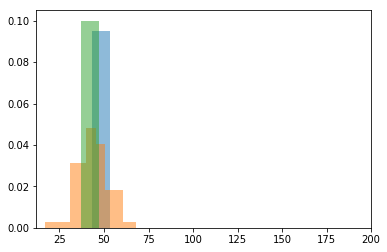

[ 0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0]
0 1 1 33.5
1 -1 0 43
-1 0 0 53.5
[    0  3073  5319 -2432 -1188  1035 -4316  -986  -505     0     0     0
     0     0     0     0]
0 3073 1 12
3073 5319 1 17
5319 -2432 0.166666666667 31
-2432 -1188 0.5 40
-1188 1035 0.5 45.5
1035 -4316 0 50.5
-4316 -986 0.25 60.5
-986 -505 0 68
-505 0 0 91
[ 0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 32
1 -1 0 37
-1 0 0 47
[ 0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0]
0 1 1 33.5
1 -1 0 43
-1 0 0 53.5
[    0  2675  5818 -2221 -1255   781 -4443  -965  -390     0     0     0
     0     0     0     0]
0 2675 1 12
2675 5818 1 17
5818 -2221 0.166666666667 31
-2221 -1255 0 40
-1255 781 0.5 45.5
781 -4443 0 50.5
-4443 -965 0.25 60.5
-965 -390 0.5 68
-390 0 0 91
[ 0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 32
1 -1 0 37
-1 0 0 47
[ 0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0]
0 1 1 33.5
1 -1 0 43
-1 0 0 53.5
[    0  2288  6283 -1965 -1349   539 -4593  -924  -279     0     0     0
  

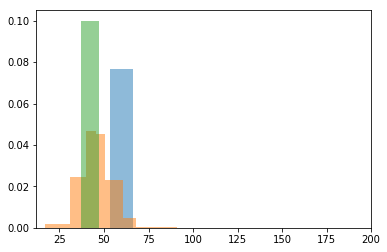

[ 0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0]
0 1 1 43
1 -1 0 53.5
-1 0 0 66.5
[    0  2129  4755  -928  -686  1721 -5011 -1194  -782    -4     0     0
     0     0     0     0]
0 2129 1 12
2129 4755 1 17
4755 -928 0.0833333333333 31
-928 -686 0 40
-686 1721 0 45.5
1721 -5011 0 50.5
-5011 -1194 0.25 60.5
-1194 -782 0 68
-782 -4 0.00512820512821 91
-4 0 0 102.5
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 32
-1 0 0 37
[ 0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0]
0 1 1 43
1 -1 0 53.5
-1 0 0 66.5
[    0  1852  5033  -629  -717  1500 -5220 -1211  -606    -2     0     0
     0     0     0     0]
0 1852 1 12
1852 5033 1 17
5033 -629 0.0555555555556 31
-629 -717 0 40
-717 1500 0 45.5
1500 -5220 0 50.5
-5220 -1211 0.25 60.5
-1211 -606 0 68
-606 -2 0.003300330033 91
-2 0 0 102.5
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 32
-1 0 0 37
[ 0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0]
0 1 1 43
1 -1 0 53.5
-1 0 0 66.5
[    0  1575  5331  -355  -753  1267 -5442 -1

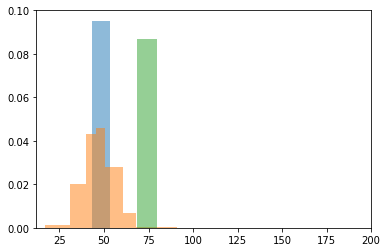

[ 0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0]
0 1 1 33.5
1 -1 0 43
-1 0 0 53.5
[    0  1473  4378  -336  -282  2625 -5083 -1486 -1283    -6     0     0
     0     0     0     0]
0 1473 1 12
1473 4378 1 17
4378 -336 0.0357142857143 31
-336 -282 0 40
-282 2625 0 45.5
2625 -5083 0 50.5
-5083 -1486 0.333333333333 60.5
-1486 -1283 0 68
-1283 -6 0.00469483568075 91
-6 0 0 102.5
[ 0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0]
0 1 1 57.5
1 -1 0 68.5
-1 0 0 80
[ 0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0]
0 1 1 33.5
1 -1 0 43
-1 0 0 53.5
[    0  1260  4544   -11  -278  2508 -5447 -1551 -1021    -4     0     0
     0     0     0     0]
0 1260 1 12
1260 4544 1 17
4544 -11 0.0012077294686 31
-11 -278 0 40
-278 2508 0 45.5
2508 -5447 0 50.5
-5447 -1551 0.333333333333 60.5
-1551 -1021 0 68
-1021 -4 0.00392156862745 91
-4 0 0 102.5
[ 0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0]
0 1 1 57.5
1 -1 0 68.5
-1 0 0 80
[ 0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0]
0 1 1 33.5
1 -1 0 43
-1 0 0 

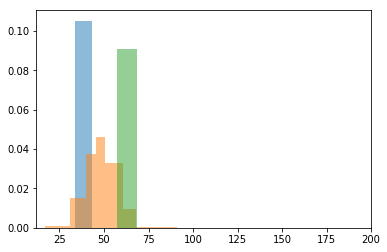

[ 0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0]
0 1 1 24.5
1 -1 0 33.5
-1 0 0 43
[    0   986  3565   404   297  3622 -5427 -1517 -1925    -5     0     0
     0     0     0     0]
0 986 1 12
986 3565 1 17
3565 404 0.875 31
404 297 1 40
297 3622 1 45.5
3622 -5427 0 50.5
-5427 -1517 0.333333333333 60.5
-1517 -1925 0 68
-1925 -5 0.0025974025974 91
-5 0 0 102.5
[ 0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 47
1 -1 0 57.5
-1 0 0 68.5
[ 0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0]
0 1 1 24.5
1 -1 0 33.5
-1 0 0 43
[    0   840  3677   644   337  3642 -5849 -1739 -1551    -1     0     0
     0     0     0     0]
0 840 1 12
840 3677 1 17
3677 644 0.8 31
644 337 1 40
337 3642 1 45.5
3642 -5849 0 50.5
-5849 -1739 0.333333333333 60.5
-1739 -1551 0 68
-1551 -1 0.000644745325596 91
-1 0 0 102.5
[ 0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 47
1 -1 0 57.5
-1 0 0 68.5
[ 0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0]
0 1 1 24.5
1 -1 0 33.5
-1 0 0 43
[    0   684  3787   918   

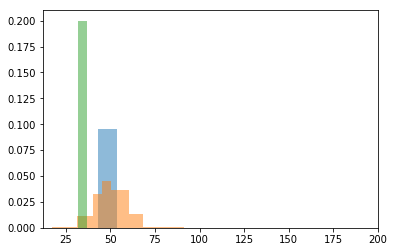

[ 0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0]
0 1 1 33.5
1 -1 0 43
-1 0 0 53.5
[    0   585  2894   885   589  4564 -5231 -1488 -2780   -18     0     0
     0     0     0     0]
0 585 1 12
585 2894 1 17
2894 885 0.666666666667 31
885 589 1 40
589 4564 1 45.5
4564 -5231 0 50.5
-5231 -1488 0.333333333333 60.5
-1488 -2780 0 68
-2780 -18 0.00649350649351 91
-18 0 0 102.5
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 32
-1 0 0 37
[ 0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0]
0 1 1 33.5
1 -1 0 43
-1 0 0 53.5
[    0   489  2924  1135   686  4622 -5767 -1725 -2357    -7     0     0
     0     0     0     0]
0 489 1 12
489 2924 1 17
2924 1135 0.5 31
1135 686 1 40
686 4622 1 45.5
4622 -5767 0 50.5
-5767 -1725 0.333333333333 60.5
-1725 -2357 0 68
-2357 -7 0.00297619047619 91
-7 0 0 102.5
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 32
-1 0 0 37
[ 0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0]
0 1 1 33.5
1 -1 0 43
-1 0 0 53.5
[    0   401  2924  1423   805  4594 -62

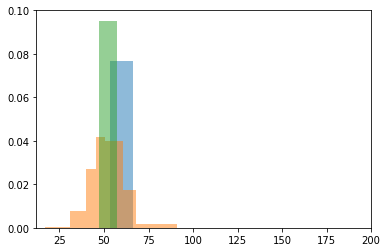

[ 0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0]
0 1 1 53.5
1 -1 0 66.5
-1 0 0 81.5
[    0   384  2187  1055   835  5387 -4577 -1480 -3747   -40    -4     0
     0     0     0     0]
0 384 1 12
384 2187 1 17
2187 1055 0.5 31
1055 835 1 40
835 5387 1 45.5
5387 -4577 0.25 50.5
-4577 -1480 0.333333333333 60.5
-1480 -3747 0 68
-3747 -40 0.010752688172 91
-40 -4 0.1 102.5
-4 0 0 133
[ 0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 37
1 -1 0 47
-1 0 0 57.5
[ 0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0]
0 1 1 53.5
1 -1 0 66.5
-1 0 0 81.5
[    0   316  2189  1274   978  5461 -5007 -2022 -3164   -25     0     0
     0     0     0     0]
0 316 1 12
316 2189 1 17
2189 1274 1 31
1274 978 1 40
978 5461 1 45.5
5461 -5007 0.25 50.5
-5007 -2022 0.5 60.5
-2022 -3164 0 68
-3164 -25 0.00793650793651 91
-25 0 0 102.5
[ 0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 37
1 -1 0 47
-1 0 0 57.5
[ 0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0]
0 1 1 53.5
1 -1 0 66.5
-1 0 0 81.5
[    0   250  

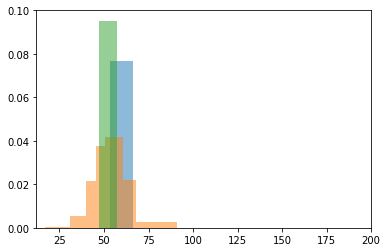

[ 0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0]
0 1 1 43
1 -1 0 53.5
-1 0 0 66.5
[    0   229  1644  1027  1057  5820 -3816  -748 -5129   -78    -6     0
     0     0     0     0]
0 229 1 12
229 1644 1 17
1644 1027 1 31
1027 1057 1 40
1057 5820 1 45.5
5820 -3816 0.25 50.5
-3816 -748 0.2 60.5
-748 -5129 0 68
-5129 -78 0.0153846153846 91
-78 -6 0.0769230769231 102.5
-6 0 0 133
[ 0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 37
1 -1 0 47
-1 0 0 57.5
[ 0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0]
0 1 1 43
1 -1 0 53.5
-1 0 0 66.5
[    0   177  1656  1172  1215  6083 -4433 -1325 -4502   -39    -4     0
     0     0     0     0]
0 177 1 12
177 1656 1 17
1656 1172 1 31
1172 1215 1 40
1215 6083 1 45.5
6083 -4433 0.25 50.5
-4433 -1325 0.333333333333 60.5
-1325 -4502 0 68
-4502 -39 0.00869565217391 91
-39 -4 0.111111111111 102.5
-4 0 0 133
[ 0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 37
1 -1 0 47
-1 0 0 57.5
[ 0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0]
0 1 1 43
1 -1 0

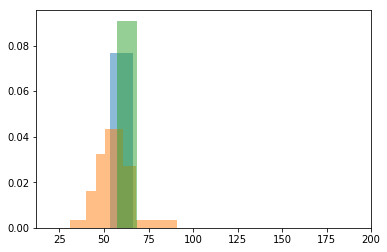

[ 0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0]
0 1 1 43
1 -1 0 53.5
-1 0 0 66.5
[    0   135  1082  1009  1164  6082 -2694  -142 -6502  -122   -12     0
     0     0     0     0]
0 135 1 12
135 1082 1 17
1082 1009 1 31
1009 1164 1 40
1164 6082 1 45.5
6082 -2694 0.166666666667 50.5
-2694 -142 0.0555555555556 60.5
-142 -6502 0 68
-6502 -122 0.0188679245283 91
-122 -12 0.1 102.5
-12 0 0 133
[ 0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 47
1 -1 0 57.5
-1 0 0 68.5
[ 0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0]
0 1 1 43
1 -1 0 53.5
-1 0 0 66.5
[    0   109  1058  1145  1315  6430 -3244  -979 -5758   -71    -5     0
     0     0     0     0]
0 109 1 12
109 1058 1 17
1058 1145 1 31
1145 1315 1 40
1315 6430 1 45.5
6430 -3244 0.25 50.5
-3244 -979 0.333333333333 60.5
-979 -5758 0 68
-5758 -71 0.0123456790123 91
-71 -5 0.0714285714286 102.5
-5 0 0 133
[ 0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 47
1 -1 0 57.5
-1 0 0 68.5
[ 0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0]

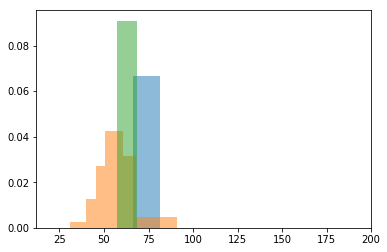

[ 0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0]
0 1 1 53.5
1 -1 0 66.5
-1 0 0 81.5
[    0    67   799   840  1077  6007 -1719  1400 -8242  -212   -17     0
     0     0     0     0]
0 67 1 12
67 799 1 17
799 840 1 31
840 1077 1 40
1077 6007 1 45.5
6007 -1719 0.125 50.5
-1719 1400 0.5 60.5
1400 -8242 0 68
-8242 -212 0.0263157894737 91
-212 -17 0.0833333333333 102.5
-17 0 0 133
[ 0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0]
0 1 1 57.5
1 -1 0 68.5
-1 0 0 80
[ 0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0]
0 1 1 53.5
1 -1 0 66.5
-1 0 0 81.5
[    0    59   756   964  1205  6434 -2141   242 -7378  -133    -8     0
     0     0     0     0]
0 59 1 12
59 756 1 17
756 964 1 31
964 1205 1 40
1205 6434 1 45.5
6434 -2141 0.125 50.5
-2141 242 0.111111111111 60.5
242 -7378 0 68
-7378 -133 0.0181818181818 91
-133 -8 0.0625 102.5
-8 0 0 133
[ 0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0]
0 1 1 57.5
1 -1 0 68.5
-1 0 0 80
[ 0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0]
0 1 1 53.5
1 -1 0 66.5
-

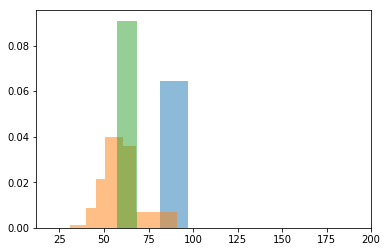

[ 0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0]
0 1 1 81.5
1 -1 0 97
-1 0 0 113
[     0     36    490    702   1013   5423   -327   3187 -10111   -382
    -31      0      0      0      0      0]
0 36 1 12
36 490 1 17
490 702 1 31
702 1013 1 40
1013 5423 1 45.5
5423 -327 0.0294117647059 50.5
-327 3187 0 60.5
3187 -10111 0 68
-10111 -382 0.0384615384615 91
-382 -31 0.0833333333333 102.5
-31 0 0 133
[ 0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0]
0 1 1 57.5
1 -1 0 68.5
-1 0 0 80
[ 0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0]
0 1 1 81.5
1 -1 0 97
-1 0 0 113
[    0    31   465   776  1132  5946  -612  1723 -9229  -216   -16     0
     0     0     0     0]
0 31 1 12
31 465 1 17
465 776 1 31
776 1132 1 40
1132 5946 1 45.5
5946 -612 0.05 50.5
-612 1723 0 60.5
1723 -9229 0 68
-9229 -216 0.0238095238095 91
-216 -16 0.0769230769231 102.5
-16 0 0 133
[ 0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0]
0 1 1 57.5
1 -1 0 68.5
-1 0 0 80
[ 0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0]
0 1 1 66.

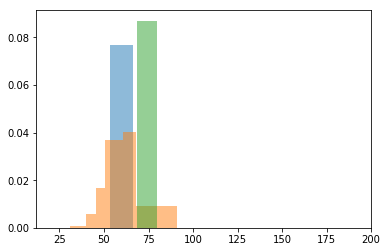

[ 0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0]
0 1 1 43
1 -1 0 53.5
-1 0 0 66.5
[     0     17    269    556    757   5251    368   5270 -11854   -568
    -66      0      0      0      0      0]
0 17 1 12
17 269 1 17
269 556 1 31
556 757 1 40
757 5251 1 45.5
5251 368 0.928571428571 50.5
368 5270 1 60.5
5270 -11854 0 68
-11854 -568 0.05 91
-568 -66 0.125 102.5
-66 0 0 133
[ 0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0]
0 1 1 68.5
1 -1 0 80
-1 0 0 91.5
[ 0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0]
0 1 1 43
1 -1 0 53.5
-1 0 0 66.5
[     0     14    259    588    875   5741    163   3923 -11159   -372
    -32      0      0      0      0      0]
0 14 1 12
14 259 1 17
259 588 1 31
588 875 1 40
875 5741 1 45.5
5741 163 0.971428571429 50.5
163 3923 1 60.5
3923 -11159 0 68
-11159 -372 0.0344827586207 91
-372 -32 0.0909090909091 102.5
-32 0 0 133
[ 0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0]
0 1 1 68.5
1 -1 0 80
-1 0 0 91.5
[ 0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0]
0 1 1 43


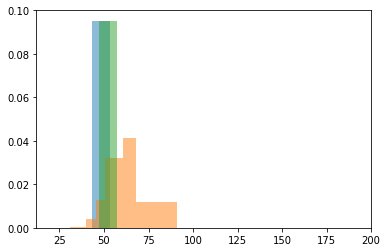

[ 0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0]
0 1 1 33.5
1 -1 0 43
-1 0 0 53.5
[     0      9    185    364    669   4420   1035   7828 -13463   -921
   -126      0      0      0      0      0]
0 9 1 12
9 185 1 17
185 364 1 31
364 669 1 40
669 4420 1 45.5
4420 1035 0.75 50.5
1035 7828 1 60.5
7828 -13463 0 68
-13463 -921 0.0714285714286 91
-921 -126 0.142857142857 102.5
-126 0 0 133
[ 0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 37
1 -1 0 47
-1 0 0 57.5
[ 0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0]
0 1 1 33.5
1 -1 0 43
-1 0 0 53.5
[     0      6    176    395    743   4929    965   6498 -13025   -634
    -53      0      0      0      0      0]
0 6 1 12
6 176 1 17
176 395 1 31
395 743 1 40
743 4929 1 45.5
4929 965 0.8 50.5
965 6498 1 60.5
6498 -13025 0 68
-13025 -634 0.05 91
-634 -53 0.0909090909091 102.5
-53 0 0 133
[ 0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 37
1 -1 0 47
-1 0 0 57.5
[ 0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0]
0 1 1 33.5
1 -1 0 43
-1 0

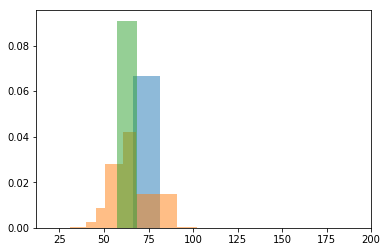

[ 0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0]
0 1 1 53.5
1 -1 0 66.5
-1 0 0 81.5
[     0      5     88    274    448   3706   1794   9905 -14741  -1294
   -185      0      0      0      0      0]
0 5 1 12
5 88 1 17
88 274 1 31
274 448 1 40
448 3706 1 45.5
3706 1794 0.5 50.5
1794 9905 1 60.5
9905 -14741 0 68
-14741 -1294 0.0909090909091 91
-1294 -185 0.166666666667 102.5
-185 0 0 133
[ 0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 47
1 -1 0 57.5
-1 0 0 68.5
[ 0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0]
0 1 1 53.5
1 -1 0 66.5
-1 0 0 81.5
[     0      3     86    287    509   4151   1829   8776 -14635   -907
    -99      0      0      0      0      0]
0 3 1 12
3 86 1 17
86 287 1 31
287 509 1 40
509 4151 1 45.5
4151 1829 0.5 50.5
1829 8776 1 60.5
8776 -14635 0 68
-14635 -907 0.0625 91
-907 -99 0.111111111111 102.5
-99 0 0 133
[ 0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 47
1 -1 0 57.5
-1 0 0 68.5
[ 0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0]
0 1 1 53.5
1 -1 0

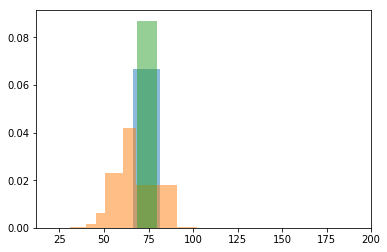

[ 0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0]
0 1 1 66.5
1 -1 0 81.5
-1 0 0 97
[     0      1     64    157    339   2891   2125  12135 -15644  -1726
   -342      0      0      0      0      0]
0 1 1 12
1 64 1 17
64 157 1 31
157 339 1 40
339 2891 1 45.5
2891 2125 1 50.5
2125 12135 1 60.5
12135 -15644 0 68
-15644 -1726 0.111111111111 91
-1726 -342 0.2 102.5
-342 0 0 133
[ 0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0]
0 1 1 57.5
1 -1 0 68.5
-1 0 0 80
[ 0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0]
0 1 1 66.5
1 -1 0 81.5
-1 0 0 97
[     0      1     62    164    384   3300   2328  11053 -15819  -1290
   -183      0      0      0      0      0]
0 1 1 12
1 62 1 17
62 164 1 31
164 384 1 40
384 3300 1 45.5
3300 2328 1 50.5
2328 11053 1 60.5
11053 -15819 0 68
-15819 -1290 0.0833333333333 91
-1290 -183 0.142857142857 102.5
-183 0 0 133
[ 0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0]
0 1 1 57.5
1 -1 0 68.5
-1 0 0 80
[ 0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0]
0 1 1 53.5
1 -1 0 66

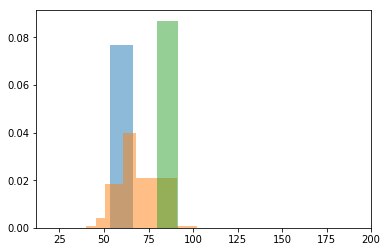

[ 0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0]
0 1 1 53.5
1 -1 0 66.5
-1 0 0 81.5
[     0      0     40     78    246   2194   2187  13930 -15773  -2304
   -598      0      0      0      0      0]
0 40 1 17
40 78 1 31
78 246 1 40
246 2194 1 45.5
2194 2187 1 50.5
2187 13930 1 60.5
13930 -15773 0 68
-15773 -2304 0.166666666667 91
-2304 -598 0.333333333333 102.5
-598 0 0 133
[ 0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0]
0 1 1 80
1 -1 0 91.5
-1 0 0 104
[ 0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0]
0 1 1 53.5
1 -1 0 66.5
-1 0 0 81.5
[     0      0     35     92    264   2550   2388  13375 -16562  -1811
   -331      0      0      0      0      0]
0 35 1 17
35 92 1 31
92 264 1 40
264 2550 1 45.5
2550 2388 1 50.5
2388 13375 1 60.5
13375 -16562 0 68
-16562 -1811 0.111111111111 91
-1811 -331 0.2 102.5
-331 0 0 133
[ 0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0]
0 1 1 80
1 -1 0 91.5
-1 0 0 104
[ 0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0]
0 1 1 53.5
1 -1 0 66.5
-1 0 0 81.5
[     

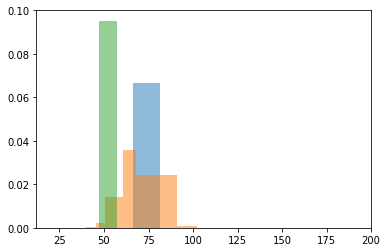

[ 0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0]
0 1 1 53.5
1 -1 0 66.5
-1 0 0 81.5
[     0      0     14     61    144   1668   1982  15285 -15231  -3064
   -859      0      0      0      0      0]
0 14 1 17
14 61 1 31
61 144 1 40
144 1668 1 45.5
1668 1982 1 50.5
1982 15285 1 60.5
15285 -15231 0.25 68
-15231 -3064 0.25 91
-3064 -859 0.333333333333 102.5
-859 0 0 133
[ 0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 47
1 -1 0 57.5
-1 0 0 68.5
[ 0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0]
0 1 1 53.5
1 -1 0 66.5
-1 0 0 81.5
[     0      0     14     61    168   1929   2317  15015 -16468  -2569
   -467      0      0      0      0      0]
0 14 1 17
14 61 1 31
61 168 1 40
168 1929 1 45.5
1929 2317 1 50.5
2317 15015 1 60.5
15015 -16468 0 68
-16468 -2569 0.166666666667 91
-2569 -467 0.2 102.5
-467 0 0 133
[ 0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 47
1 -1 0 57.5
-1 0 0 68.5
[ 0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0]
0 1 1 53.5
1 -1 0 66.5
-1 0 0 81.5
[     0    

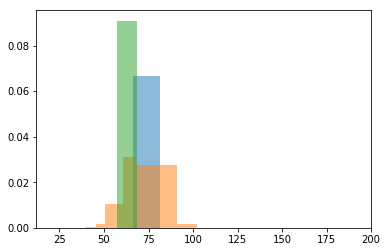

[ 0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0]
0 1 1 66.5
1 -1 0 81.5
-1 0 0 97
[     0      0      7     39    103   1125   1756  16082 -14075  -3692
  -1345      0      0      0      0      0]
0 7 1 17
7 39 1 31
39 103 1 40
103 1125 1 45.5
1125 1756 1 50.5
1756 16082 1 60.5
16082 -14075 0.25 68
-14075 -3692 0.333333333333 91
-3692 -1345 0.5 102.5
-1345 0 0 133
[ 0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 47
1 -1 0 57.5
-1 0 0 68.5
[ 0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0]
0 1 1 66.5
1 -1 0 81.5
-1 0 0 97
[     0      0      7     39    117   1340   2048  16435 -15994  -3240
   -752      0      0      0      0      0]
0 7 1 17
7 39 1 31
39 117 1 40
117 1340 1 45.5
1340 2048 1 50.5
2048 16435 1 60.5
16435 -15994 0.25 68
-15994 -3240 0.25 91
-3240 -752 0.25 102.5
-752 0 0 133
[ 0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 47
1 -1 0 57.5
-1 0 0 68.5
[ 0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0]
0 1 1 66.5
1 -1 0 81.5
-1 0 0 97
[     0      0      7     

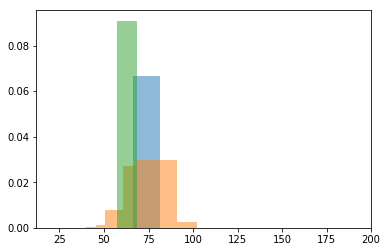

[ 0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0]
0 1 1 53.5
1 -1 0 66.5
-1 0 0 81.5
[     0      0      3     20     63    803   1470  16090 -12280  -4147
  -2022      0      0      0      0      0]
0 3 1 17
3 20 1 31
20 63 1 40
63 803 1 45.5
803 1470 1 50.5
1470 16090 1 60.5
16090 -12280 0.25 68
-12280 -4147 0.5 91
-4147 -2022 0.5 102.5
-2022 0 0 133
[ 0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0]
0 1 1 57.5
1 -1 0 68.5
-1 0 0 80
[ 0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0]
0 1 1 53.5
1 -1 0 66.5
-1 0 0 81.5
[     0      0      3     20     75    954   1729  16891 -14518  -3937
  -1217      0      0      0      0      0]
0 3 1 17
3 20 1 31
20 75 1 40
75 954 1 45.5
954 1729 1 50.5
1729 16891 1 60.5
16891 -14518 0.25 68
-14518 -3937 0.333333333333 91
-3937 -1217 0.333333333333 102.5
-1217 0 0 133
[ 0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0]
0 1 1 57.5
1 -1 0 68.5
-1 0 0 80
[ 0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0]
0 1 1 53.5
1 -1 0 66.5
-1 0 0 81.5
[     0      0   

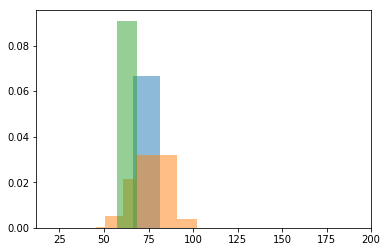

[ 0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0]
0 1 1 53.5
1 -1 0 66.5
-1 0 0 81.5
[     0      0      2      6     35    486   1166  15742 -10046  -4500
  -2887     -4      0      0      0      0]
0 2 1 17
2 6 1 31
6 35 1 40
35 486 1 45.5
486 1166 1 50.5
1166 15742 1 60.5
15742 -10046 0.25 68
-10046 -4500 0.5 91
-4500 -2887 0 102.5
-2887 -4 0.00138696255201 133
-4 0 0 148
[ 0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0]
0 1 1 57.5
1 -1 0 68.5
-1 0 0 80
[ 0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0]
0 1 1 53.5
1 -1 0 66.5
-1 0 0 81.5
[     0      0      2      6     38    579   1417  17090 -12811  -4497
  -1824      0      0      0      0      0]
0 2 1 17
2 6 1 31
6 38 1 40
38 579 1 45.5
579 1417 1 50.5
1417 17090 1 60.5
17090 -12811 0.25 68
-12811 -4497 0.5 91
-4497 -1824 0.5 102.5
-1824 0 0 133
[ 0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0]
0 1 1 57.5
1 -1 0 68.5
-1 0 0 80
[ 0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0]
0 1 1 53.5
1 -1 0 66.5
-1 0 0 81.5
[     0      0    

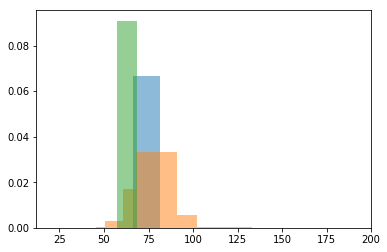

[ 0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0]
0 1 1 53.5
1 -1 0 66.5
-1 0 0 81.5
[    0     0     1     5    15   305   786 14806 -7429 -4373 -4105   -11
     0     0     0     0]
0 1 1 17
1 5 1 31
5 15 1 40
15 305 1 45.5
305 786 1 50.5
786 14806 1 60.5
14806 -7429 0.25 68
-7429 -4373 0 91
-4373 -4105 0 102.5
-4105 -11 0.00268096514745 133
-11 0 0 148
[ 0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0]
0 1 1 57.5
1 -1 0 68.5
-1 0 0 80
[ 0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0]
0 1 1 53.5
1 -1 0 66.5
-1 0 0 81.5
[     0      0      1      5     21    352   1032  16467 -10237  -4986
  -2653     -2      0      0      0      0]
0 1 1 17
1 5 1 31
5 21 1 40
21 352 1 45.5
352 1032 1 50.5
1032 16467 1 60.5
16467 -10237 0.25 68
-10237 -4986 0.5 91
-4986 -2653 0 102.5
-2653 -2 0.000754147812971 133
-2 0 0 148
[ 0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0]
0 1 1 57.5
1 -1 0 68.5
-1 0 0 80
[ 0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0]
0 1 1 53.5
1 -1 0 66.5
-1 0 0 81.5
[     0     

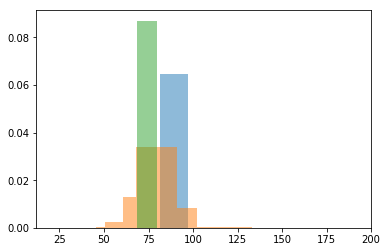

[ 0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0]
0 1 1 81.5
1 -1 0 97
-1 0 0 113
[    0     0     1     3     6   202   649 13088 -4466 -4027 -5433   -22
    -1     0     0     0]
0 1 1 17
1 3 1 31
3 6 1 40
6 202 1 45.5
202 649 1 50.5
649 13088 1 60.5
13088 -4466 0.166666666667 68
-4466 -4027 0 91
-4027 -5433 0 102.5
-5433 -22 0.00406504065041 133
-22 -1 0.0454545454545 148
-1 0 0 163
[ 0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0]
0 1 1 68.5
1 -1 0 80
-1 0 0 91.5
[ 0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0]
0 1 1 81.5
1 -1 0 97
-1 0 0 113
[    0     0     1     3     9   250   786 15109 -7401 -5007 -3745    -5
     0     0     0     0]
0 1 1 17
1 3 1 31
3 9 1 40
9 250 1 45.5
250 786 1 50.5
786 15109 1 60.5
15109 -7401 0.166666666667 68
-7401 -5007 0 91
-5007 -3745 0 102.5
-3745 -5 0.00133511348465 133
-5 0 0 148
[ 0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0]
0 1 1 68.5
1 -1 0 80
-1 0 0 91.5
[ 0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0]
0 1 1 81.5
1 -1 0 97
-1 0 0 113
[ 

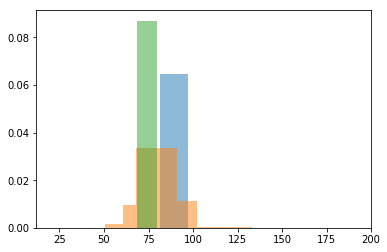

[ 0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0]
0 1 1 97
1 -1 0 113
-1 0 0 131.5
[    0     0     0     3     5   127   404 11577 -2092 -2878 -7118   -27
    -1     0     0     0]
0 3 1 31
3 5 1 40
5 127 1 45.5
127 404 1 50.5
404 11577 1 60.5
11577 -2092 0.0833333333333 68
-2092 -2878 0 91
-2878 -7118 0 102.5
-7118 -27 0.00380228136882 133
-27 -1 0.037037037037 148
-1 0 0 163
[ 0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0]
0 1 1 68.5
1 -1 0 80
-1 0 0 91.5
[ 0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0]
0 1 1 81.5
1 -1 0 97
-1 0 0 113
[    0     0     0     3     5   155   536 13630 -4581 -4703 -5040    -5
     0     0     0     0]
0 3 1 31
3 5 1 40
5 155 1 45.5
155 536 1 50.5
536 13630 1 60.5
13630 -4581 0.166666666667 68
-4581 -4703 0 91
-4703 -5040 0 102.5
-5040 -5 0.000992063492063 133
-5 0 0 148
[ 0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0]
0 1 1 68.5
1 -1 0 80
-1 0 0 91.5
[ 0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0]
0 1 1 81.5
1 -1 0 97
-1 0 0 113
[    0     0     0

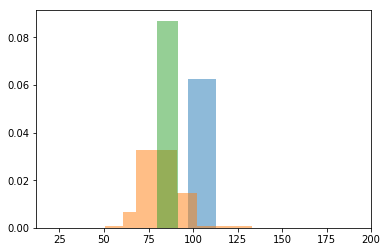

[ 0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0]
0 1 1 97
1 -1 0 113
-1 0 0 131.5
[    0     0     0     0     2    66   249  9988    43 -1445 -8847   -55
    -1     0     0     0]
0 2 1 40
2 66 1 45.5
66 249 1 50.5
249 9988 1 60.5
9988 43 0.995689655172 68
43 -1445 0 91
-1445 -8847 0 102.5
-8847 -55 0.00625 133
-55 -1 0.0181818181818 148
-1 0 0 163
[ 0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0]
0 1 1 91.5
1 -1 0 104
-1 0 0 117
[ 0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0]
0 1 1 97
1 -1 0 113
-1 0 0 131.5
[    0     0     0     0     4    77   347 11960 -1878 -3935 -6561   -14
     0     0     0     0]
0 4 1 40
4 77 1 45.5
77 347 1 50.5
347 11960 1 60.5
11960 -1878 0.0714285714286 68
-1878 -3935 0 91
-3935 -6561 0 102.5
-6561 -14 0.00213675213675 133
-14 0 0 148
[ 0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0]
0 1 1 80
1 -1 0 91.5
-1 0 0 104
[ 0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0]
0 1 1 97
1 -1 0 113
-1 0 0 131.5
[    0     0     0     0     4    98   466 14319 -4949

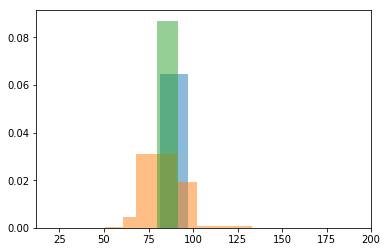

[ 0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0]
0 1 1 81.5
1 -1 0 97
-1 0 0 113
[     0      0      0      0      0     31    148   7996   2060   1039
 -11170   -102     -2      0      0      0]
0 31 1 45.5
31 148 1 50.5
148 7996 1 60.5
7996 2060 0.666666666667 68
2060 1039 1 91
1039 -11170 0 102.5
-11170 -102 0.00917431192661 133
-102 -2 0.0196078431373 148
-2 0 0 163
[ 0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0]
0 1 1 91.5
1 -1 0 104
-1 0 0 117
[ 0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0]
0 1 1 81.5
1 -1 0 97
-1 0 0 113
[    0     0     0     0     0    38   213  9973   618 -2224 -8591   -27
     0     0     0     0]
0 38 1 45.5
38 213 1 50.5
213 9973 1 60.5
9973 618 0.9375 68
618 -2224 0 91
-2224 -8591 0 102.5
-8591 -27 0.00314465408805 133
-27 0 0 148
[ 0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0]
0 1 1 80
1 -1 0 91.5
-1 0 0 104
[ 0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0]
0 1 1 81.5
1 -1 0 97
-1 0 0 113
[    0     0     0     0     1    44   317 12291 -1726 -491

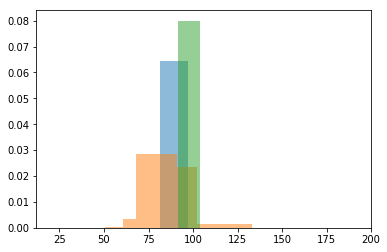

[ 0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0]
0 1 1 81.5
1 -1 0 97
-1 0 0 113
[     0      0      0      0      2     19    101   6318   3283   3798
 -13354   -163     -4      0      0      0]
0 2 1 40
2 19 1 45.5
19 101 1 50.5
101 6318 1 60.5
6318 3283 1 68
3283 3798 1 91
3798 -13354 0 102.5
-13354 -163 0.0123456790123 133
-163 -4 0.025 148
-4 0 0 163
[ 0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0]
0 1 1 91.5
1 -1 0 104
-1 0 0 117
[ 0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0]
0 1 1 81.5
1 -1 0 97
-1 0 0 113
[     0      0      0      0      2     24    146   8102   2491    -51
 -10667    -47      0      0      0      0]
0 2 1 40
2 24 1 45.5
24 146 1 50.5
146 8102 1 60.5
8102 2491 0.666666666667 68
2491 -51 0.0102040816327 91
-51 -10667 0 102.5
-10667 -47 0.00442477876106 133
-47 0 0 148
[ 0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0]
0 1 1 91.5
1 -1 0 104
-1 0 0 117
[ 0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0]
0 1 1 66.5
1 -1 0 81.5
-1 0 0 97
[    0     0     0     0 

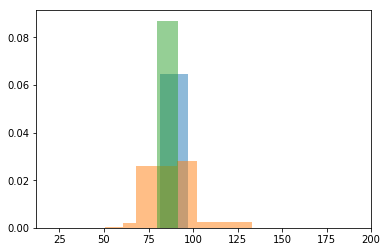

[ 0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0]
0 1 1 97
1 -1 0 113
-1 0 0 131.5
[     0      0      0      0      0      5     74   4747   4214   6676
 -15390   -318     -8      0      0      0]
0 5 1 45.5
5 74 1 50.5
74 4747 1 60.5
4747 4214 1 68
4214 6676 1 91
6676 -15390 0 102.5
-15390 -318 0.0208333333333 133
-318 -8 0.025641025641 148
-8 0 0 163
[ 0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0]
0 1 1 80
1 -1 0 91.5
-1 0 0 104
[ 0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0]
0 1 1 81.5
1 -1 0 97
-1 0 0 113
[     0      0      0      0      0      7    105   6297   3972   2595
 -12863   -111     -2      0      0      0]
0 7 1 45.5
7 105 1 50.5
105 6297 1 60.5
6297 3972 1 68
3972 2595 1 91
2595 -12863 0 102.5
-12863 -111 0.00869565217391 133
-111 -2 0.0181818181818 148
-2 0 0 163
[ 0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0]
0 1 1 80
1 -1 0 91.5
-1 0 0 104
[ 0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0]
0 1 1 81.5
1 -1 0 97
-1 0 0 113
[    0     0     0     0     0    14   

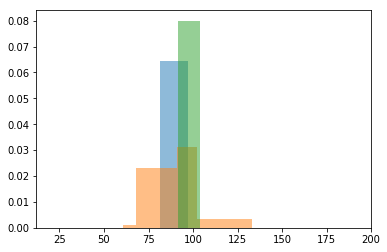

[ 0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0]
0 1 1 66.5
1 -1 0 81.5
-1 0 0 97
[     0      0      0      0      1      8     27   3531   4657   9413
 -17132   -484    -21      0      0      0]
0 1 1 40
1 8 1 45.5
8 27 1 50.5
27 3531 1 60.5
3531 4657 1 68
4657 9413 1 91
9413 -17132 0 102.5
-17132 -484 0.0285714285714 133
-484 -21 0.0434782608696 148
-21 0 0 163
[ 0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0]
0 1 1 91.5
1 -1 0 104
-1 0 0 117
[ 0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0]
0 1 1 66.5
1 -1 0 81.5
-1 0 0 97
[     0      0      0      0      1      8     39   4865   4902   5199
 -14817   -194     -3      0      0      0]
0 1 1 40
1 8 1 45.5
8 39 1 50.5
39 4865 1 60.5
4865 4902 1 68
4902 5199 1 91
5199 -14817 0 102.5
-14817 -194 0.0131578947368 133
-194 -3 0.015625 148
-3 0 0 163
[ 0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0]
0 1 1 91.5
1 -1 0 104
-1 0 0 117
[ 0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0]
0 1 1 66.5
1 -1 0 81.5
-1 0 0 97
[     0      0      0   

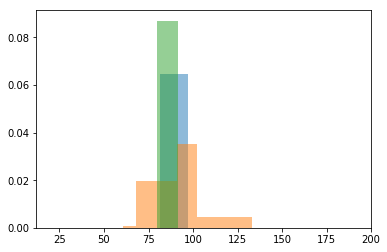

[ 0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0]
0 1 1 97
1 -1 0 113
-1 0 0 131.5
[     0      0      0      0      0      5     19   2504   4488  12520
 -18681   -820    -34     -1      0      0]
0 5 1 45.5
5 19 1 50.5
19 2504 1 60.5
2504 4488 1 68
4488 12520 1 91
12520 -18681 0 102.5
-18681 -820 0.0454545454545 133
-820 -34 0.0416666666667 148
-34 -1 0.0294117647059 163
-1 0 0 196
[ 0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0]
0 1 1 80
1 -1 0 91.5
-1 0 0 104
[ 0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0]
0 1 1 81.5
1 -1 0 97
-1 0 0 113
[     0      0      0      0      0      5     24   3566   5144   8523
 -16902   -350    -10      0      0      0]
0 5 1 45.5
5 24 1 50.5
24 3566 1 60.5
3566 5144 1 68
5144 8523 1 91
8523 -16902 0 102.5
-16902 -350 0.0208333333333 133
-350 -10 0.0285714285714 148
-10 0 0 163
[ 0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0]
0 1 1 80
1 -1 0 91.5
-1 0 0 104
[ 0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0]
0 1 1 81.5
1 -1 0 97
-1 0 0 113
[     0  

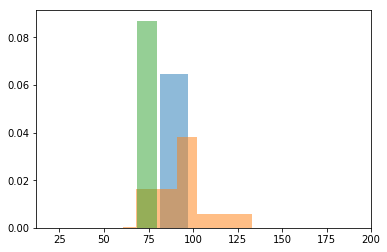

[ 0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0]
0 1 1 81.5
1 -1 0 97
-1 0 0 113
[     0      0      0      0      0      0      8   1744   4024  15329
 -19807  -1241    -53     -4      0      0]
0 8 1 50.5
8 1744 1 60.5
1744 4024 1 68
4024 15329 1 91
15329 -19807 0 102.5
-19807 -1241 0.0666666666667 133
-1241 -53 0.0434782608696 148
-53 -4 0.0769230769231 163
-4 0 0 196
[ 0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0]
0 1 1 57.5
1 -1 0 68.5
-1 0 0 80
[ 0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0]
0 1 1 81.5
1 -1 0 97
-1 0 0 113
[     0      0      0      0      0      1      9   2520   5001  11787
 -18724   -579    -14     -1      0      0]
0 1 1 45.5
1 9 1 50.5
9 2520 1 60.5
2520 5001 1 68
5001 11787 1 91
11787 -18724 0 102.5
-18724 -579 0.03125 133
-579 -14 0.0243902439024 148
-14 -1 0.0714285714286 163
-1 0 0 196
[ 0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0]
0 1 1 57.5
1 -1 0 68.5
-1 0 0 80
[ 0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0]
0 1 1 66.5
1 -1 0 81.5
-1 0 0 97


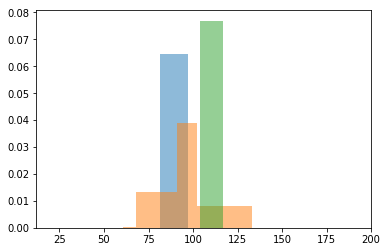

[ 0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0]
0 1 1 97
1 -1 0 113
-1 0 0 131.5
[     0      0      0      0      0      0      2   1124   3494  17555
 -20217  -1845   -107     -6      0      0]
0 2 1 50.5
2 1124 1 60.5
1124 3494 1 68
3494 17555 1 91
17555 -20217 0 102.5
-20217 -1845 0.1 133
-1845 -107 0.0588235294118 148
-107 -6 0.0588235294118 163
-6 0 0 196
[ 0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0]
0 1 1 104
1 -1 0 117
-1 0 0 131
[ 0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0]
0 1 1 81.5
1 -1 0 97
-1 0 0 113
[     0      0      0      0      0      0      3   1745   4552  14678
 -20036   -913    -29      0      0      0]
0 3 1 50.5
3 1745 1 60.5
1745 4552 1 68
4552 14678 1 91
14678 -20036 0 102.5
-20036 -913 0.047619047619 133
-913 -29 0.0322580645161 148
-29 0 0 163
[ 0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0]
0 1 1 104
1 -1 0 117
-1 0 0 131
[ 0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0]
0 1 1 81.5
1 -1 0 97
-1 0 0 113
[     0      0      0      0      0      0

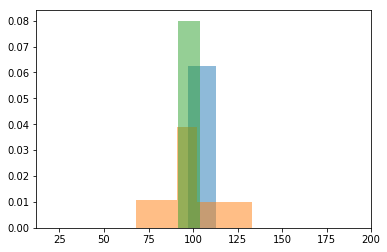

[ 0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0]
0 1 1 97
1 -1 0 113
-1 0 0 131.5
[     0      0      0      0      0      0      1    731   2925  19079
 -20063  -2475   -195     -3      0      0]
0 1 1 50.5
1 731 1 60.5
731 2925 1 68
2925 19079 1 91
19079 -20063 0 102.5
-20063 -2475 0.125 133
-2475 -195 0.0833333333333 148
-195 -3 0.0153846153846 163
-3 0 0 196
[ 0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0]
0 1 1 91.5
1 -1 0 104
-1 0 0 117
[ 0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0]
0 1 1 97
1 -1 0 113
-1 0 0 131.5
[     0      0      0      0      0      0      2   1172   3936  17224
 -21022  -1245    -66     -1      0      0]
0 2 1 50.5
2 1172 1 60.5
1172 3936 1 68
3936 17224 1 91
17224 -21022 0 102.5
-21022 -1245 0.0625 133
-1245 -66 0.0555555555556 148
-66 -1 0.0151515151515 163
-1 0 0 196
[ 0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0]
0 1 1 91.5
1 -1 0 104
-1 0 0 117
[ 0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0]
0 1 1 81.5
1 -1 0 97
-1 0 0 113
[     0      0     

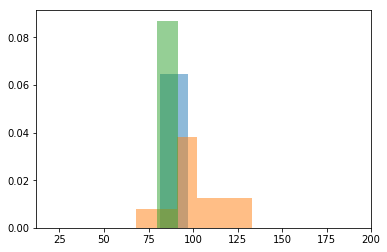

[ 0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0]
0 1 1 97
1 -1 0 113
-1 0 0 131.5
[     0      0      0      0      0      0      1    474   2142  20233
 -19157  -3341   -340    -12      0      0]
0 1 1 50.5
1 474 1 60.5
474 2142 1 68
2142 20233 1 91
20233 -19157 0.25 102.5
-19157 -3341 0.2 133
-3341 -340 0.111111111111 148
-340 -12 0.0357142857143 163
-12 0 0 196
[ 0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0]
0 1 1 80
1 -1 0 91.5
-1 0 0 104
[ 0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0]
0 1 1 81.5
1 -1 0 97
-1 0 0 113
[     0      0      0      0      0      0      1    755   3073  19478
 -21303  -1903    -99     -2      0      0]
0 1 1 50.5
1 755 1 60.5
755 3073 1 68
3073 19478 1 91
19478 -21303 0 102.5
-21303 -1903 0.0909090909091 133
-1903 -99 0.0526315789474 148
-99 -2 0.0204081632653 163
-2 0 0 196
[ 0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0]
0 1 1 80
1 -1 0 91.5
-1 0 0 104
[ 0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0]
0 1 1 81.5
1 -1 0 97
-1 0 0 113
[     0      

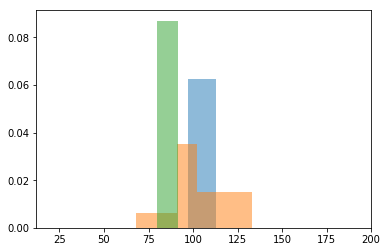

[ 0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0]
0 1 1 97
1 -1 0 113
-1 0 0 131.5
[     0      0      0      0      0      0      1    241   1590  20613
 -17566  -4295   -567    -17      0      0]
0 1 1 50.5
1 241 1 60.5
241 1590 1 68
1590 20613 1 91
20613 -17566 0.25 102.5
-17566 -4295 0.25 133
-4295 -567 0.142857142857 148
-567 -17 0.030303030303 163
-17 0 0 196
[ 0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0]
0 1 1 80
1 -1 0 91.5
-1 0 0 104
[ 0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0]
0 1 1 97
1 -1 0 113
-1 0 0 131.5
[     0      0      0      0      0      0      1    415   2547  20636
 -20781  -2616   -201     -1      0      0]
0 1 1 50.5
1 415 1 60.5
415 2547 1 68
2547 20636 1 91
20636 -20781 0 102.5
-20781 -2616 0.142857142857 133
-2616 -201 0.0769230769231 148
-201 -1 0.00497512437811 163
-1 0 0 196
[ 0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0]
0 1 1 80
1 -1 0 91.5
-1 0 0 104
[ 0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0]
0 1 1 97
1 -1 0 113
-1 0 0 131.5
[     0  

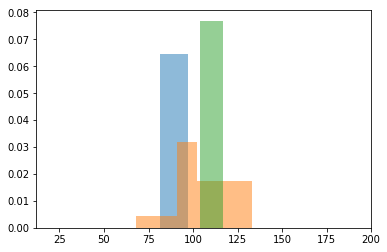

[ 0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0]
0 1 1 97
1 -1 0 113
-1 0 0 131.5
[     0      0      0      0      0      0      0    161   1131  20094
 -15194  -5266   -883    -43      0      0]
0 161 1 60.5
161 1131 1 68
1131 20094 1 91
20094 -15194 0.25 102.5
-15194 -5266 0.5 133
-5266 -883 0.2 148
-883 -43 0.05 163
-43 0 0 196
[ 0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0]
0 1 1 104
1 -1 0 117
-1 0 0 131
[ 0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0]
0 1 1 81.5
1 -1 0 97
-1 0 0 113
[     0      0      0      0      0      0      0    273   1850  21293
 -19570  -3515   -320    -11      0      0]
0 273 1 60.5
273 1850 1 68
1850 21293 1 91
21293 -19570 0.25 102.5
-19570 -3515 0.2 133
-3515 -320 0.1 148
-320 -11 0.0344827586207 163
-11 0 0 196
[ 0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0]
0 1 1 104
1 -1 0 117
-1 0 0 131
[ 0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0]
0 1 1 81.5
1 -1 0 97
-1 0 0 113
[     0      0      0      0      0      0      0    481   2914  20689
 -2

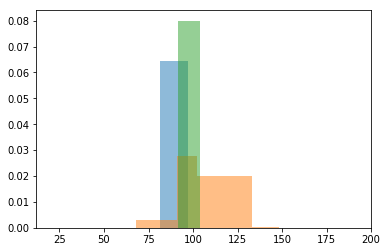

[ 0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0]
0 1 1 97
1 -1 0 113
-1 0 0 131.5
[     0      0      0      0      0      0      0     96    744  19074
 -12214  -6325  -1300    -75      0      0]
0 96 1 60.5
96 744 1 68
744 19074 1 91
19074 -12214 0.25 102.5
-12214 -6325 0 133
-6325 -1300 0.25 148
-1300 -75 0.0588235294118 163
-75 0 0 196
[ 0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0]
0 1 1 104
1 -1 0 117
-1 0 0 131
[ 0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0]
0 1 1 81.5
1 -1 0 97
-1 0 0 113
[     0      0      0      0      0      0      0    161   1293  21325
 -17771  -4422   -574    -12      0      0]
0 161 1 60.5
161 1293 1 68
1293 21325 1 91
21325 -17771 0.25 102.5
-17771 -4422 0.25 133
-4422 -574 0.142857142857 148
-574 -12 0.0212765957447 163
-12 0 0 196
[ 0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0]
0 1 1 104
1 -1 0 117
-1 0 0 131
[ 0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0]
0 1 1 81.5
1 -1 0 97
-1 0 0 113
[     0      0      0      0      0      0      0    2

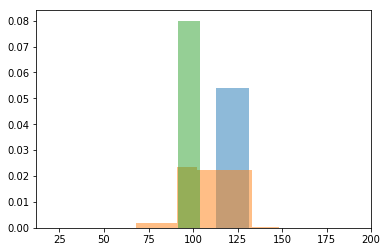

[ 0  0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0]
0 1 1 113
1 -1 0 131.5
-1 0 0 151.5
[    0     0     0     0     0     0     0    35   514 17472 -8763 -7246
 -1887  -125     0     0]
0 35 1 60.5
35 514 1 68
514 17472 1 91
17472 -8763 0.25 102.5
-8763 -7246 0 133
-7246 -1887 0.333333333333 148
-1887 -125 0.0666666666667 163
-125 0 0 196
[ 0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0]
0 1 1 104
1 -1 0 117
-1 0 0 131
[ 0  0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0]
0 1 1 113
1 -1 0 131.5
-1 0 0 151.5
[     0      0      0      0      0      0      0     69    896  20576
 -15013  -5661   -837    -30      0      0]
0 69 1 60.5
69 896 1 68
896 20576 1 91
20576 -15013 0.25 102.5
-15013 -5661 0.5 133
-5661 -837 0.166666666667 148
-837 -30 0.037037037037 163
-30 0 0 196
[ 0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0]
0 1 1 91.5
1 -1 0 104
-1 0 0 117
[ 0  0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0]
0 1 1 113
1 -1 0 131.5
-1 0 0 151.5
[     0      0      0      0      0      0      0    1

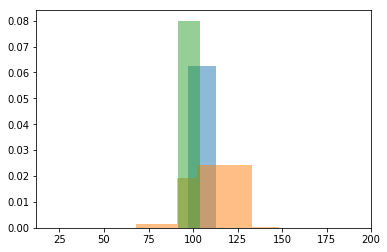

[ 0  0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0]
0 1 1 113
1 -1 0 131.5
-1 0 0 151.5
[    0     0     0     0     0     0     0    19   332 15819 -5781 -7542
 -2623  -224     0     0]
0 19 1 60.5
19 332 1 68
332 15819 1 91
15819 -5781 0.166666666667 102.5
-5781 -7542 0 133
-7542 -2623 0.5 148
-2623 -224 0.0909090909091 163
-224 0 0 196
[ 0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0]
0 1 1 104
1 -1 0 117
-1 0 0 131
[ 0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0]
0 1 1 97
1 -1 0 113
-1 0 0 131.5
[     0      0      0      0      0      0      0     46    595  19362
 -12010  -6728  -1213    -52      0      0]
0 46 1 60.5
46 595 1 68
595 19362 1 91
19362 -12010 0.25 102.5
-12010 -6728 0 133
-6728 -1213 0.2 148
-1213 -52 0.0434782608696 163
-52 0 0 196
[ 0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0]
0 1 1 104
1 -1 0 117
-1 0 0 131
[ 0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0]
0 1 1 97
1 -1 0 113
-1 0 0 131.5
[     0      0      0      0      0      0      0    106   1039  22171
 

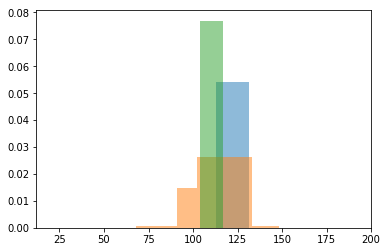

[ 0  0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0]
0 1 1 113
1 -1 0 131.5
-1 0 0 151.5
[    0     0     0     0     0     0     0    13   177 13545 -2015 -7768
 -3562  -390     0     0]
0 13 1 60.5
13 177 1 68
177 13545 1 91
13545 -2015 0.0714285714286 102.5
-2015 -7768 0 133
-7768 -3562 0.5 148
-3562 -390 0.111111111111 163
-390 0 0 196
[ 0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0]
0 1 1 117
1 -1 0 131
-1 0 0 145
[ 0  0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0]
0 1 1 113
1 -1 0 131.5
-1 0 0 151.5
[    0     0     0     0     0     0     0    22   355 17428 -8085 -7743
 -1878   -99     0     0]
0 22 1 60.5
22 355 1 68
355 17428 1 91
17428 -8085 0.166666666667 102.5
-8085 -7743 0 133
-7743 -1878 0.25 148
-1878 -99 0.0555555555556 163
-99 0 0 196
[ 0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0]
0 1 1 117
1 -1 0 131
-1 0 0 145
[ 0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0]
0 1 1 97
1 -1 0 113
-1 0 0 131.5
[     0      0      0      0      0      0      0     49    687  21124
 -152

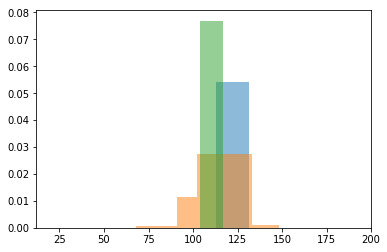

[ 0  0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0]
0 1 1 113
1 -1 0 131.5
-1 0 0 151.5
[    0     0     0     0     0     0     0     6   106 11554   762 -7275
 -4518  -635     0     0]
0 6 1 60.5
6 106 1 68
106 11554 1 91
11554 762 0.933333333333 102.5
762 -7275 0 133
-7275 -4518 0 148
-4518 -635 0.142857142857 163
-635 0 0 196
[ 0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0]
0 1 1 104
1 -1 0 117
-1 0 0 131
[ 0  0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0]
0 1 1 113
1 -1 0 131.5
-1 0 0 151.5
[    0     0     0     0     0     0     0    10   223 15646 -4881 -8301
 -2514  -183     0     0]
0 10 1 60.5
10 223 1 68
223 15646 1 91
15646 -4881 0.125 102.5
-4881 -8301 0 133
-8301 -2514 0.333333333333 148
-2514 -183 0.0769230769231 163
-183 0 0 196
[ 0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0]
0 1 1 104
1 -1 0 117
-1 0 0 131
[ 0  0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0]
0 1 1 113
1 -1 0 131.5
-1 0 0 151.5
[     0      0      0      0      0      0      0     21    461  19823
 -12221 

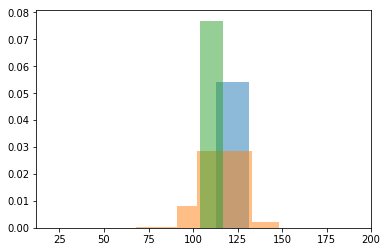

[ 0  0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0]
0 1 1 113
1 -1 0 131.5
-1 0 0 151.5
[    0     0     0     0     0     0     0     5    62  9175  3823 -6520
 -5470 -1074    -1     0]
0 5 1 60.5
5 62 1 68
62 9175 1 91
9175 3823 0.5 102.5
3823 -6520 0 133
-6520 -5470 0 148
-5470 -1074 0.2 163
-1074 -1 0.000931098696462 196
-1 0 0 220
[ 0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0]
0 1 1 117
1 -1 0 131
-1 0 0 145
[ 0  0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0]
0 1 1 113
1 -1 0 131.5
-1 0 0 151.5
[    0     0     0     0     0     0     0     8   143 13323 -1224 -8442
 -3499  -309     0     0]
0 8 1 60.5
8 143 1 68
143 13323 1 91
13323 -1224 0.0454545454545 102.5
-1224 -8442 0 133
-8442 -3499 0.5 148
-3499 -309 0.0909090909091 163
-309 0 0 196
[ 0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0]
0 1 1 104
1 -1 0 117
-1 0 0 131
[ 0  0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0]
0 1 1 113
1 -1 0 131.5
-1 0 0 151.5
[    0     0     0     0     0     0     0    13   268 17909 -8417 -8096
 -1

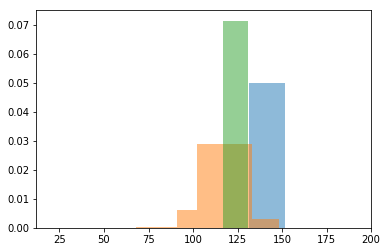

[ 0  0  0  0  0  0  0  0  0  0  0  0  1 -1  0  0]
0 1 1 131.5
1 -1 0 151.5
-1 0 0 173
[    0     0     0     0     0     0     0     4    34  7528  5369 -4988
 -6437 -1510     0     0]
0 4 1 60.5
4 34 1 68
34 7528 1 91
7528 5369 1 102.5
5369 -4988 0.25 133
-4988 -6437 0 148
-6437 -1510 0.25 163
-1510 0 0 196
[ 0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0]
0 1 1 131
1 -1 0 145
-1 0 0 163.5
[ 0  0  0  0  0  0  0  0  0  0  0  0  1 -1  0  0]
0 1 1 131.5
1 -1 0 151.5
-1 0 0 173
[    0     0     0     0     0     0     0     6    81 11440  1506 -8169
 -4381  -483     0     0]
0 6 1 60.5
6 81 1 68
81 11440 1 91
11440 1506 0.857142857143 102.5
1506 -8169 0 133
-8169 -4381 0 148
-4381 -483 0.111111111111 163
-483 0 0 196
[ 0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0]
0 1 1 131
1 -1 0 145
-1 0 0 163.5
[ 0  0  0  0  0  0  0  0  0  0  0  0  1 -1  0  0]
0 1 1 131.5
1 -1 0 151.5
-1 0 0 173
[    0     0     0     0     0     0     0     9   163 16168 -5284 -8753
 -2183  -120     0     0]
0 9 1 6

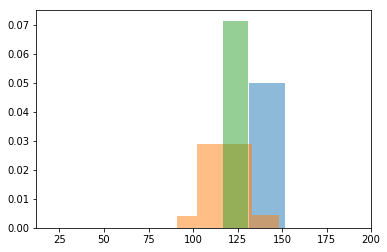

[ 0  0  0  0  0  0  0  0  0  0  0  0  1 -1  0  0]
0 1 1 131.5
1 -1 0 151.5
-1 0 0 173
[    0     0     0     0     0     0     0     1    19  5722  6827 -3215
 -7040 -2314     0     0]
0 1 1 60.5
1 19 1 68
19 5722 1 91
5722 6827 1 102.5
6827 -3215 0.166666666667 133
-3215 -7040 0 148
-7040 -2314 0.333333333333 163
-2314 0 0 196
[ 0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0]
0 1 1 131
1 -1 0 145
-1 0 0 163.5
[ 0  0  0  0  0  0  0  0  0  0  0  0  1 -1  0  0]
0 1 1 131.5
1 -1 0 151.5
-1 0 0 173
[    0     0     0     0     0     0     0     2    37  9181  4483 -7459
 -5452  -792     0     0]
0 2 1 60.5
2 37 1 68
37 9181 1 91
9181 4483 0.5 102.5
4483 -7459 0 133
-7459 -5452 0 148
-5452 -792 0.166666666667 163
-792 0 0 196
[ 0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0]
0 1 1 117
1 -1 0 131
-1 0 0 145
[ 0  0  0  0  0  0  0  0  0  0  0  0  1 -1  0  0]
0 1 1 131.5
1 -1 0 151.5
-1 0 0 173
[    0     0     0     0     0     0     0     2    96 13838 -1442 -9193
 -3132  -169     0     0]
0 

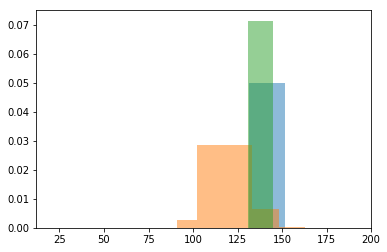

[ 0  0  0  0  0  0  0  0  0  0  0  0  1 -1  0  0]
0 1 1 131.5
1 -1 0 151.5
-1 0 0 173
[    0     0     0     0     0     0     0     0     7  4263  7413  -939
 -7449 -3294    -1     0]
0 7 1 68
7 4263 1 91
4263 7413 1 102.5
7413 -939 0.0625 133
-939 -7449 0 148
-7449 -3294 0.5 163
-3294 -1 0.000303582270795 196
-1 0 0 220
[ 0  0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0]
0 1 1 145
1 -1 0 163.5
-1 0 0 183.5
[ 0  0  0  0  0  0  0  0  0  0  0  0  1 -1  0  0]
0 1 1 131.5
1 -1 0 151.5
-1 0 0 173
[    0     0     0     0     0     0     0     0    17  7305  6254 -5767
 -6533 -1276     0     0]
0 17 1 68
17 7305 1 91
7305 6254 1 102.5
6254 -5767 0.25 133
-5767 -6533 0 148
-6533 -1276 0.2 163
-1276 0 0 196
[ 0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0]
0 1 1 131
1 -1 0 145
-1 0 0 163.5
[ 0  0  0  0  0  0  0  0  0  0  0  0  1 -1  0  0]
0 1 1 131.5
1 -1 0 151.5
-1 0 0 173
[    0     0     0     0     0     0     0     0    43 11627  1833 -9074
 -4074  -355     0     0]
0 43 1 68
43 11627 1 91

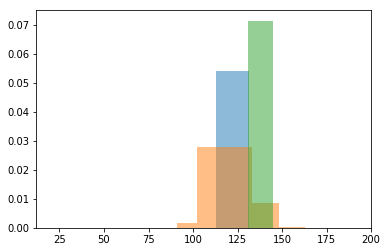

[ 0  0  0  0  0  0  0  0  0  0  0  0  1 -1  0  0]
0 1 1 131.5
1 -1 0 151.5
-1 0 0 173
[    0     0     0     0     0     0     0     0     3  2947  7835  1045
 -7402 -4424    -4     0]
0 3 1 68
3 2947 1 91
2947 7835 1 102.5
7835 1045 0.857142857143 133
1045 -7402 0 148
-7402 -4424 0 163
-4424 -4 0.000904159132007 196
-4 0 0 220
[ 0  0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0]
0 1 1 145
1 -1 0 163.5
-1 0 0 183.5
[ 0  0  0  0  0  0  0  0  0  0  0  0  1 -1  0  0]
0 1 1 131.5
1 -1 0 151.5
-1 0 0 173
[    0     0     0     0     0     0     0     0     9  5487  7836 -4038
 -7425 -1869     0     0]
0 9 1 68
9 5487 1 91
5487 7836 1 102.5
7836 -4038 0.25 133
-4038 -7425 0 148
-7425 -1869 0.333333333333 163
-1869 0 0 196
[ 0  0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0]
0 1 1 145
1 -1 0 163.5
-1 0 0 183.5
[ 0  0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0]
0 1 1 113
1 -1 0 131.5
-1 0 0 151.5
[    0     0     0     0     0     0     0     1    18  9482  4739 -8579
 -5083  -578     0     0]
0 1 1 

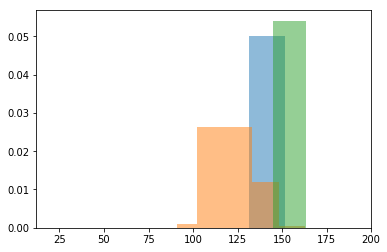

[ 0  0  0  0  0  0  0  0  0  0  0  0  1 -1  0  0]
0 1 1 131.5
1 -1 0 151.5
-1 0 0 173
[    0     0     0     0     0     0     0     0     2  2164  6854  3683
 -6600 -6097    -6     0]
0 2 1 68
2 2164 1 91
2164 6854 1 102.5
6854 3683 1 133
3683 -6600 0 148
-6600 -6097 0 163
-6097 -6 0.000984251968504 196
-6 0 0 220
[ 0  0  0  0  0  0  0  0  0  0  0  0  1 -1  0  0]
0 1 1 163.5
1 -1 0 183.5
-1 0 0 207.5
[ 0  0  0  0  0  0  0  0  0  0  0  0  1 -1  0  0]
0 1 1 131.5
1 -1 0 151.5
-1 0 0 173
[    0     0     0     0     0     0     0     0    10  4098  8082 -1304
 -8080 -2806     0     0]
0 10 1 68
10 4098 1 91
4098 8082 1 102.5
8082 -1304 0.0714285714286 133
-1304 -8080 0 148
-8080 -2806 0.5 163
-2806 0 0 196
[ 0  0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0]
0 1 1 145
1 -1 0 163.5
-1 0 0 183.5
[ 0  0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0]
0 1 1 113
1 -1 0 131.5
-1 0 0 151.5
[    0     0     0     0     0     0     0     0    12  7420  6855 -6956
 -6393  -938     0     0]
0 12 1 68
12 74

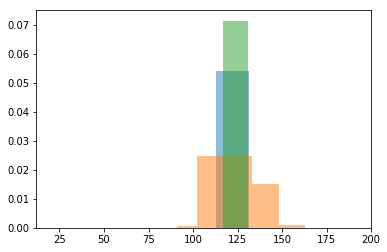

[ 0  0  0  0  0  0  0  0  0  0  0  0  1 -1  0  0]
0 1 1 131.5
1 -1 0 151.5
-1 0 0 173
[    0     0     0     0     0     0     0     0     0  1445  6291  5255
 -5185 -7784   -22     0]
0 1445 1 91
1445 6291 1 102.5
6291 5255 1 133
5255 -5185 0.25 148
-5185 -7784 0 163
-7784 -22 0.0028328611898 196
-22 0 0 220
[ 0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0]
0 1 1 131
1 -1 0 145
-1 0 0 163.5
[ 0  0  0  0  0  0  0  0  0  0  0  0  1 -1  0  0]
0 1 1 131.5
1 -1 0 151.5
-1 0 0 173
[    0     0     0     0     0     0     0     0     0  2953  8211   873
 -8194 -3840    -3     0]
0 2953 1 91
2953 8211 1 102.5
8211 873 0.888888888889 133
873 -8194 0 148
-8194 -3840 0.5 163
-3840 -3 0.00078125 196
-3 0 0 220
[ 0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0]
0 1 1 131
1 -1 0 145
-1 0 0 163.5
[ 0  0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0]
0 1 1 113
1 -1 0 131.5
-1 0 0 151.5
[    0     0     0     0     0     0     0     0     7  5677  8283 -5056
 -7481 -1429    -1     0]
0 7 1 68
7 5677 1 91
5

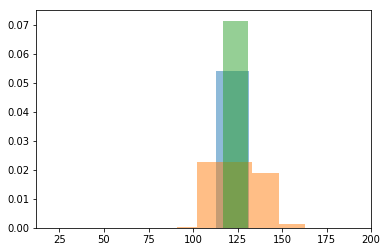

[ 0  0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0]
0 1 1 113
1 -1 0 131.5
-1 0 0 151.5
[    0     0     0     0     0     0     0     0     1   909  5325  6834
 -3335 -9683   -51     0]
0 1 1 68
1 909 1 91
909 5325 1 102.5
5325 6834 1 133
6834 -3335 0.166666666667 148
-3335 -9683 0 163
-9683 -51 0.00529100529101 196
-51 0 0 220
[ 0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0]
0 1 1 117
1 -1 0 131
-1 0 0 145
[ 0  0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0]
0 1 1 113
1 -1 0 131.5
-1 0 0 151.5
[    0     0     0     0     0     0     0     0     2  2005  7824  3124
 -7756 -5193    -6     0]
0 2 1 68
2 2005 1 91
2005 7824 1 102.5
7824 3124 0.5 133
3124 -7756 0 148
-7756 -5193 0 163
-5193 -6 0.00115606936416 196
-6 0 0 220
[ 0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0]
0 1 1 117
1 -1 0 131
-1 0 0 145
[ 0  0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0]
0 1 1 113
1 -1 0 131.5
-1 0 0 151.5
[    0     0     0     0     0     0     0     0     4  4252  9037 -2934
 -8271 -2088     0     0]
0 4 

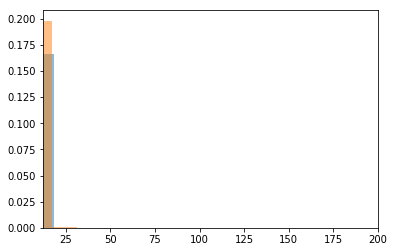

[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 3773 -3748   -25     0     0     0     0     0     0     0     0     0
     0     0     0     0]
3773 -3748 0.5 12
-3748 -25 0.00671140939597 17
-25 0 0 31
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 5324 -5283   -41     0     0     0     0     0     0     0     0     0
     0     0     0     0]
5324 -5283 0.5 12
-5283 -41 0.0078125 17
-41 0 0 31
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 7444 -7382   -62     0     0     0     0     0     0     0     0     0
     0     0     0     0]
7444 -7382 0.5 12
-7382 -62 0.00840336134454 17
-62 0 0 31
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 10195 -10103    -92      0      0      0      0      0      0      0
      0      0      0      0      0      0]
10195 -10103 0.5 12
-10103 -92 0.009

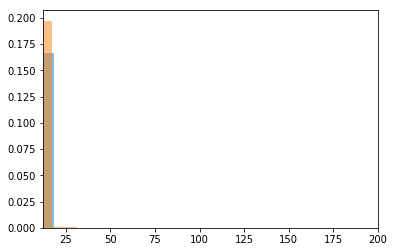

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 4393 -4342   -51     0     0     0     0     0     0     0     0     0
     0     0     0     0]
4393 -4342 0.5 12
-4342 -51 0.0117647058824 17
-51 0 0 31
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 6059 -5989   -70     0     0     0     0     0     0     0     0     0
     0     0     0     0]
6059 -5989 0.5 12
-5989 -70 0.0117647058824 17
-70 0 0 31
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 8334 -8228  -106     0     0     0     0     0     0     0     0     0
     0     0     0     0]
8334 -8228 0.5 12
-8228 -106 0.012987012987 17
-106 0 0 31
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 11188 -11036   -152      0      0      0      0      0      0      0
      0      0      0      0      0      0]
11188 -11036 0.5 12
-11036 -152 0.0138888888889 17
-152 0 0 31
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 14746 

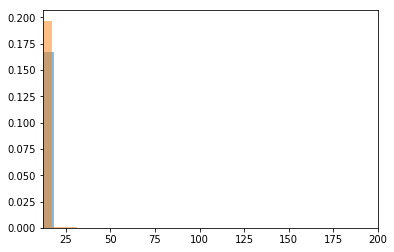

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 5055 -4995   -60     0     0     0     0     0     0     0     0     0
     0     0     0     0]
5055 -4995 0.5 12
-4995 -60 0.0120481927711 17
-60 0 0 31
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 6914 -6830   -84     0     0     0     0     0     0     0     0     0
     0     0     0     0]
6914 -6830 0.5 12
-6830 -84 0.0123456790123 17
-84 0 0 31
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 9281 -9154  -127     0     0     0     0     0     0     0     0     0
     0     0     0     0]
9281 -9154 0.5 12
-9154 -127 0.0138888888889 17
-127 0 0 31
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 12410 -12224   -186      0      0      0      0      0      0      0
      0      0      0      0      0      0]
12410 -12224 0.5 12
-12224 -186 0.0153846153846 17
-186 0 0 31
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 15904

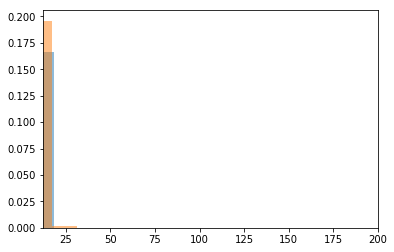

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 5894 -5799   -94    -1     0     0     0     0     0     0     0     0
     0     0     0     0]
5894 -5799 0.5 12
-5799 -94 0.016393442623 17
-94 -1 0.0106382978723 31
-1 0 0 40
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 7839 -7725  -112    -2     0     0     0     0     0     0     0     0
     0     0     0     0]
7839 -7725 0.5 12
-7725 -112 0.0147058823529 17
-112 -2 0.0178571428571 31
-2 0 0 40
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 10378 -10211   -165     -2      0      0      0      0      0      0
      0      0      0      0      0      0]
10378 -10211 0.5 12
-10211 -165 0.016393442623 17
-165 -2 0.0121951219512 31
-2 0 0 40
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 13438 -13184   -252     -2      0      0      0      0      0      0
      0      0      0      0      0      0]
13438 -13184 0.5 12
-13184 -252 0.0192307692308 17
-252 -2 0.00793650793651 31
-

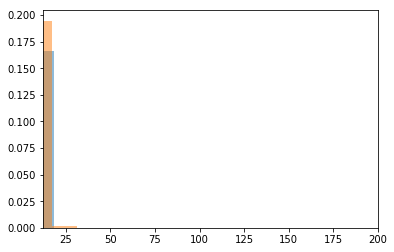

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 6658 -6564   -94     0     0     0     0     0     0     0     0     0
     0     0     0     0]
6658 -6564 0.5 12
-6564 -94 0.0144927536232 17
-94 0 0 31
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 8763 -8627  -136     0     0     0     0     0     0     0     0     0
     0     0     0     0]
8763 -8627 0.5 12
-8627 -136 0.015873015873 17
-136 0 0 31
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 11434 -11232   -202      0      0      0      0      0      0      0
      0      0      0      0      0      0]
11434 -11232 0.5 12
-11232 -202 0.0181818181818 17
-202 0 0 31
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 14452 -14149   -303      0      0      0      0      0      0      0
      0      0      0      0      0      0]
14452 -14149 0.5 12
-14149 -303 0.0217391304348 17
-303 0 0 31
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 17924 -17448   -475  

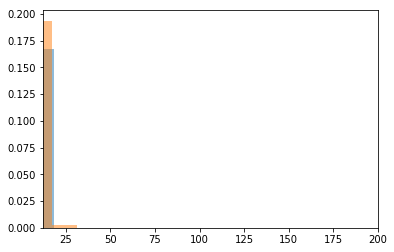

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 7391 -7248  -142    -1     0     0     0     0     0     0     0     0
     0     0     0     0]
7391 -7248 0.5 12
-7248 -142 0.0196078431373 17
-142 -1 0.00704225352113 31
-1 0 0 40
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 9706 -9503  -202    -1     0     0     0     0     0     0     0     0
     0     0     0     0]
9706 -9503 0.5 12
-9503 -202 0.0212765957447 17
-202 -1 0.0049504950495 31
-1 0 0 40
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 12423 -12122   -300     -1      0      0      0      0      0      0
      0      0      0      0      0      0]
12423 -12122 0.5 12
-12122 -300 0.025 17
-300 -1 0.00333333333333 31
-1 0 0 40
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 15582 -15161   -420     -1      0      0      0      0      0      0
      0      0      0      0      0      0]
15582 -15161

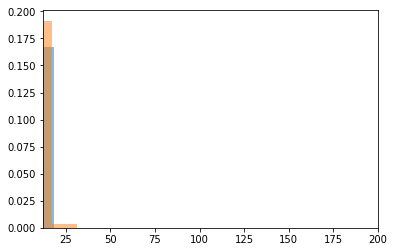

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 8572 -8372  -199    -1     0     0     0     0     0     0     0     0
     0     0     0     0]
8572 -8372 0.5 12
-8372 -199 0.0238095238095 17
-199 -1 0.00502512562814 31
-1 0 0 40
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 10848 -10586   -261     -1      0      0      0      0      0      0
      0      0      0      0      0      0]
10848 -10586 0.5 12
-10586 -261 0.025 17
-261 -1 0.00383141762452 31
-1 0 0 40
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 13642 -13255   -386     -1      0      0      0      0      0      0
      0      0      0      0      0      0]
13642 -13255 0.5 12
-13255 -386 0.0294117647059 17
-386 -1 0.00259067357513 31
-1 0 0 40
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 16726 -16163   -561     -2      0      0      0      0      0      0
      0      0      0      0      0      0]
16726 -16163 0.5 12
-16163 -561 0.0357142857143 17
-561 -2 0.003

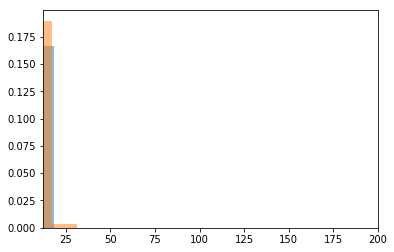

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 9531 -9263  -268     1    -1     0     0     0     0     0     0     0
     0     0     0     0]
9531 -9263 0.5 12
-9263 -268 0.0294117647059 17
-268 1 0.00373134328358 31
1 -1 0 40
-1 0 0 45.5
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 11926 -11553   -373      1     -1      0      0      0      0      0
      0      0      0      0      0      0]
11926 -11553 0.5 12
-11553 -373 0.0333333333333 17
-373 1 0.00268096514745 31
1 -1 0 40
-1 0 0 45.5
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 14686 -14189   -497      1     -1      0      0      0      0      0
      0      0      0      0      0      0]
14686 -14189 0.5 12
-14189 -497 0.0357142857143 17
-497 1 0.00201207243461 31
1 -1 0 40
-1 0 0 45.5
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 17625 -16918   -707      1     -1      0      0      0      0 

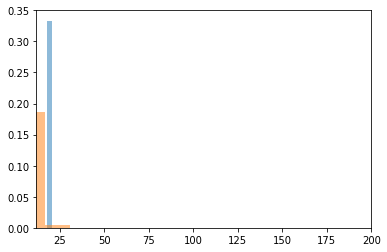

[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 10602 -10256   -345     -1      0      0      0      0      0      0
      0      0      0      0      0      0]
10602 -10256 0.5 12
-10256 -345 0.0344827586207 17
-345 -1 0.00289855072464 31
-1 0 0 40
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 12978 -12519   -457     -2      0      0      0      0      0      0
      0      0      0      0      0      0]
12978 -12519 0.5 12
-12519 -457 0.037037037037 17
-457 -2 0.00438596491228 31
-2 0 0 40
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 15705 -15053   -650     -2      0      0      0      0      0      0
      0      0      0      0      0      0]
15705 -15053 0.5 12
-15053 -650 0.0434782608696 17
-650 -2 0.00307692307692 31
-2 0 0 40
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 18616

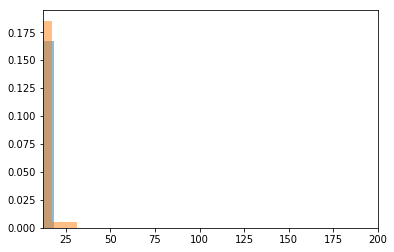

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 11549 -11129   -414     -6      0      0      0      0      0      0
      0      0      0      0      0      0]
11549 -11129 0.5 12
-11129 -414 0.0384615384615 17
-414 -6 0.0144927536232 31
-6 0 0 40
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 13965 -13393   -566     -6      0      0      0      0      0      0
      0      0      0      0      0      0]
13965 -13393 0.5 12
-13393 -566 0.0434782608696 17
-566 -6 0.0106382978723 31
-6 0 0 40
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 16655 -15870   -778     -7      0      0      0      0      0      0
      0      0      0      0      0      0]
16655 -15870 0.5 12
-15870 -778 0.05 17
-778 -7 0.00900900900901 31
-7 0 0 40
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 19517 -18437  -1070    -10      0      0      0      0      0      0
      0      0      0      0      0      0]
19517 -18437 0.5 12
-18437 -1070 0.0588235294118

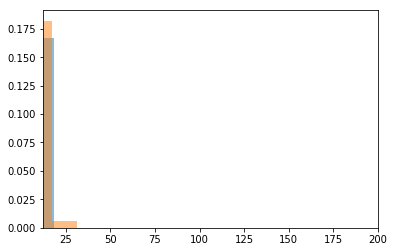

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 12661 -12165   -491     -5      0      0      0      0      0      0
      0      0      0      0      0      0]
12661 -12165 0.5 12
-12165 -491 0.0416666666667 17
-491 -5 0.0102040816327 31
-5 0 0 40
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 15054 -14367   -681     -6      0      0      0      0      0      0
      0      0      0      0      0      0]
15054 -14367 0.5 12
-14367 -681 0.047619047619 17
-681 -6 0.00884955752212 31
-6 0 0 40
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 17669 -16728   -935     -6      0      0      0      0      0      0
      0      0      0      0      0      0]
17669 -16728 0.5 12
-16728 -935 0.0588235294118 17
-935 -6 0.00645161290323 31
-6 0 0 40
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 20296 -19009  -1281     -6      0      0      0      0      0      0
      0      0      0      0      0      0]
20296 -19009 0.5 12
-19009 -1281 0.07

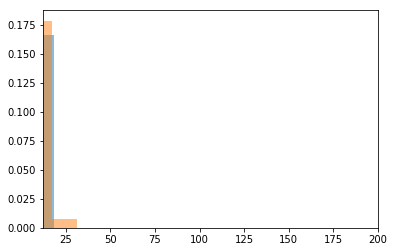

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 13537 -12825   -709     -1     -2      0      0      0      0      0
      0      0      0      0      0      0]
13537 -12825 0.5 12
-12825 -709 0.0555555555556 17
-709 -1 0.00141043723554 31
-1 -2 0 40
-2 0 0 45.5
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 15873 -14956   -914     -1     -2      0      0      0      0      0
      0      0      0      0      0      0]
15873 -14956 0.5 12
-14956 -914 0.0625 17
-914 -1 0.00109409190372 31
-1 -2 0 40
-2 0 0 45.5
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 18485 -17284  -1197     -2     -2      0      0      0      0      0
      0      0      0      0      0      0]
18485 -17284 0.5 12
-17284 -1197 0.0714285714286 17
-1197 -2 0.00167224080268 31
-2 -2 0 40
-2 0 0 45.5
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 20869 -19220  -1645     -2     -2      0    

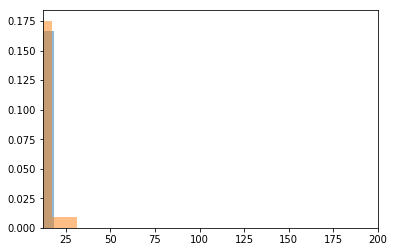

[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 14630 -13814   -809     -6      0     -1      0      0      0      0
      0      0      0      0      0      0]
14630 -13814 0.5 12
-13814 -809 0.0588235294118 17
-809 -6 0.00746268656716 31
-6 0 0 40
0 -1 0 45.5
-1 0 0 50.5
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 16954 -15873  -1073     -7      0     -1      0      0      0      0
      0      0      0      0      0      0]
16954 -15873 0.5 12
-15873 -1073 0.0714285714286 17
-1073 -7 0.00653594771242 31
-7 0 0 40
0 -1 0 45.5
-1 0 0 50.5
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 19369 -17946  -1412    -10      0     -1      0      0      0      0
      0      0      0      0      0      0]
19369 -17946 0.5 12
-17946 -1412 0.0833333333333 17
-1412 -10 0.00709219858156 31
-10 0 0 40
0 -1 0 45.5
-1 0 0 50.5
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

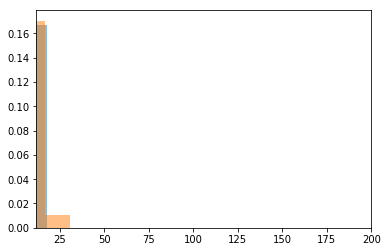

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 15557 -14443  -1099    -11     -4      0      0      0      0      0
      0      0      0      0      0      0]
15557 -14443 0.5 12
-14443 -1099 0.0769230769231 17
-1099 -11 0.010101010101 31
-11 -4 0.5 40
-4 0 0 45.5
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 17806 -16376  -1415    -10     -5      0      0      0      0      0
      0      0      0      0      0      0]
17806 -16376 0.5 12
-16376 -1415 0.0909090909091 17
-1415 -10 0.00709219858156 31
-10 -5 0.5 40
-5 0 0 45.5
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 19991 -18159  -1817    -10     -5      0      0      0      0      0
      0      0      0      0      0      0]
19991 -18159 0.5 12
-18159 -1817 0.111111111111 17
-1817 -10 0.00552486187845 31
-10 -5 0.5 40
-5 0 0 45.5
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 21826 -19397  -2409    -14     -6      0      0      0      0      0
      0      0      0    

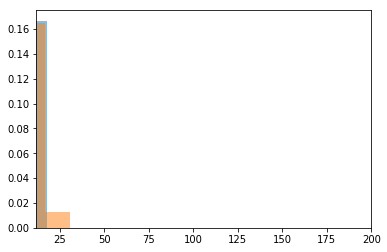

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 16394 -15015  -1363    -15      0      3     -4      0      0      0
      0      0      0      0      0      0]
16394 -15015 0.5 12
-15015 -1363 0.0909090909091 17
-1363 -15 0.0111111111111 31
-15 0 0 40
0 3 1 45.5
3 -4 0 50.5
-4 0 0 60.5
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 18619 -16879  -1722    -17      0      3     -4      0      0      0
      0      0      0      0      0      0]
18619 -16879 0.5 12
-16879 -1722 0.111111111111 17
-1722 -17 0.00990099009901 31
-17 0 0 40
0 3 1 45.5
3 -4 0 50.5
-4 0 0 60.5
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 20544 -18299  -2224    -20      1      1     -3      0      0      0
      0      0      0      0      0      0]
20544 -18299 0.5 12
-18299 -2224 0.125 17
-2224 -20 0.00900900900901 31
-20 1 0.05 40
1 1 1 45.5
1 -3 0 50.5
-3 0 0 60.5
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 2211

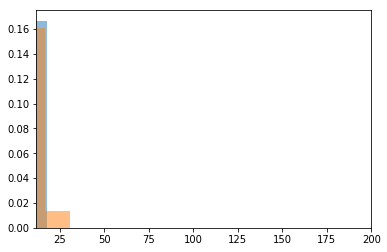

[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 17423 -15822  -1582    -19      0      1     -1      0      0      0
      0      0      0      0      0      0]
17423 -15822 0.5 12
-15822 -1582 0.1 17
-1582 -19 0.0120481927711 31
-19 0 0 40
0 1 1 45.5
1 -1 0 50.5
-1 0 0 60.5
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 19320 -17276  -2021    -23      0      1     -1      0      0      0
      0      0      0      0      0      0]
19320 -17276 0.5 12
-17276 -2021 0.125 17
-2021 -23 0.0114942528736 31
-23 0 0 40
0 1 1 45.5
1 -1 0 50.5
-1 0 0 60.5
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 21131 -18538  -2567    -26      0      1     -1      0      0      0
      0      0      0      0      0      0]
21131 -18538 0.5 12
-18538 -2567 0.142857142857 17
-2567 -26 0.0102040816327 31
-26 0 0 40
0 1 1 45.5
1 -1 0 50.5
-1 0 0 60.5
[0 0 0 0 0 0 0 0 0 

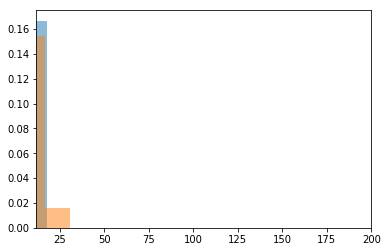

[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 17959 -15978  -1948    -28     -3     -2      1     -1      0      0
      0      0      0      0      0      0]
17959 -15978 0.5 12
-15978 -1948 0.125 17
-1948 -28 0.0144927536232 31
-28 -3 0.111111111111 40
-3 -2 0 45.5
-2 1 0.5 50.5
1 -1 0 60.5
-1 0 0 68
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 19683 -17187  -2456    -35     -3     -2      1     -1      0      0
      0      0      0      0      0      0]
19683 -17187 0.5 12
-17187 -2456 0.166666666667 17
-2456 -35 0.0142857142857 31
-35 -3 0.0909090909091 40
-3 -2 0 45.5
-2 1 0.5 50.5
1 -1 0 60.5
-1 0 0 68
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 21226 -18082  -3101    -38     -3     -2      1     -1      0      0
      0      0      0      0      0      0]
21226 -18082 0.5 12
-18082 -3101 0.2 17
-3101 -38 0.0123456790123 31
-38 -3 0

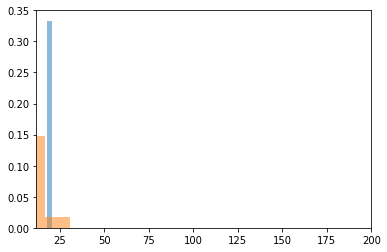

[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 18713 -16292  -2388    -24     -5     -4      0      0      0      0
      0      0      0      0      0      0]
18713 -16292 0.5 12
-16292 -2388 0.166666666667 17
-2388 -24 0.010101010101 31
-24 -5 0.25 40
-5 -4 0 45.5
-4 0 0 50.5
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 20287 -17282  -2968    -28     -5     -4      0      0      0      0
      0      0      0      0      0      0]
20287 -17282 0.5 12
-17282 -2968 0.2 17
-2968 -28 0.00943396226415 31
-28 -5 0.2 40
-5 -4 0 45.5
-4 0 0 50.5
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 21467 -17708  -3710    -40     -5     -4      0      0      0      0
      0      0      0      0      0      0]
21467 -17708 0.5 12
-17708 -3710 0.25 17
-3710 -40 0.0108695652174 31
-40 -5 0.125 40
-5 -4 0 45.5
-4 0 0 50.5
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0 

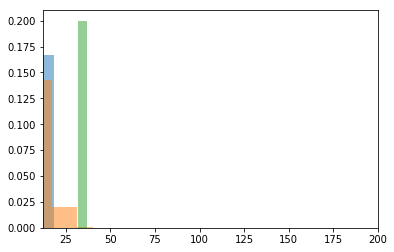

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 19194 -16378  -2764    -43     -7     -1     -1      0      0      0
      0      0      0      0      0      0]
19194 -16378 0.5 12
-16378 -2764 0.2 17
-2764 -43 0.015625 31
-43 -7 0.166666666667 40
-7 -1 0.142857142857 45.5
-1 -1 0 50.5
-1 0 0 60.5
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 20559 -17104  -3393    -53     -7     -1     -1      0      0      0
      0      0      0      0      0      0]
20559 -17104 0.5 12
-17104 -3393 0.2 17
-3393 -53 0.015625 31
-53 -7 0.142857142857 40
-7 -1 0.142857142857 45.5
-1 -1 0 50.5
-1 0 0 60.5
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 21520 -17237  -4207    -67     -7     -1     -1      0      0      0
      0      0      0      0      0      0]
21520 -17237 0.5 12
-17237 -4207 0.25 17
-4207 -67 0.0161290322581 31
-67 -7 0.111111111111 40
-7 -1 0.142857142857 45.5
-1 -1 0 50.5
-1 0 0 60.5
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 32
-1 

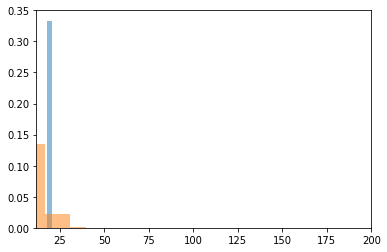

[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 19450 -16056  -3310    -65    -15     -1     -2     -1      0      0
      0      0      0      0      0      0]
19450 -16056 0.5 12
-16056 -3310 0.25 17
-3310 -65 0.02 31
-65 -15 0.25 40
-15 -1 0.0666666666667 45.5
-1 -2 0 50.5
-2 -1 0.5 60.5
-1 0 0 68
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 20558 -16456  -4008    -74    -17      0     -2     -1      0      0
      0      0      0      0      0      0]
20558 -16456 0.5 12
-16456 -4008 0.25 17
-4008 -74 0.0185185185185 31
-74 -17 0.25 40
-17 0 0 45.5
0 -2 0 50.5
-2 -1 0.5 60.5
-1 0 0 68
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 12
1 -1 0 18
-1 0 0 21
[ 21341 -16340  -4901    -80    -17      0     -2     -1      0      0
      0      0      0      0      0      0]
21341 -16340 0.5 12
-16340 -4901 0.333333333333 17
-4901 -80 0.016393442623 31
-80 -17 0.25

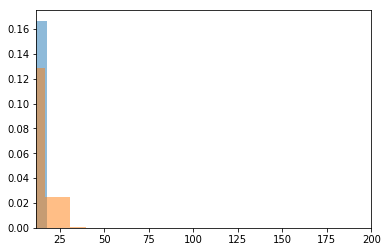

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 19674 -15752  -3814    -90    -10      1     -9      0      0      0
      0      0      0      0      0      0]
19674 -15752 0.5 12
-15752 -3814 0.25 17
-3814 -90 0.0238095238095 31
-90 -10 0.111111111111 40
-10 1 0.1 45.5
1 -9 0 50.5
-9 0 0 60.5
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 20562 -15849  -4584   -111     -8     -3     -7      0      0      0
      0      0      0      0      0      0]
20562 -15849 0.5 12
-15849 -4584 0.333333333333 17
-4584 -111 0.0243902439024 31
-111 -8 0.0769230769231 40
-8 -3 0.5 45.5
-3 -7 0 50.5
-7 0 0 60.5
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 21113 -15446  -5521   -128     -7     -5     -6      0      0      0
      0      0      0      0      0      0]
21113 -15446 0.5 12
-15446 -5521 0.5 17
-5521 -128 0.0232558139535 31
-128 -7 0.0555555555556 40
-7 -5 0 45.5
-5 -6 0 50.5
-6 0 0 60.5
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

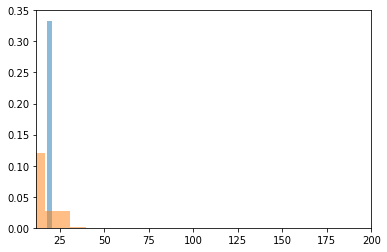

[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 19941 -15392  -4415   -105    -21     -3     -3     -2      0      0
      0      0      0      0      0      0]
19941 -15392 0.5 12
-15392 -4415 0.333333333333 17
-4415 -105 0.0238095238095 31
-105 -21 0.2 40
-21 -3 0.142857142857 45.5
-3 -3 0 50.5
-3 -2 0 60.5
-2 0 0 68
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 20624 -15202  -5267   -125    -22     -2     -5     -1      0      0
      0      0      0      0      0      0]
20624 -15202 0.5 12
-15202 -5267 0.5 17
-5267 -125 0.0238095238095 31
-125 -22 0.2 40
-22 -2 0.0909090909091 45.5
-2 -5 0 50.5
-5 -1 0.2 60.5
-1 0 0 68
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 20820 -14334  -6308   -145    -24     -4     -4     -1      0      0
      0      0      0      0      0      0]
20820 -14334 0.5 12
-14334 -6308 0.5 17
-6308 -145 0.023255813953

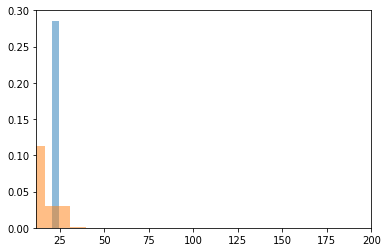

[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 19908 -14634  -5094   -152    -12    -10     -5     -1      0      0
      0      0      0      0      0      0]
19908 -14634 0.5 12
-14634 -5094 0.5 17
-5094 -152 0.030303030303 31
-152 -12 0.0833333333333 40
-12 -10 0 45.5
-10 -5 0.5 50.5
-5 -1 0.2 60.5
-1 0 0 68
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 12
1 -1 0 18
-1 0 0 21
[ 20282 -14072  -6012   -168    -14    -10     -5     -1      0      0
      0      0      0      0      0      0]
20282 -14072 0.5 12
-14072 -6012 0.5 17
-6012 -168 0.0285714285714 31
-168 -14 0.0833333333333 40
-14 -10 0 45.5
-10 -5 0.5 50.5
-5 -1 0.2 60.5
-1 0 0 68
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 12
1 -1 0 18
-1 0 0 21
[ 20299 -12914  -7164   -188    -17    -10     -5     -1      0      0
      0      0      0      0      0      0]
20299 -12914 0.5 12
-12914 -7164 0 17
-7164 -188 0.0

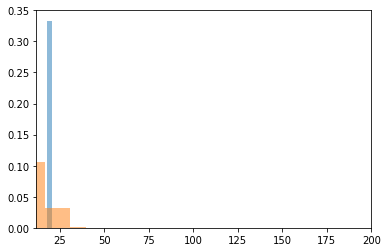

[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 19716 -13720  -5774   -179    -25     -5    -12     -1      0      0
      0      0      0      0      0      0]
19716 -13720 0.5 12
-13720 -5774 0.5 17
-5774 -179 0.03125 31
-179 -25 0.142857142857 40
-25 -5 0.2 45.5
-5 -12 0 50.5
-12 -1 0.0833333333333 60.5
-1 0 0 68
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 19939 -12945  -6743   -206    -26     -7    -11     -1      0      0
      0      0      0      0      0      0]
19939 -12945 0.5 12
-12945 -6743 0 17
-6743 -206 0.03125 31
-206 -26 0.142857142857 40
-26 -7 0.333333333333 45.5
-7 -11 0 50.5
-11 -1 0.0909090909091 60.5
-1 0 0 68
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 19618 -11365  -7964   -242    -27     -9    -10     -1      0      0
      0      0      0      0      0      0]
19618 -11365 0.5 12
-11365 -7964 0 17
-7964 -242 0.031

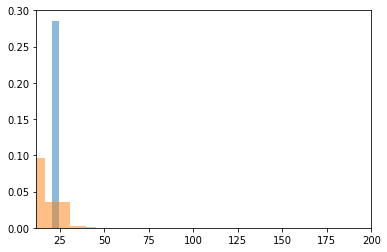

[ 0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 12
1 -1 0 18
-1 0 0 21
[ 19577 -12805  -6488   -241    -15    -16     -9      0     -3      0
      0      0      0      0      0      0]
19577 -12805 0.5 12
-12805 -6488 0 17
-6488 -241 0.0384615384615 31
-241 -15 0.0625 40
-15 -16 0 45.5
-16 -9 0 50.5
-9 0 0 60.5
0 -3 0 68
-3 0 0 91
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 12
1 -1 0 18
-1 0 0 21
[ 19534 -11684  -7528   -273    -21    -15    -11      1     -3      0
      0      0      0      0      0      0]
19534 -11684 0.5 12
-11684 -7528 0 17
-7528 -273 0.037037037037 31
-273 -21 0.0769230769231 40
-21 -15 0 45.5
-15 -11 0 50.5
-11 1 0.0909090909091 60.5
1 -3 0 68
-3 0 0 91
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 18
1 -1 0 21
-1 0 0 24.5
[18917 -9675 -8868  -322   -24   -15   -10    -1    -2     0     0     0
     0     0     0     0]
18917 -9675 0.5 12
-9675 -8868 0 17
-8868 -3

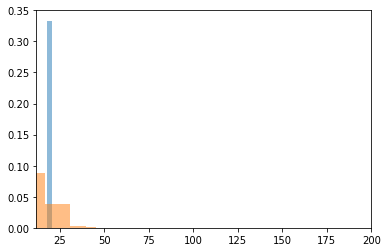

[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 18924 -11234  -7323   -290    -44     -4    -27      0     -2      0
      0      0      0      0      0      0]
18924 -11234 0.5 12
-11234 -7323 0 17
-7323 -290 0.04 31
-290 -44 0.166666666667 40
-44 -4 0.0909090909091 45.5
-4 -27 0 50.5
-27 0 0 60.5
0 -2 0 68
-2 0 0 91
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[18691 -9830 -8449  -331   -48    -3   -28    -1    -1     0     0     0
     0     0     0     0]
18691 -9830 0.5 12
-9830 -8449 0 17
-8449 -331 0.04 31
-331 -48 0.166666666667 40
-48 -3 0.0625 45.5
-3 -28 0 50.5
-28 -1 0.0357142857143 60.5
-1 -1 0 68
-1 0 0 91
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[18026 -7812 -9766  -361   -54    -3   -28    -1    -1     0     0     0
     0     0     0     0]
18026 -7812 0.666666666667 12
-7812 -9766 0 17
-9766 -361 0.037037037037 31
-361 -54 0

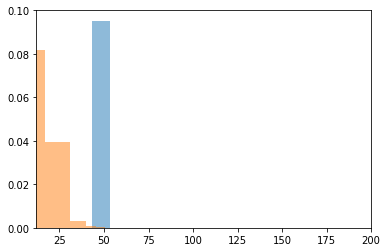

[ 0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0]
0 1 1 33.5
1 -1 0 43
-1 0 0 53.5
[ 18584 -10167  -7968   -356    -49    -14    -27     -1     -2      0
      0      0      0      0      0      0]
18584 -10167 0.5 12
-10167 -7968 0 17
-7968 -356 0.0454545454545 31
-356 -49 0.142857142857 40
-49 -14 0.333333333333 45.5
-14 -27 0 50.5
-27 -1 0.037037037037 60.5
-1 -2 0 68
-2 0 0 91
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0]
0 1 1 33.5
1 -1 0 43
-1 0 0 53.5
[18133 -8459 -9176  -397   -55   -18   -26     0    -2     0     0     0
     0     0     0     0]
18133 -8459 0.666666666667 12
-8459 -9176 0 17
-9176 -397 0.0434782608696 31
-397 -55 0.142857142857 40
-55 -18 0.333333333333 45.5
-18 -26 0 50.5
-26 0 0 60.5
0 -2 0 68
-2 0 0 91
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0]
0 1 1 33.5
1 -1 0 43
-1 0 0 53.5
[ 17335  -6305 -10470   -449    -64    -20    -24     -2     -1      0
      0      0      0      0    

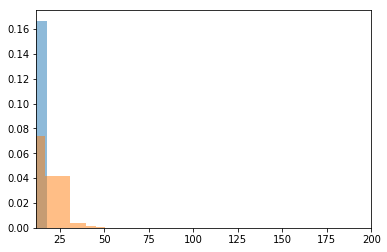

[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[17787 -8275 -8957  -407   -88   -23   -30    -2    -5     0     0     0
     0     0     0     0]
17787 -8275 0.666666666667 12
-8275 -8957 0 17
-8957 -407 0.0454545454545 31
-407 -88 0.25 40
-88 -23 0.333333333333 45.5
-23 -30 0 50.5
-30 -2 0.0666666666667 60.5
-2 -5 0 68
-5 0 0 91
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 17219  -6520 -10079   -461    -95    -30    -28     -1     -5      0
      0      0      0      0      0      0]
17219 -6520 0.666666666667 12
-6520 -10079 0 17
-10079 -461 0.047619047619 31
-461 -95 0.25 40
-95 -30 0.333333333333 45.5
-30 -28 0 50.5
-28 -1 0.0357142857143 60.5
-1 -5 0 68
-5 0 0 91
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 16270  -4183 -11396   -518   -106    -35    -26     -2     -4      0
      0      0      0      0      0      0]
16270 -4183 0.75 12


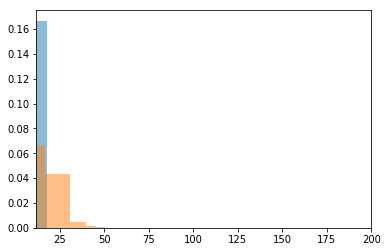

[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[17016 -6582 -9750  -528   -84   -14   -44    -9    -5     0     0     0
     0     0     0     0]
17016 -6582 0.666666666667 12
-6582 -9750 0 17
-9750 -528 0.0555555555556 31
-528 -84 0.166666666667 40
-84 -14 0.166666666667 45.5
-14 -44 0 50.5
-44 -9 0.25 60.5
-9 -5 0 68
-5 0 0 91
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 16279  -4585 -10945   -582    -93    -16    -48     -5     -5      0
      0      0      0      0      0      0]
16279 -4585 0.75 12
-4585 -10945 0 17
-10945 -582 0.0555555555556 31
-582 -93 0.166666666667 40
-93 -16 0.2 45.5
-16 -48 0 50.5
-48 -5 0.111111111111 60.5
-5 -5 0 68
-5 0 0 91
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 15109  -1964 -12302   -658   -109    -19    -48     -4     -5      0
      0      0      0      0      0      0]
15109 -1964 0.875 12
-1964 -1230

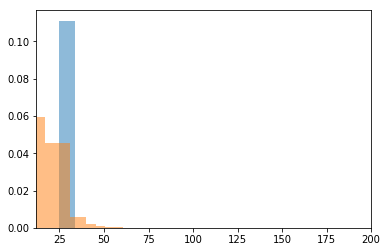

[ 0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 21
1 -1 0 24.5
-1 0 0 33.5
[ 16176  -4953 -10358   -667    -94    -21    -59    -12    -12      0
      0      0      0      0      0      0]
16176 -4953 0.75 12
-4953 -10358 0 17
-10358 -667 0.0666666666667 31
-667 -94 0.142857142857 40
-94 -21 0.25 45.5
-21 -59 0 50.5
-59 -12 0.25 60.5
-12 -12 0 68
-12 0 0 91
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 21
1 -1 0 24.5
-1 0 0 33.5
[ 15218  -2632 -11634   -745    -96    -32    -55    -15     -9      0
      0      0      0      0      0      0]
15218 -2632 0.833333333333 12
-2632 -11634 0 17
-11634 -745 0.0666666666667 31
-745 -96 0.142857142857 40
-96 -32 0.333333333333 45.5
-32 -55 0 50.5
-55 -15 0.333333333333 60.5
-15 -9 0 68
-9 0 0 91
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 21
1 -1 0 24.5
-1 0 0 33.5
[ 14081   -105 -12915   -835   -113    -35    -52    -21     -5      0
      0     

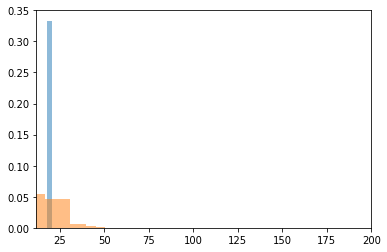

[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 15198  -3063 -11132   -738   -129    -42    -63    -14    -17      1
     -1      0      0      0      0      0]
15198 -3063 0.8 12
-3063 -11132 0 17
-11132 -738 0.0666666666667 31
-738 -129 0.2 40
-129 -42 0.333333333333 45.5
-42 -63 0 50.5
-63 -14 0.25 60.5
-14 -17 0 68
-17 1 0.0588235294118 91
1 -1 0 102.5
-1 0 0 133
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 14356  -1037 -12211   -820   -146    -52    -60    -15    -15      1
     -1      0      0      0      0      0]
14356 -1037 0.928571428571 12
-1037 -12211 0 17
-12211 -820 0.0714285714286 31
-820 -146 0.2 40
-146 -52 0.5 45.5
-52 -60 0 50.5
-60 -15 0.25 60.5
-15 -15 0 68
-15 1 0.0666666666667 91
1 -1 0 102.5
-1 0 0 133
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 12
1 -1 0 18
-1 0 0 21
[ 13117   1607 -13502   -917   -160    -50    -72     -9    -13  

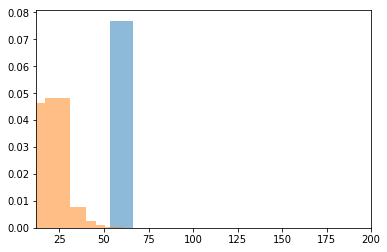

[ 0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0]
0 1 1 43
1 -1 0 53.5
-1 0 0 66.5
[ 14370  -1406 -11786   -864   -160    -20   -108      3    -28     -1
      0      0      0      0      0      0]
14370 -1406 0.909090909091 12
-1406 -11786 0 17
-11786 -864 0.0769230769231 31
-864 -160 0.2 40
-160 -20 0.125 45.5
-20 -108 0 50.5
-108 3 0.0277777777778 60.5
3 -28 0 68
-28 -1 0.0357142857143 91
-1 0 0 102.5
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0]
0 1 1 43
1 -1 0 53.5
-1 0 0 66.5
[ 13319    896 -12902   -979   -179    -19   -110     -1    -24     -1
      0      0      0      0      0      0]
13319 896 0.928571428571 12
896 -12902 0 17
-12902 -979 0.0769230769231 31
-979 -179 0.2 40
-179 -19 0.111111111111 45.5
-19 -110 0 50.5
-110 -1 0.00909090909091 60.5
-1 -24 0 68
-24 -1 0.0416666666667 91
-1 0 0 102.5
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0]
0 1 1 43
1 -1 0 53.5
-1 0 0 66.5
[ 12011   3587 -14147  -1

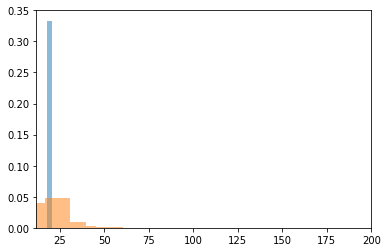

[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 13202    593 -12303  -1111   -179    -22   -122    -30    -27     -1
      0      0      0      0      0      0]
13202 593 0.954545454545 12
593 -12303 0 17
-12303 -1111 0.0909090909091 31
-1111 -179 0.166666666667 40
-179 -22 0.125 45.5
-22 -122 0 50.5
-122 -30 0.25 60.5
-30 -27 0 68
-27 -1 0.037037037037 91
-1 0 0 102.5
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 12107   2891 -13375  -1216   -203    -17   -132    -33    -22      0
      0      0      0      0      0      0]
12107 2891 0.75 12
2891 -13375 0 17
-13375 -1216 0.1 31
-1216 -203 0.2 40
-203 -17 0.0909090909091 45.5
-17 -132 0 50.5
-132 -33 0.25 60.5
-33 -22 0 68
-22 0 0 91
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 10844   5405 -14437  -1381   -221    -24   -135    -32    -19      0
      0      0      0      0      0      0]
108

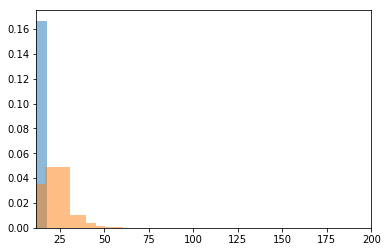

[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 12333   2117 -12764  -1211   -248     -9   -166    -16    -35     -1
      0      0      0      0      0      0]
12333 2117 0.8 12
2117 -12764 0 17
-12764 -1211 0.1 31
-1211 -248 0.25 40
-248 -9 0.037037037037 45.5
-9 -166 0 50.5
-166 -16 0.1 60.5
-16 -35 0 68
-35 -1 0.0285714285714 91
-1 0 0 102.5
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 11145   4515 -13805  -1354   -264    -23   -163    -20    -31      0
      0      0      0      0      0      0]
11145 4515 0.5 12
4515 -13805 0 17
-13805 -1354 0.1 31
-1354 -264 0.2 40
-264 -23 0.0909090909091 45.5
-23 -163 0 50.5
-163 -20 0.125 60.5
-20 -31 0 68
-31 0 0 91
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[  9818   7114 -14904  -1485   -303    -23   -168    -26    -23      0
      0      0      0      0      0      0]
9818 7114 1 12
7114 -14904 

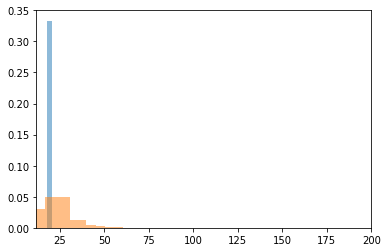

[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 11458   3461 -12982  -1385   -248    -14   -186    -57    -47      0
      0      0      0      0      0      0]
11458 3461 0.666666666667 12
3461 -12982 0 17
-12982 -1385 0.111111111111 31
-1385 -248 0.2 40
-248 -14 0.0588235294118 45.5
-14 -186 0 50.5
-186 -57 0.333333333333 60.5
-57 -47 0 68
-47 0 0 91
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 10298   5740 -13925  -1523   -280    -10   -201    -65    -34      0
      0      0      0      0      0      0]
10298 5740 1 12
5740 -13925 0 17
-13925 -1523 0.111111111111 31
-1523 -280 0.2 40
-280 -10 0.0357142857143 45.5
-10 -201 0 50.5
-201 -65 0.333333333333 60.5
-65 -34 0 68
-34 0 0 91
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[  8911   8354 -14931  -1693   -316    -28   -205    -65    -27      0
      0      0      0      0      0      0]
89

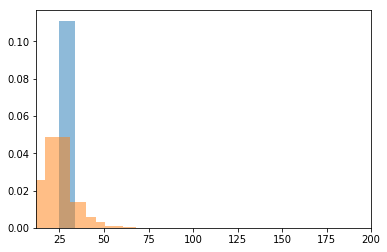

[ 0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 18
1 -1 0 21
-1 0 0 24.5
[ 10234   5376 -13313  -1644   -302     11   -255    -30    -71     -6
      0      0      0      0      0      0]
10234 5376 1 12
5376 -13313 0 17
-13313 -1644 0.125 31
-1644 -302 0.2 40
-302 11 0.0357142857143 45.5
11 -255 0 50.5
-255 -30 0.125 60.5
-30 -71 0 68
-71 -6 0.0909090909091 91
-6 0 0 102.5
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 18
1 -1 0 21
-1 0 0 24.5
[  9081   7578 -14168  -1797   -323    -14   -254    -36    -64     -3
      0      0      0      0      0      0]
9081 7578 1 12
7578 -14168 0 17
-14168 -1797 0.142857142857 31
-1797 -323 0.2 40
-323 -14 0.0434782608696 45.5
-14 -254 0 50.5
-254 -36 0.142857142857 60.5
-36 -64 0 68
-64 -3 0.047619047619 91
-3 0 0 102.5
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 21
1 -1 0 24.5
-1 0 0 33.5
[  7809   9964 -15077  -1957   -339    -57   -247    -37    -

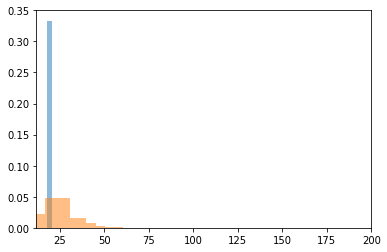

[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[  9298   6670 -13405  -1718   -409     -2   -297    -31   -103     -1
     -2      0      0      0      0      0]
9298 6670 1 12
6670 -13405 0 17
-13405 -1718 0.142857142857 31
-1718 -409 0.25 40
-409 -2 0.00490196078431 45.5
-2 -297 0 50.5
-297 -31 0.111111111111 60.5
-31 -103 0 68
-103 -1 0.00970873786408 91
-1 -2 0 102.5
-2 0 0 133
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 12
1 -1 0 18
-1 0 0 21
[  8136   8843 -14231  -1849   -445    -26   -283    -60    -81     -3
     -1      0      0      0      0      0]
8136 8843 1 12
8843 -14231 0 17
-14231 -1849 0.142857142857 31
-1849 -445 0.25 40
-445 -26 0.0588235294118 45.5
-26 -283 0 50.5
-283 -60 0.25 60.5
-60 -81 0 68
-81 -3 0.037037037037 91
-3 -1 0.333333333333 102.5
-1 0 0 133
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 12
1 -1 0 18
-1 0 0 21
[  6977  10893 -14852  -2059

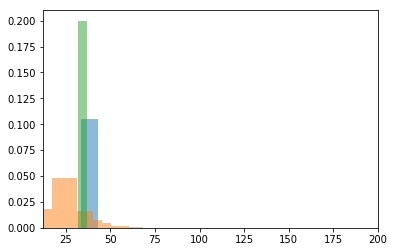

[ 0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 21
1 -1 0 24.5
-1 0 0 33.5
[  8429   7806 -13367  -1960   -356      4   -391    -55   -106     -3
     -1      0      0      0      0      0]
8429 7806 1 12
7806 -13367 0 17
-13367 -1960 0.166666666667 31
-1960 -356 0.2 40
-356 4 0.0112359550562 45.5
4 -391 0 50.5
-391 -55 0.142857142857 60.5
-55 -106 0 68
-106 -3 0.0285714285714 91
-3 -1 0.333333333333 102.5
-1 0 0 133
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0]
0 1 1 24.5
1 -1 0 33.5
-1 0 0 43
[  7301   9839 -14034  -2139   -395    -15   -401    -63    -89     -3
     -1      0      0      0      0      0]
7301 9839 1 12
9839 -14034 0 17
-14034 -2139 0.166666666667 31
-2139 -395 0.2 40
-395 -15 0.0384615384615 45.5
-15 -401 0 50.5
-401 -63 0.166666666667 60.5
-63 -89 0 68
-89 -3 0.0344827586207 91
-3 -1 0.333333333333 102.5
-1 0 0 133
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0]
0 1 1 24.5
1 -1 0 33.5

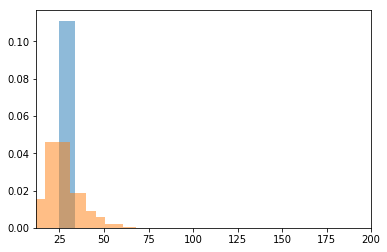

[ 0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 21
1 -1 0 24.5
-1 0 0 33.5
[  7252   9309 -13333  -2175   -399     24   -456    -48   -162    -11
     -1      0      0      0      0      0]
7252 9309 1 12
9309 -13333 0 17
-13333 -2175 0.166666666667 31
-2175 -399 0.2 40
-399 24 0.0588235294118 45.5
24 -456 0 50.5
-456 -48 0.111111111111 60.5
-48 -162 0 68
-162 -11 0.0714285714286 91
-11 -1 0.0909090909091 102.5
-1 0 0 133
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 21
1 -1 0 24.5
-1 0 0 33.5
[  6277  11011 -13804  -2361   -437      1   -488    -43   -149     -7
      0      0      0      0      0      0]
6277 11011 1 12
11011 -13804 0 17
-13804 -2361 0.2 31
-2361 -437 0.2 40
-437 1 0.00228832951945 45.5
1 -488 0 50.5
-488 -43 0.0909090909091 60.5
-43 -149 0 68
-149 -7 0.047619047619 91
-7 0 0 102.5
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 21
1 -1 0 24.5
-1 0 0 33.5
[  5253  12744 -142

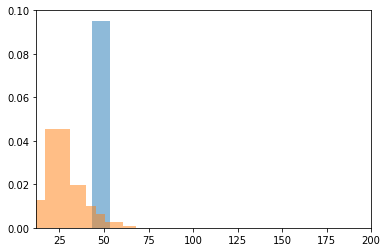

[ 0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0]
0 1 1 33.5
1 -1 0 43
-1 0 0 53.5
[  6480  10179 -13226  -2233   -459    133   -599    -71   -198     -4
     -2      0      0      0      0      0]
6480 10179 1 12
10179 -13226 0 17
-13226 -2233 0.2 31
-2233 -459 0.25 40
-459 133 0.25 45.5
133 -599 0 50.5
-599 -71 0.125 60.5
-71 -198 0 68
-198 -4 0.0204081632653 91
-4 -2 0.5 102.5
-2 0 0 133
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0]
0 1 1 33.5
1 -1 0 43
-1 0 0 53.5
[  5532  11801 -13643  -2414   -498     86   -581   -116   -161     -4
     -2      0      0      0      0      0]
5532 11801 1 12
11801 -13643 0 17
-13643 -2414 0.2 31
-2414 -498 0.25 40
-498 86 0.166666666667 45.5
86 -581 0 50.5
-581 -116 0.2 60.5
-116 -161 0 68
-161 -4 0.025 91
-4 -2 0.5 102.5
-2 0 0 133
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0]
0 1 1 33.5
1 -1 0 43
-1 0 0 53.5
[  4594  13330 -13926  -2641   -544     67   -619   -122   -136

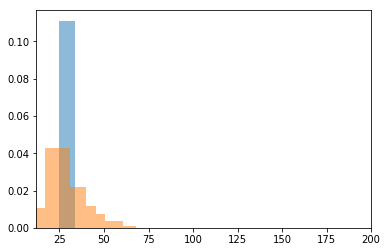

[ 0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 18
1 -1 0 21
-1 0 0 24.5
[  5707  10749 -12568  -2552   -490    201   -690    -85   -258    -12
     -2      0      0      0      0      0]
5707 10749 1 12
10749 -12568 0 17
-12568 -2552 0.25 31
-2552 -490 0.2 40
-490 201 0.333333333333 45.5
201 -690 0 50.5
-690 -85 0.125 60.5
-85 -258 0 68
-258 -12 0.047619047619 91
-12 -2 0.166666666667 102.5
-2 0 0 133
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 18
1 -1 0 21
-1 0 0 24.5
[  4793  12216 -12804  -2787   -535    187   -740    -90   -228    -12
      0      0      0      0      0      0]
4793 12216 1 12
12216 -12804 0 17
-12804 -2787 0.25 31
-2787 -535 0.2 40
-535 187 0.333333333333 45.5
187 -740 0 50.5
-740 -90 0.125 60.5
-90 -228 0 68
-228 -12 0.0526315789474 91
-12 0 0 102.5
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 18
1 -1 0 21
-1 0 0 24.5
[  3942  13482 -12867  -3027   -607    153   -7

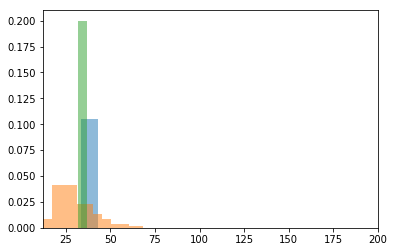

[ 0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 21
1 -1 0 24.5
-1 0 0 33.5
[  5068  11181 -12067  -2663   -492     57   -640    -87   -339    -13
     -5      0      0      0      0      0]
5068 11181 1 12
11181 -12067 0 17
-12067 -2663 0.25 31
-2663 -492 0.2 40
-492 57 0.111111111111 45.5
57 -640 0 50.5
-640 -87 0.142857142857 60.5
-87 -339 0 68
-339 -13 0.0384615384615 91
-13 -5 0.5 102.5
-5 0 0 133
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 21
1 -1 0 24.5
-1 0 0 33.5
[  4276  12402 -12195  -2870   -546     40   -682   -109   -304     -9
     -3      0      0      0      0      0]
4276 12402 1 12
12402 -12195 0.25 17
-12195 -2870 0.25 31
-2870 -546 0.2 40
-546 40 0.0714285714286 45.5
40 -682 0 50.5
-682 -109 0.166666666667 60.5
-109 -304 0 68
-304 -9 0.030303030303 91
-9 -3 0.333333333333 102.5
-3 0 0 133
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 21
1 -1 0 24.5
-1 0 0 33.5
[  3446  

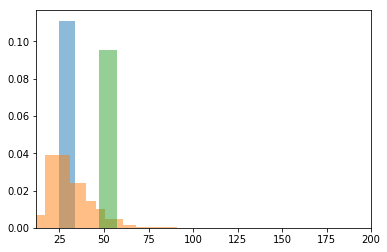

[ 0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 21
1 -1 0 24.5
-1 0 0 33.5
[  4261  11738 -11578  -2726   -514    186   -847    -36   -456    -22
     -6      0      0      0      0      0]
4261 11738 1 12
11738 -11578 0.25 17
-11578 -2726 0.25 31
-2726 -514 0.2 40
-514 186 0.333333333333 45.5
186 -847 0 50.5
-847 -36 0.0434782608696 60.5
-36 -456 0 68
-456 -22 0.05 91
-22 -6 0.333333333333 102.5
-6 0 0 133
[ 0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 37
1 -1 0 47
-1 0 0 57.5
[ 0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 21
1 -1 0 24.5
-1 0 0 33.5
[  3497  12863 -11605  -2962   -567    169   -880    -94   -400    -19
     -2      0      0      0      0      0]
3497 12863 1 12
12863 -11605 0.25 17
-11605 -2962 0.333333333333 31
-2962 -567 0.2 40
-567 169 0.25 45.5
169 -880 0 50.5
-880 -94 0.111111111111 60.5
-94 -400 0 68
-400 -19 0.047619047619 91
-19 -2 0.111111111111 102.5
-2 0 0 133
[ 0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 37
1 -1 0 47
-1 

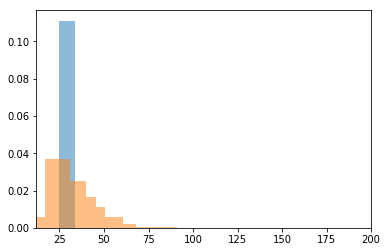

[ 0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 12
1 -1 0 18
-1 0 0 21
[  3661  11757 -10679  -2780   -649    331  -1006    -82   -519    -25
     -9      0      0      0      0      0]
3661 11757 1 12
11757 -10679 0.25 17
-10679 -2780 0.333333333333 31
-2780 -649 0.25 40
-649 331 0.5 45.5
331 -1006 0 50.5
-1006 -82 0.0833333333333 60.5
-82 -519 0 68
-519 -25 0.05 91
-25 -9 0.5 102.5
-9 0 0 133
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 18
1 -1 0 21
-1 0 0 24.5
[  3023  12653 -10634  -2973   -701    303  -1047   -141   -460    -16
     -7      0      0      0      0      0]
3023 12653 1 12
12653 -10634 0.25 17
-10634 -2973 0.333333333333 31
-2973 -701 0.25 40
-701 303 0.333333333333 45.5
303 -1047 0 50.5
-1047 -141 0.142857142857 60.5
-141 -460 0 68
-460 -16 0.0357142857143 91
-16 -7 0.5 102.5
-7 0 0 133
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 18
1 -1 0 21
-1 0 0 24.5
[  2402  13425

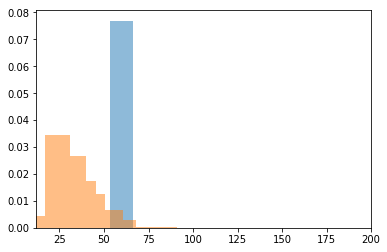

[ 0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0]
0 1 1 43
1 -1 0 53.5
-1 0 0 66.5
[ 3081 11764 -9722 -3039  -603   431 -1211    -4  -655   -26   -16     0
     0     0     0     0]
3081 11764 1 12
11764 -9722 0.25 17
-9722 -3039 0.333333333333 31
-3039 -603 0.2 40
-603 431 0.5 45.5
431 -1211 0 50.5
-1211 -4 0.00331125827815 60.5
-4 -655 0 68
-655 -26 0.04 91
-26 -16 0 102.5
-16 0 0 133
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0]
0 1 1 43
1 -1 0 53.5
-1 0 0 66.5
[ 2490 12523 -9591 -3199  -679   392 -1241   -71  -590   -27    -7     0
     0     0     0     0]
2490 12523 1 12
12523 -9591 0.25 17
-9591 -3199 0.5 31
-3199 -679 0.25 40
-679 392 0.5 45.5
392 -1241 0 50.5
-1241 -71 0.0588235294118 60.5
-71 -590 0 68
-590 -27 0.047619047619 91
-27 -7 0.333333333333 102.5
-7 0 0 133
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0]
0 1 1 43
1 -1 0 53.5
-1 0 0 66.5
[ 1929 13171 -9315 -3440  -724   335 -1282  -126  -517   

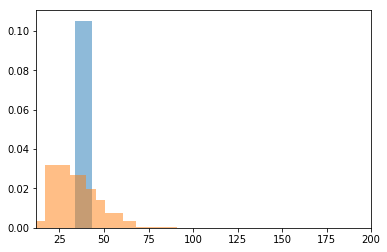

[ 0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0]
0 1 1 24.5
1 -1 0 33.5
-1 0 0 43
[ 2592 11593 -9017 -2770  -774   494 -1195   -28  -830   -44   -21     0
     0     0     0     0]
2592 11593 1 12
11593 -9017 0.25 17
-9017 -2770 0.333333333333 31
-2770 -774 0.333333333333 40
-774 494 0.5 45.5
494 -1195 0 50.5
-1195 -28 0.0238095238095 60.5
-28 -830 0 68
-830 -44 0.0555555555556 91
-44 -21 0.5 102.5
-21 0 0 133
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0]
0 1 1 24.5
1 -1 0 33.5
-1 0 0 43
[ 2075 12196 -8802 -2935  -812   410 -1213  -110  -763   -31   -15     0
     0     0     0     0]
2075 12196 1 12
12196 -8802 0.25 17
-8802 -2935 0.5 31
-2935 -812 0.333333333333 40
-812 410 0.5 45.5
410 -1213 0 50.5
-1213 -110 0.0909090909091 60.5
-110 -763 0 68
-763 -31 0.0416666666667 91
-31 -15 0.5 102.5
-15 0 0 133
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0]
0 1 1 24.5
1 -1 0 33.5
-1 0 0 43
[ 1622 12611 -8414 -3134  -8

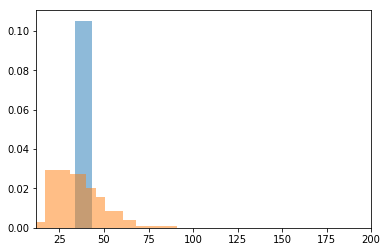

[ 0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0]
0 1 1 24.5
1 -1 0 33.5
-1 0 0 43
[ 2250 11149 -7992 -2987  -526   446 -1293    61 -1010   -79   -19     0
     0     0     0     0]
2250 11149 1 12
11149 -7992 0.25 17
-7992 -2987 0.5 31
-2987 -526 0.2 40
-526 446 0.5 45.5
446 -1293 0 50.5
-1293 61 0.0454545454545 60.5
61 -1010 0 68
-1010 -79 0.0833333333333 91
-79 -19 0.25 102.5
-19 0 0 133
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0]
0 1 1 24.5
1 -1 0 33.5
-1 0 0 43
[ 1786 11603 -7629 -3201  -594   428 -1349   -43  -919   -69   -13     0
     0     0     0     0]
1786 11603 1 12
11603 -7629 0.25 17
-7629 -3201 0.5 31
-3201 -594 0.2 40
-594 428 0.5 45.5
428 -1349 0 50.5
-1349 -43 0.0322580645161 60.5
-43 -919 0 68
-919 -69 0.0769230769231 91
-69 -13 0.2 102.5
-13 0 0 133
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0]
0 1 1 24.5
1 -1 0 33.5
-1 0 0 43
[ 1386 11930 -7229 -3365  -676   394 -1418   -99  -873   -43  

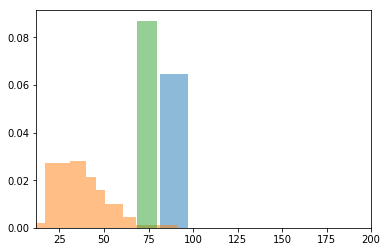

[ 0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0]
0 1 1 66.5
1 -1 0 81.5
-1 0 0 97
[ 1835 10798 -6963 -3086  -723   782 -1332    15 -1223   -74   -28    -1
     0     0     0     0]
1835 10798 1 12
10798 -6963 0.25 17
-6963 -3086 0.5 31
-3086 -723 0.25 40
-723 782 0 45.5
782 -1332 0 50.5
-1332 15 0.0112359550562 60.5
15 -1223 0 68
-1223 -74 0.0625 91
-74 -28 0.5 102.5
-28 -1 0.0357142857143 133
-1 0 0 148
[ 0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0]
0 1 1 57.5
1 -1 0 68.5
-1 0 0 80
[ 0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0]
0 1 1 66.5
1 -1 0 81.5
-1 0 0 97
[ 1457 11116 -6598 -3248  -766   747 -1428   -62 -1137   -63   -18     0
     0     0     0     0]
1457 11116 1 12
11116 -6598 0.25 17
-6598 -3248 0.5 31
-3248 -766 0.25 40
-766 747 0.5 45.5
747 -1428 0 50.5
-1428 -62 0.0434782608696 60.5
-62 -1137 0 68
-1137 -63 0.0555555555556 91
-63 -18 0.333333333333 102.5
-18 0 0 133
[ 0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0]
0 1 1 57.5
1 -1 0 68.5
-1 0 0 80
[ 0  0  0  0  0  0

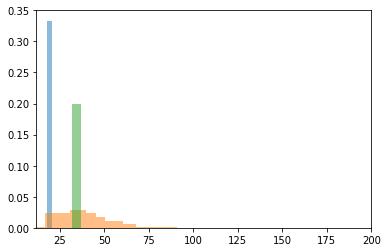

[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 1445 10329 -6089 -2824  -786   904 -1614   229 -1428  -115   -51     1
    -1     0     0     0]
1445 10329 1 12
10329 -6089 0.25 17
-6089 -2824 0.5 31
-2824 -786 0.333333333333 40
-786 904 0 45.5
904 -1614 0 50.5
-1614 229 0.125 60.5
229 -1428 0 68
-1428 -115 0.0833333333333 91
-115 -51 0.5 102.5
-51 1 0.0196078431373 133
1 -1 0 148
-1 0 0 163
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[ 1146 10476 -5613 -3007  -838   898 -1679    63 -1317   -94   -35     1
    -1     0     0     0]
1146 10476 1 12
10476 -5613 0.25 17
-5613 -3007 0 31
-3007 -838 0.333333333333 40
-838 898 0 45.5
898 -1679 0 50.5
-1679 63 0.037037037037 60.5
63 -1317 0 68
-1317 -94 0.0714285714286 91
-94 -35 0.5 102.5
-35 1 0.0285714285714 133
1 -1 0 148
-1 0 0 163
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[  848 10569 -5089 -3

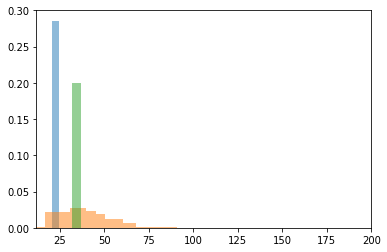

[ 0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 12
1 -1 0 18
-1 0 0 21
[ 1157  9733 -5095 -2922  -715  1193 -1766   342 -1736  -121   -69    -1
     0     0     0     0]
1157 9733 1 12
9733 -5095 0.25 17
-5095 -2922 0 31
-2922 -715 0.25 40
-715 1193 0 45.5
1193 -1766 0 50.5
-1766 342 0.166666666667 60.5
342 -1736 0 68
-1736 -121 0.0714285714286 91
-121 -69 0 102.5
-69 -1 0.0144927536232 133
-1 0 0 148
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 32
-1 0 0 37
[ 0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 12
1 -1 0 18
-1 0 0 21
[  891  9822 -4643 -3010  -790  1189 -1925   257 -1620  -130   -41     0
     0     0     0     0]
891 9822 1 12
9822 -4643 0.166666666667 17
-4643 -3010 0 31
-3010 -790 0.333333333333 40
-790 1189 0 45.5
1189 -1925 0 50.5
-1925 257 0.125 60.5
257 -1620 0 68
-1620 -130 0.0833333333333 91
-130 -41 0.333333333333 102.5
-41 0 0 133
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 32
-1 0 0 37
[ 0  1 -1  0  0  0  0  0  0  0  0  0 

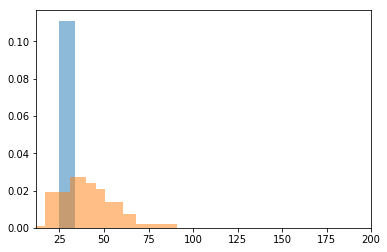

[ 0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 21
1 -1 0 24.5
-1 0 0 33.5
[  910  9026 -4261 -2676  -601  1191 -1763   487 -2054  -167   -92     0
     0     0     0     0]
910 9026 1 12
9026 -4261 0.166666666667 17
-4261 -2676 0 31
-2676 -601 0.25 40
-601 1191 0 45.5
1191 -1763 0 50.5
-1763 487 0.25 60.5
487 -2054 0 68
-2054 -167 0.0833333333333 91
-167 -92 0 102.5
-92 0 0 133
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 21
1 -1 0 24.5
-1 0 0 33.5
[  693  9041 -3782 -2795  -663  1234 -1914   343 -1951  -141   -65     0
     0     0     0     0]
693 9041 1 12
9041 -3782 0.166666666667 17
-3782 -2795 0 31
-2795 -663 0.25 40
-663 1234 0 45.5
1234 -1914 0 50.5
-1914 343 0.166666666667 60.5
343 -1951 0 68
-1951 -141 0.0769230769231 91
-141 -65 0.5 102.5
-65 0 0 133
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 21
1 -1 0 24.5
-1 0 0 33.5
[  530  8906 -3199 -2894  -714  1241 -2079   173 -1805  -

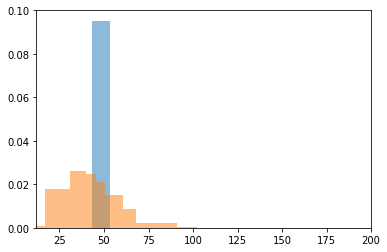

[ 0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0]
0 1 1 33.5
1 -1 0 43
-1 0 0 53.5
[  786  8420 -3752 -2381  -686  1472 -1788   612 -2347  -195  -139    -1
    -1     0     0     0]
786 8420 1 12
8420 -3752 0.166666666667 17
-3752 -2381 0 31
-2381 -686 0.333333333333 40
-686 1472 0 45.5
1472 -1788 0 50.5
-1788 612 0.333333333333 60.5
612 -2347 0 68
-2347 -195 0.0833333333333 91
-195 -139 0 102.5
-139 -1 0.00719424460432 133
-1 -1 0 148
-1 0 0 163
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0]
0 1 1 33.5
1 -1 0 43
-1 0 0 53.5
[  582  8406 -3266 -2486  -733  1495 -1927   452 -2239  -192   -91    -1
     0     0     0     0]
582 8406 1 12
8406 -3266 0.166666666667 17
-3266 -2486 0 31
-2486 -733 0.333333333333 40
-733 1495 0 45.5
1495 -1927 0 50.5
-1927 452 0.2 60.5
452 -2239 0 68
-2239 -192 0.0909090909091 91
-192 -91 0.5 102.5
-91 -1 0.010989010989 133
-1 0 0 148
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0]
0 1 1

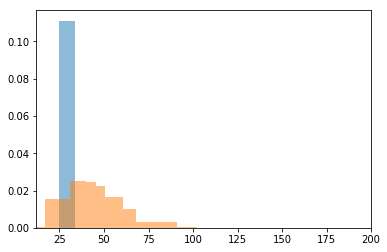

[ 0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 18
1 -1 0 21
-1 0 0 24.5
[  586  7663 -2805 -2432  -418  1468 -1768   884 -2783  -209  -186     0
     0     0     0     0]
586 7663 1 12
7663 -2805 0.166666666667 17
-2805 -2432 0 31
-2432 -418 0.2 40
-418 1468 0 45.5
1468 -1768 0 50.5
-1768 884 0.5 60.5
884 -2783 0 68
-2783 -209 0.0769230769231 91
-209 -186 0 102.5
-186 0 0 133
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 18
1 -1 0 21
-1 0 0 24.5
[  445  7585 -2401 -2435  -456  1453 -1884   687 -2630  -256  -108     0
     0     0     0     0]
445 7585 1 12
7585 -2401 0.125 17
-2401 -2435 0 31
-2435 -456 0.2 40
-456 1453 0 45.5
1453 -1884 0 50.5
-1884 687 0.333333333333 60.5
687 -2630 0 68
-2630 -256 0.1 91
-256 -108 0.5 102.5
-108 0 0 133
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 18
1 -1 0 21
-1 0 0 24.5
[  318  7402 -1838 -2488  -534  1486 -1997   422 -2482  -218   -71     0
     0    

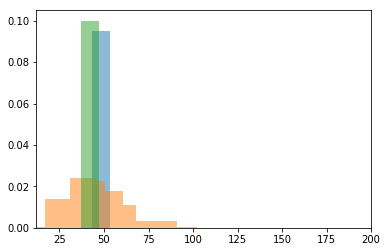

[ 0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0]
0 1 1 33.5
1 -1 0 43
-1 0 0 53.5
[  494  6912 -2122 -2257  -455  1762 -1811  1115 -3122  -316  -195    -5
     0     0     0     0]
494 6912 1 12
6912 -2122 0.125 17
-2122 -2257 0 31
-2257 -455 0.25 40
-455 1762 0 45.5
1762 -1811 0 50.5
-1811 1115 0.5 60.5
1115 -3122 0 68
-3122 -316 0.111111111111 91
-316 -195 0 102.5
-195 -5 0.025641025641 133
-5 0 0 148
[ 0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 32
1 -1 0 37
-1 0 0 47
[ 0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0]
0 1 1 33.5
1 -1 0 43
-1 0 0 53.5
[  372  6795 -1666 -2320  -474  1810 -1985   942 -3058  -286  -127    -3
     0     0     0     0]
372 6795 1 12
6795 -1666 0.1 17
-1666 -2320 0 31
-2320 -474 0.25 40
-474 1810 0 45.5
1810 -1985 0 50.5
-1985 942 0.333333333333 60.5
942 -3058 0 68
-3058 -286 0.1 91
-286 -127 0.5 102.5
-127 -3 0.0238095238095 133
-3 0 0 148
[ 0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 32
1 -1 0 37
-1 0 0 47
[ 0  0  0  0  0  1 -1  0  0

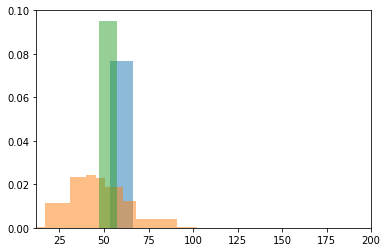

[ 0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0]
0 1 1 43
1 -1 0 53.5
-1 0 0 66.5
[  355  6229 -1464 -2099  -398  1893 -1840  1505 -3561  -318  -300    -2
     0     0     0     0]
355 6229 1 12
6229 -1464 0.1 17
-1464 -2099 0 31
-2099 -398 0.2 40
-398 1893 0 45.5
1893 -1840 0.25 50.5
-1840 1505 0.5 60.5
1505 -3561 0 68
-3561 -318 0.0909090909091 91
-318 -300 0 102.5
-300 -2 0.00666666666667 133
-2 0 0 148
[ 0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 37
1 -1 0 47
-1 0 0 57.5
[ 0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0]
0 1 1 43
1 -1 0 53.5
-1 0 0 66.5
[  249  6047  -942 -2164  -427  1957 -2027  1319 -3519  -265  -226    -2
     0     0     0     0]
249 6047 1 12
6047 -942 0.0714285714286 17
-942 -2164 0 31
-2164 -427 0.2 40
-427 1957 0 45.5
1957 -2027 0 50.5
-2027 1319 0.5 60.5
1319 -3519 0 68
-3519 -265 0.0769230769231 91
-265 -226 0 102.5
-226 -2 0.00884955752212 133
-2 0 0 148
[ 0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 37
1 -1 0 47
-1 0 0 57.5
[ 0  0  0

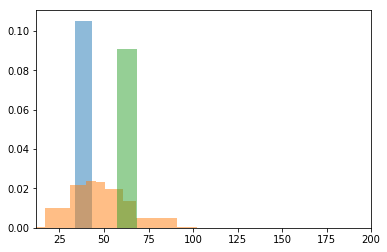

[ 0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0]
0 1 1 24.5
1 -1 0 33.5
-1 0 0 43
[  288  5563  -960 -1943  -336  2158 -1972  1881 -3917  -373  -377   -12
     0     0     0     0]
288 5563 1 12
5563 -960 0.0833333333333 17
-960 -1943 0 31
-1943 -336 0.2 40
-336 2158 0 45.5
2158 -1972 0.25 50.5
-1972 1881 0.5 60.5
1881 -3917 0 68
-3917 -373 0.1 91
-373 -377 0 102.5
-377 -12 0.0322580645161 133
-12 0 0 148
[ 0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 47
1 -1 0 57.5
-1 0 0 68.5
[ 0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0]
0 1 1 24.5
1 -1 0 33.5
-1 0 0 43
[  209  5391  -534 -1949  -353  2178 -2094  1689 -3933  -296  -303    -5
     0     0     0     0]
209 5391 1 12
5391 -534 0.0454545454545 17
-534 -1949 0 31
-1949 -353 0.2 40
-353 2178 0 45.5
2178 -2094 0.25 50.5
-2094 1689 0.5 60.5
1689 -3933 0 68
-3933 -296 0.0769230769231 91
-296 -303 0 102.5
-303 -5 0.0166666666667 133
-5 0 0 148
[ 0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 47
1 -1 0 57.5
-1 0 0 68.5
[ 0 

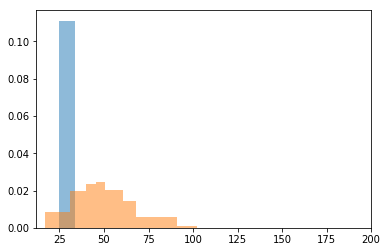

[ 0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 18
1 -1 0 21
-1 0 0 24.5
[  214  4838  -538 -1566  -168  2141 -1967  2234 -4249  -462  -465   -11
    -1     0     0     0]
214 4838 1 12
4838 -538 0.0555555555556 17
-538 -1566 0 31
-1566 -168 0.111111111111 40
-168 2141 0 45.5
2141 -1967 0.25 50.5
-1967 2234 0 60.5
2234 -4249 0 68
-4249 -462 0.111111111111 91
-462 -465 0 102.5
-465 -11 0.0238095238095 133
-11 -1 0.0909090909091 148
-1 0 0 163
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 21
1 -1 0 24.5
-1 0 0 33.5
[  155  4678  -167 -1583  -151  2167 -2074  2042 -4285  -430  -347    -4
    -1     0     0     0]
155 4678 1 12
4678 -167 0.0172413793103 17
-167 -1583 0 31
-1583 -151 0.1 40
-151 2167 0 45.5
2167 -2074 0.25 50.5
-2074 2042 0.5 60.5
2042 -4285 0 68
-4285 -430 0.111111111111 91
-430 -347 0 102.5
-347 -4 0.0116279069767 133
-4 -1 0.25 148
-1 0 0 163
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  1 -1  0  0  0  0  0  0  0  0  0  

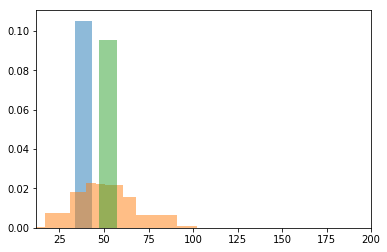

[ 0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0]
0 1 1 24.5
1 -1 0 33.5
-1 0 0 43
[  166  4326  -244 -1443  -293  2429 -1664  2588 -4793  -473  -580   -15
    -4     0     0     0]
166 4326 1 12
4326 -244 0.0277777777778 17
-244 -1443 0 31
-1443 -293 0.25 40
-293 2429 0 45.5
2429 -1664 0.25 50.5
-1664 2588 0 60.5
2588 -4793 0 68
-4793 -473 0.1 91
-473 -580 0 102.5
-580 -15 0.0263157894737 133
-15 -4 0.333333333333 148
-4 0 0 163
[ 0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 37
1 -1 0 47
-1 0 0 57.5
[ 0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0]
0 1 1 24.5
1 -1 0 33.5
-1 0 0 43
[  120  4131   146 -1442  -306  2540 -1828  2359 -4798  -497  -414   -11
     0     0     0     0]
120 4131 1 12
4131 146 0.964285714286 17
146 -1442 0 31
-1442 -306 0.25 40
-306 2540 0 45.5
2540 -1828 0.25 50.5
-1828 2359 0 60.5
2359 -4798 0 68
-4798 -497 0.111111111111 91
-497 -414 0 102.5
-414 -11 0.027027027027 133
-11 0 0 148
[ 0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 37
1 -1 0 47


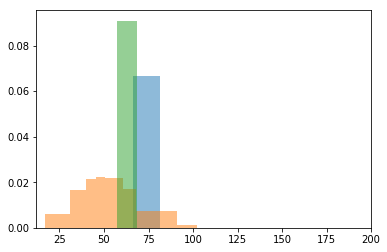

[ 0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0]
0 1 1 53.5
1 -1 0 66.5
-1 0 0 81.5
[  129  3665    85 -1137  -241  2513 -1660  3128 -5196  -501  -760   -17
    -7    -1     0     0]
129 3665 1 12
3665 85 0.976744186047 17
85 -1137 0 31
-1137 -241 0.25 40
-241 2513 0 45.5
2513 -1660 0.25 50.5
-1660 3128 0 60.5
3128 -5196 0 68
-5196 -501 0.1 91
-501 -760 0 102.5
-760 -17 0.0227272727273 133
-17 -7 0.5 148
-7 -1 0.142857142857 163
-1 0 0 196
[ 0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0]
0 1 1 57.5
1 -1 0 68.5
-1 0 0 80
[ 0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0]
0 1 1 53.5
1 -1 0 66.5
-1 0 0 81.5
[   88  3495   430 -1137  -248  2652 -1802  2849 -5211  -525  -576   -10
    -5     0     0     0]
88 3495 1 12
3495 430 0.875 17
430 -1137 0 31
-1137 -248 0.25 40
-248 2652 0 45.5
2652 -1802 0.25 50.5
-1802 2849 0 60.5
2849 -5211 0 68
-5211 -525 0.111111111111 91
-525 -576 0 102.5
-576 -10 0.0175438596491 133
-10 -5 0.5 148
-5 0 0 163
[ 0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0]

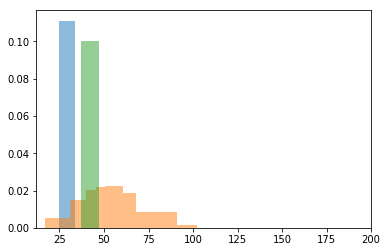

[ 0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 21
1 -1 0 24.5
-1 0 0 33.5
[   81  3129   401 -1120  -107  2815 -1830  3756 -5564  -627  -901   -31
    -2     0     0     0]
81 3129 1 12
3129 401 0.857142857143 17
401 -1120 0 31
-1120 -107 0.1 40
-107 2815 0 45.5
2815 -1830 0.25 50.5
-1830 3756 0 60.5
3756 -5564 0 68
-5564 -627 0.125 91
-627 -901 0 102.5
-901 -31 0.0344827586207 133
-31 -2 0.0666666666667 148
-2 0 0 163
[ 0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 32
1 -1 0 37
-1 0 0 47
[ 0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 21
1 -1 0 24.5
-1 0 0 33.5
[   58  2969   679 -1096   -81  2939 -1963  3487 -5616  -666  -691   -19
     0     0     0     0]
58 2969 1 12
2969 679 0.75 17
679 -1096 0 31
-1096 -81 0.0769230769231 40
-81 2939 0 45.5
2939 -1963 0.25 50.5
-1963 3487 0 60.5
3487 -5616 0 68
-5616 -666 0.125 91
-666 -691 0 102.5
-691 -19 0.0277777777778 133
-19 0 0 148
[ 0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 32
1 -1 0 37
-1 0 0 47
[ 0 

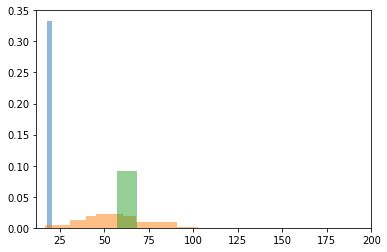

[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[   76  2610   456  -689    -6  2644 -1523  4063 -5921  -573 -1084   -48
    -4    -1     0     0]
76 2610 1 12
2610 456 0.8 17
456 -689 0 31
-689 -6 0.00877192982456 40
-6 2644 0 45.5
2644 -1523 0.25 50.5
-1523 4063 0 60.5
4063 -5921 0 68
-5921 -573 0.1 91
-573 -1084 0 102.5
-1084 -48 0.0454545454545 133
-48 -4 0.0833333333333 148
-4 -1 0.25 163
-1 0 0 196
[ 0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0]
0 1 1 57.5
1 -1 0 68.5
-1 0 0 80
[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1 -1 1 12
-1 0 0 18
[   52  2469   714  -681    60  2736 -1654  3861 -6062  -597  -872   -24
    -2     0     0     0]
52 2469 1 12
2469 714 0.666666666667 17
714 -681 0.25 31
-681 60 0.0833333333333 40
60 2736 1 45.5
2736 -1654 0.25 50.5
-1654 3861 0 60.5
3861 -6062 0 68
-6062 -597 0.1 91
-597 -872 0 102.5
-872 -24 0.0277777777778 133
-24 -2 0.0833333333333 148
-2 0 0 163
[ 0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0]
0 1 1 57.5


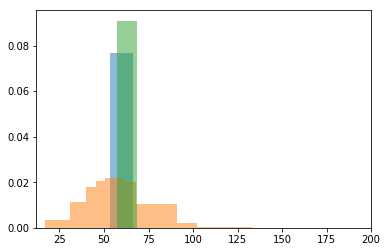

[ 0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0]
0 1 1 43
1 -1 0 53.5
-1 0 0 66.5
[   47  2186   588  -548   -16  2626 -1271  4692 -6229  -656 -1356   -51
   -11    -1     0     0]
47 2186 1 12
2186 588 0.666666666667 17
588 -548 0.25 31
-548 -16 0.0294117647059 40
-16 2626 0 45.5
2626 -1271 0.166666666667 50.5
-1271 4692 0 60.5
4692 -6229 0 68
-6229 -656 0.111111111111 91
-656 -1356 0 102.5
-1356 -51 0.0384615384615 133
-51 -11 0.25 148
-11 -1 0.0909090909091 163
-1 0 0 196
[ 0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0]
0 1 1 57.5
1 -1 0 68.5
-1 0 0 80
[ 0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0]
0 1 1 43
1 -1 0 53.5
-1 0 0 66.5
[   33  2057   781  -477    -2  2765 -1401  4568 -6529  -652 -1103   -35
    -5     0     0     0]
33 2057 1 12
2057 781 0.5 17
781 -477 0.25 31
-477 -2 0.00420168067227 40
-2 2765 0 45.5
2765 -1401 0.25 50.5
-1401 4568 0 60.5
4568 -6529 0 68
-6529 -652 0.1 91
-652 -1103 0 102.5
-1103 -35 0.0322580645161 133
-35 -5 0.142857142857 148
-5 0 0 163
[ 0  0

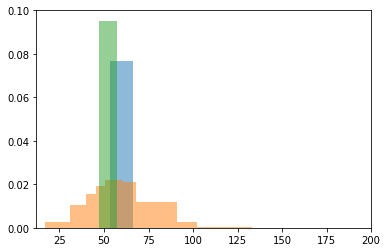

[ 0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0]
0 1 1 53.5
1 -1 0 66.5
-1 0 0 81.5
[   42  1862   655  -536    84  2649 -1114  5153 -6460  -617 -1615   -90
   -10    -3     0     0]
42 1862 1 12
1862 655 0.5 17
655 -536 0.25 31
-536 84 0.142857142857 40
84 2649 1 45.5
2649 -1114 0.166666666667 50.5
-1114 5153 0 60.5
5153 -6460 0 68
-6460 -617 0.1 91
-617 -1615 0 102.5
-1615 -90 0.0588235294118 133
-90 -10 0.111111111111 148
-10 -3 0.333333333333 163
-3 0 0 196
[ 0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 47
1 -1 0 57.5
-1 0 0 68.5
[ 0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0]
0 1 1 53.5
1 -1 0 66.5
-1 0 0 81.5
[   25  1733   880  -524   122  2770 -1162  5003 -6721  -785 -1284   -50
    -6    -1     0     0]
25 1733 1 12
1733 880 1 17
880 -524 0.25 31
-524 122 0.2 40
122 2770 1 45.5
2770 -1162 0.166666666667 50.5
-1162 5003 0 60.5
5003 -6721 0 68
-6721 -785 0.125 91
-785 -1284 0 102.5
-1284 -50 0.04 133
-50 -6 0.125 148
-6 -1 0.166666666667 163
-1 0 0 196
[ 0  0  0  1 -

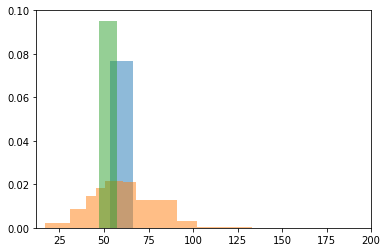

[ 0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0]
0 1 1 43
1 -1 0 53.5
-1 0 0 66.5
[   34  1532   608  -318   138  2593  -972  5762 -6751  -594 -1921   -90
   -14    -7     0     0]
34 1532 1 12
1532 608 0.5 17
608 -318 0.25 31
-318 138 0.333333333333 40
138 2593 1 45.5
2593 -972 0.166666666667 50.5
-972 5762 0 60.5
5762 -6751 0 68
-6751 -594 0.0909090909091 91
-594 -1921 0 102.5
-1921 -90 0.047619047619 133
-90 -14 0.166666666667 148
-14 -7 0.5 163
-7 0 0 196
[ 0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 47
1 -1 0 57.5
-1 0 0 68.5
[ 0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0]
0 1 1 43
1 -1 0 53.5
-1 0 0 66.5
[   19  1426   773  -257   142  2765 -1056  5712 -7177  -725 -1554   -58
    -7    -3     0     0]
19 1426 1 12
1426 773 1 17
773 -257 0.125 31
-257 142 0.5 40
142 2765 1 45.5
2765 -1056 0.166666666667 50.5
-1056 5712 0 60.5
5712 -7177 0 68
-7177 -725 0.111111111111 91
-725 -1554 0 102.5
-1554 -58 0.0384615384615 133
-58 -7 0.125 148
-7 -3 0.5 163
-3 0 0 196
[ 0  0  

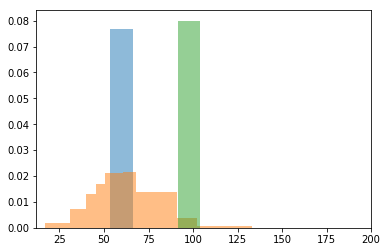

[ 0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0]
0 1 1 53.5
1 -1 0 66.5
-1 0 0 81.5
[   17  1251   650  -251   144  2609  -750  6060 -6895  -346 -2347  -113
   -25    -4     0     0]
17 1251 1 12
1251 650 1 17
650 -251 0.166666666667 31
-251 144 0.5 40
144 2609 1 45.5
2609 -750 0.125 50.5
-750 6060 0 60.5
6060 -6895 0 68
-6895 -346 0.0526315789474 91
-346 -2347 0 102.5
-2347 -113 0.05 133
-113 -25 0.25 148
-25 -4 0.166666666667 163
-4 0 0 196
[ 0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0]
0 1 1 91.5
1 -1 0 104
-1 0 0 117
[ 0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0]
0 1 1 53.5
1 -1 0 66.5
-1 0 0 81.5
[   11  1157   780  -199   178  2767  -802  5959 -7213  -613 -1944   -66
   -14    -1     0     0]
11 1157 1 12
1157 780 1 17
780 -199 0.125 31
-199 178 0.5 40
178 2767 1 45.5
2767 -802 0.125 50.5
-802 5959 0 60.5
5959 -7213 0 68
-7213 -613 0.0909090909091 91
-613 -1944 0 102.5
-1944 -66 0.0344827586207 133
-66 -14 0.25 148
-14 -1 0.0714285714286 163
-1 0 0 196
[ 0  0  0  0  0  0  

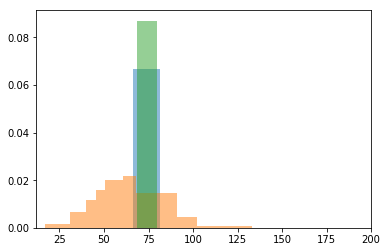

[ 0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0]
0 1 1 66.5
1 -1 0 81.5
-1 0 0 97
[    8  1017   620  -113   191  2395  -497  6319 -6759  -240 -2726  -168
   -43    -4     0     0]
8 1017 1 12
1017 620 1 17
620 -113 0.0833333333333 31
-113 191 0 40
191 2395 1 45.5
2395 -497 0.1 50.5
-497 6319 0 60.5
6319 -6759 0 68
-6759 -240 0.0357142857143 91
-240 -2726 0 102.5
-2726 -168 0.0625 133
-168 -43 0.333333333333 148
-43 -4 0.1 163
-4 0 0 196
[ 0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0]
0 1 1 68.5
1 -1 0 80
-1 0 0 91.5
[ 0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0]
0 1 1 66.5
1 -1 0 81.5
-1 0 0 97
[    8   940   724   -85   241  2586  -563  6272 -7102  -628 -2260  -114
   -16    -3     0     0]
8 940 1 12
940 724 1 17
724 -85 0.0555555555556 31
-85 241 0 40
241 2586 1 45.5
2586 -563 0.1 50.5
-563 6272 0 60.5
6272 -7102 0 68
-7102 -628 0.0909090909091 91
-628 -2260 0 102.5
-2260 -114 0.0526315789474 133
-114 -16 0.142857142857 148
-16 -3 0.2 163
-3 0 0 196
[ 0  0  0  0  0  1 -1  0  

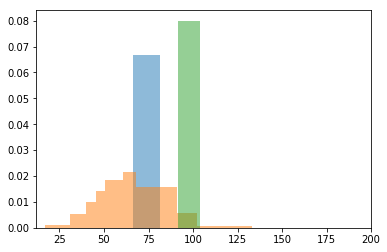

[ 0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0]
0 1 1 66.5
1 -1 0 81.5
-1 0 0 97
[   12   809   623  -142   255  2188  -295  6849 -6742   -32 -3294  -184
   -37   -10     0     0]
12 809 1 12
809 623 1 17
623 -142 0.1 31
-142 255 0 40
255 2188 1 45.5
2188 -295 0.0625 50.5
-295 6849 0 60.5
6849 -6742 0.25 68
-6742 -32 0.0047619047619 91
-32 -3294 0 102.5
-3294 -184 0.0588235294118 133
-184 -37 0.25 148
-37 -10 0.333333333333 163
-10 0 0 196
[ 0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0]
0 1 1 104
1 -1 0 117
-1 0 0 131
[ 0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0]
0 1 1 66.5
1 -1 0 81.5
-1 0 0 97
[   10   740   714  -103   284  2362  -288  6866 -7238  -410 -2787  -130
   -15    -5     0     0]
10 740 1 12
740 714 1 17
714 -103 0.0714285714286 31
-103 284 0 40
284 2362 1 45.5
2362 -288 0.0555555555556 50.5
-288 6866 0 60.5
6866 -7238 0 68
-7238 -410 0.0588235294118 91
-410 -2787 0 102.5
-2787 -130 0.047619047619 133
-130 -15 0.125 148
-15 -5 0.333333333333 163
-5 0 0 196
[ 0  0  

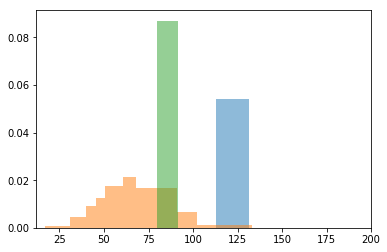

[ 0  0  0  0  0  0  0  0  0  0  0  0  1 -1  0  0]
0 1 1 131.5
1 -1 0 151.5
-1 0 0 173
[    6   655   554    -9   125  2187  -283  7399 -6871   249 -3672  -271
   -59   -10     0     0]
6 655 1 12
655 554 1 17
554 -9 0.00806451612903 31
-9 125 0 40
125 2187 1 45.5
2187 -283 0.0625 50.5
-283 7399 0 60.5
7399 -6871 0.25 68
-6871 249 0.0357142857143 91
249 -3672 0 102.5
-3672 -271 0.0769230769231 133
-271 -59 0.25 148
-59 -10 0.2 163
-10 0 0 196
[ 0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0]
0 1 1 80
1 -1 0 91.5
-1 0 0 104
[ 0  0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0]
0 1 1 113
1 -1 0 131.5
-1 0 0 151.5
[    5   605   610    36   157  2353  -299  7540 -7402  -215 -3165  -194
   -26    -5     0     0]
5 605 1 12
605 610 1 17
610 36 0.9375 31
36 157 1 40
157 2353 1 45.5
2353 -299 0.0625 50.5
-299 7540 0 60.5
7540 -7402 0.25 68
-7402 -215 0.0294117647059 91
-215 -3165 0 102.5
-3165 -194 0.0625 133
-194 -26 0.142857142857 148
-26 -5 0.2 163
-5 0 0 196
[ 0  0  0  0  0  0  1 -1  0  0  0  

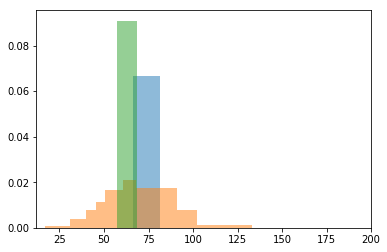

[ 0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0]
0 1 1 66.5
1 -1 0 81.5
-1 0 0 97
[    5   503   487    15   136  2132   -97  7436 -6490   529 -4281  -284
   -80   -11     0     0]
5 503 1 12
503 487 1 17
487 15 0.96875 31
15 136 1 40
136 2132 1 45.5
2132 -97 0.0227272727273 50.5
-97 7436 0 60.5
7436 -6490 0.25 68
-6490 529 0.0769230769231 91
529 -4281 0 102.5
-4281 -284 0.0666666666667 133
-284 -80 0.333333333333 148
-80 -11 0.142857142857 163
-11 0 0 196
[ 0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 47
1 -1 0 57.5
-1 0 0 68.5
[ 0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0]
0 1 1 53.5
1 -1 0 66.5
-1 0 0 81.5
[    3   458   543    54   154  2327  -130  7691 -7176    68 -3748  -195
   -44    -5     0     0]
3 458 1 12
458 543 1 17
543 54 0.9 31
54 154 1 40
154 2327 1 45.5
2327 -130 0.0277777777778 50.5
-130 7691 0 60.5
7691 -7176 0.25 68
-7176 68 0.00943396226415 91
68 -3748 0 102.5
-3748 -195 0.0526315789474 133
-195 -44 0.25 148
-44 -5 0.125 163
-5 0 0 196
[ 0  0  0  1 -1

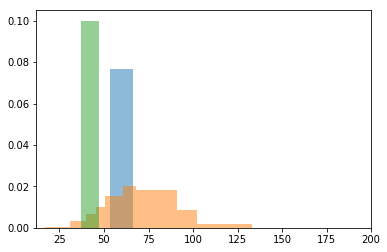

[ 0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0]
0 1 1 53.5
1 -1 0 66.5
-1 0 0 81.5
[    5   386   467     6   180  2050  -153  7633 -6293  1007 -4762  -408
  -102   -16     0     0]
5 386 1 12
386 467 1 17
467 6 0.987012987013 31
6 180 1 40
180 2050 1 45.5
2050 -153 0.0357142857143 50.5
-153 7633 0 60.5
7633 -6293 0.25 68
-6293 1007 0.142857142857 91
1007 -4762 0 102.5
-4762 -408 0.0909090909091 133
-408 -102 0.25 148
-102 -16 0.166666666667 163
-16 0 0 196
[ 0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 32
1 -1 0 37
-1 0 0 47
[ 0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0]
0 1 1 53.5
1 -1 0 66.5
-1 0 0 81.5
[    2   353   518    17   228  2243  -196  7850 -6757   306 -4233  -270
   -54    -7     0     0]
2 353 1 12
353 518 1 17
518 17 0.966666666667 31
17 228 1 40
228 2243 1 45.5
2243 -196 0.0416666666667 50.5
-196 7850 0 60.5
7850 -6757 0.25 68
-6757 306 0.0434782608696 91
306 -4233 0 102.5
-4233 -270 0.0666666666667 133
-270 -54 0.2 148
-54 -7 0.142857142857 163
-7 0 0 1

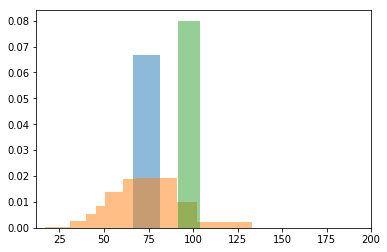

[ 0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0]
0 1 1 66.5
1 -1 0 81.5
-1 0 0 97
[    5   316   391    12   158  1853   -71  7718 -5713  1419 -5474  -437
  -150   -27     0     0]
5 316 1 12
316 391 1 17
391 12 0.96875 31
12 158 1 40
158 1853 1 45.5
1853 -71 0.0185185185185 50.5
-71 7718 0 60.5
7718 -5713 0.25 68
-5713 1419 0.2 91
1419 -5474 0 102.5
-5474 -437 0.0833333333333 133
-437 -150 0.5 148
-150 -27 0.2 163
-27 0 0 196
[ 0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0]
0 1 1 91.5
1 -1 0 104
-1 0 0 117
[ 0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0]
0 1 1 66.5
1 -1 0 81.5
-1 0 0 97
[    3   279   455     5   196  2001   -29  8120 -6399   620 -4825  -325
   -91   -10     0     0]
3 279 1 12
279 455 1 17
455 5 0.989010989011 31
5 196 1 40
196 2001 1 45.5
2001 -29 0.00724637681159 50.5
-29 8120 0 60.5
8120 -6399 0.25 68
-6399 620 0.0909090909091 91
620 -4825 0 102.5
-4825 -325 0.0714285714286 133
-325 -91 0.333333333333 148
-91 -10 0.111111111111 163
-10 0 0 196
[ 0  0  0  0  0  

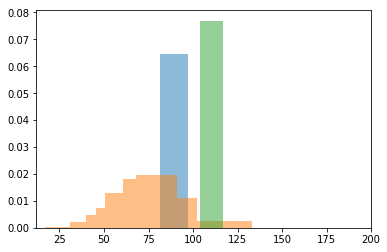

[ 0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0]
0 1 1 66.5
1 -1 0 81.5
-1 0 0 97
[    1   220   358    41   149  1700    68  7746 -5510  1963 -5946  -621
  -116   -53     0     0]
1 220 1 12
220 358 1 17
358 41 0.875 31
41 149 1 40
149 1700 1 45.5
1700 68 0.96 50.5
68 7746 1 60.5
7746 -5510 0.25 68
-5510 1963 0.333333333333 91
1963 -5946 0 102.5
-5946 -621 0.111111111111 133
-621 -116 0.2 148
-116 -53 0.5 163
-53 0 0 196
[ 0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0]
0 1 1 117
1 -1 0 131
-1 0 0 145
[ 0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0]
0 1 1 66.5
1 -1 0 81.5
-1 0 0 97
[    1   199   374    74   167  1842    90  8196 -6079  1039 -5380  -423
   -75   -25     0     0]
1 199 1 12
199 374 1 17
374 74 0.8 31
74 167 1 40
167 1842 1 45.5
1842 90 0.95 50.5
90 8196 1 60.5
8196 -6079 0.25 68
-6079 1039 0.166666666667 91
1039 -5380 0 102.5
-5380 -423 0.0833333333333 133
-423 -75 0.2 148
-75 -25 0.333333333333 163
-25 0 0 196
[ 0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0]
0 1 1 

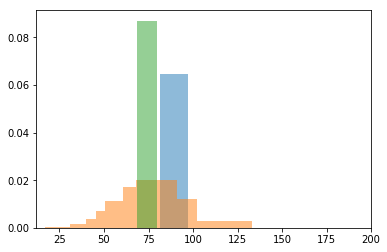

[ 0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0]
0 1 1 66.5
1 -1 0 81.5
-1 0 0 97
[    1   179   281    48   192  1429   157  7757 -4950  2261 -6440  -645
  -217   -53     0     0]
1 179 1 12
179 281 1 17
281 48 0.8 31
48 192 1 40
192 1429 1 45.5
1429 157 0.888888888889 50.5
157 7757 1 60.5
7757 -4950 0.25 68
-4950 2261 0.333333333333 91
2261 -6440 0 102.5
-6440 -645 0.111111111111 133
-645 -217 0.5 148
-217 -53 0.25 163
-53 0 0 196
[ 0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0]
0 1 1 68.5
1 -1 0 80
-1 0 0 91.5
[ 0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0]
0 1 1 66.5
1 -1 0 81.5
-1 0 0 97
[    1   162   292    81   225  1535   230  8257 -5737  1602 -6050  -437
  -135   -26     0     0]
1 162 1 12
162 292 1 17
292 81 0.666666666667 31
81 225 1 40
225 1535 1 45.5
1535 230 0.833333333333 50.5
230 8257 1 60.5
8257 -5737 0.25 68
-5737 1602 0.25 91
1602 -6050 0 102.5
-6050 -437 0.0769230769231 133
-437 -135 0.333333333333 148
-135 -26 0.2 163
-26 0 0 196
[ 0  0  0  0  0  1 -1  0  0  

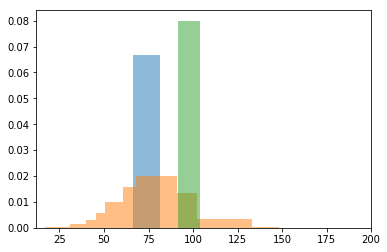

[ 0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0]
0 1 1 66.5
1 -1 0 81.5
-1 0 0 97
[    0   141   241    32   164  1246   256  7642 -4529  2996 -7092  -804
  -207   -86     1    -1]
0 141 1 12
141 241 1 17
241 32 0.857142857143 31
32 164 1 40
164 1246 1 45.5
1246 256 0.75 50.5
256 7642 1 60.5
7642 -4529 0.25 68
-4529 2996 0.5 91
2996 -7092 0 102.5
-7092 -804 0.125 133
-804 -207 0.333333333333 148
-207 -86 0.5 163
-86 1 0.0116279069767 196
1 -1 0 220
[ 0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0]
0 1 1 91.5
1 -1 0 104
-1 0 0 117
[ 0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0]
0 1 1 66.5
1 -1 0 81.5
-1 0 0 97
[    0   127   247    62   192  1324   361  8133 -5105  2080 -6678  -561
  -146   -35    -1     0]
0 127 1 12
127 247 1 17
247 62 0.666666666667 31
62 192 1 40
192 1324 1 45.5
1324 361 0.666666666667 50.5
361 8133 1 60.5
8133 -5105 0.25 68
-5105 2080 0.333333333333 91
2080 -6678 0 102.5
-6678 -561 0.0909090909091 133
-561 -146 0.333333333333 148
-146 -35 0.25 163
-35 -1 0.02857

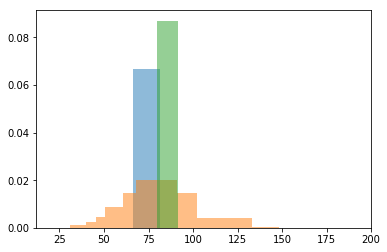

[ 0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0]
0 1 1 53.5
1 -1 0 66.5
-1 0 0 81.5
[    0   109   174    34   150  1061   314  7383 -3903  3613 -7520  -980
  -315  -118    -2     0]
0 109 1 12
109 174 1 17
174 34 0.8 31
34 150 1 40
150 1061 1 45.5
1061 314 0.666666666667 50.5
314 7383 1 60.5
7383 -3903 0.25 68
-3903 3613 0.5 91
3613 -7520 0 102.5
-7520 -980 0.142857142857 133
-980 -315 0.333333333333 148
-315 -118 0.5 163
-118 -2 0.0169491525424 196
-2 0 0 220
[ 0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0]
0 1 1 80
1 -1 0 91.5
-1 0 0 104
[ 0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0]
0 1 1 53.5
1 -1 0 66.5
-1 0 0 81.5
[    0    89   205    32   173  1150   425  7981 -4637  2816 -7205  -753
  -220   -55    -1     0]
0 89 1 12
89 205 1 17
205 32 0.833333333333 31
32 173 1 40
173 1150 1 45.5
1150 425 0.5 50.5
425 7981 1 60.5
7981 -4637 0.25 68
-4637 2816 0.5 91
2816 -7205 0 102.5
-7205 -753 0.111111111111 133
-753 -220 0.333333333333 148
-220 -55 0.25 163
-55 -1 0.0181818181818 19

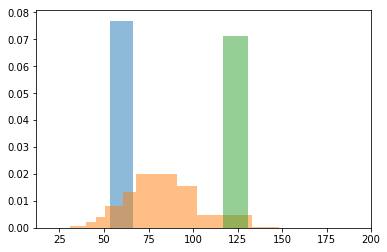

[ 0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0]
0 1 1 53.5
1 -1 0 66.5
-1 0 0 81.5
[    0    77   147    51   122  1058   183  7071 -3331  4189 -7955 -1091
  -374  -147     0     0]
0 77 1 12
77 147 1 17
147 51 0.5 31
51 122 1 40
122 1058 1 45.5
1058 183 0.8 50.5
183 7071 1 60.5
7071 -3331 0.166666666667 68
-3331 4189 0 91
4189 -7955 0 102.5
-7955 -1091 0.142857142857 133
-1091 -374 0.5 148
-374 -147 0.5 163
-147 0 0 196
[ 0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0]
0 1 1 131
1 -1 0 145
-1 0 0 163.5
[ 0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0]
0 1 1 43
1 -1 0 53.5
-1 0 0 66.5
[    0    68   154    65   138  1137   309  7690 -4000  3316 -7703  -864
  -228   -82     0     0]
0 68 1 12
68 154 1 17
154 65 0.5 31
65 138 1 40
138 1137 1 45.5
1137 309 0.666666666667 50.5
309 7690 1 60.5
7690 -4000 0.25 68
-4000 3316 0.5 91
3316 -7703 0 102.5
-7703 -864 0.125 133
-864 -228 0.333333333333 148
-228 -82 0.5 163
-82 0 0 196
[ 0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0]
0 1 1 117
1 -

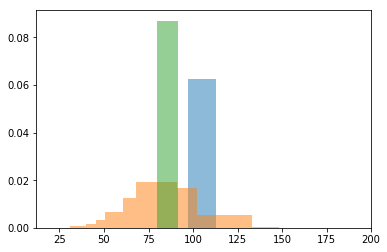

[ 0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0]
0 1 1 97
1 -1 0 113
-1 0 0 131.5
[    0    62    94    44   113   881   273  6660 -2775  4959 -8341 -1323
  -448  -197    -2     0]
0 62 1 12
62 94 1 17
94 44 0.5 31
44 113 1 40
113 881 1 45.5
881 273 0.666666666667 50.5
273 6660 1 60.5
6660 -2775 0.166666666667 68
-2775 4959 0 91
4959 -8341 0 102.5
-8341 -1323 0.166666666667 133
-1323 -448 0.5 148
-448 -197 0.5 163
-197 -2 0.0102040816327 196
-2 0 0 220
[ 0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0]
0 1 1 80
1 -1 0 91.5
-1 0 0 104
[ 0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0]
0 1 1 97
1 -1 0 113
-1 0 0 131.5
[    0    50   105    60   121   963   347  7280 -3197  3923 -8173 -1057
  -332   -89    -1     0]
0 50 1 12
50 105 1 17
105 60 1 31
60 121 1 40
121 963 1 45.5
963 347 0.5 50.5
347 7280 1 60.5
7280 -3197 0.166666666667 68
-3197 3923 0 91
3923 -8173 0 102.5
-8173 -1057 0.142857142857 133
-1057 -332 0.333333333333 148
-332 -89 0.333333333333 163
-89 -1 0.0112359550562 196
-1 0

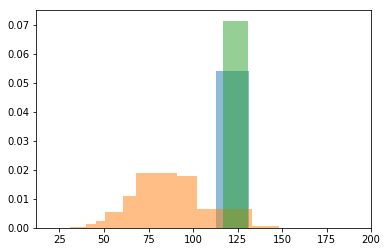

[ 0  0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0]
0 1 1 113
1 -1 0 131.5
-1 0 0 151.5
[    0    35    83    68    58   652   368  6335 -2448  5990 -8862 -1469
  -535  -273    -2     0]
0 35 1 12
35 83 1 17
83 68 1 31
68 58 1 40
58 652 1 45.5
652 368 1 50.5
368 6335 1 60.5
6335 -2448 0.166666666667 68
-2448 5990 0 91
5990 -8862 0 102.5
-8862 -1469 0.166666666667 133
-1469 -535 0.5 148
-535 -273 0 163
-273 -2 0.00735294117647 196
-2 0 0 220
[ 0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0]
0 1 1 131
1 -1 0 145
-1 0 0 163.5
[ 0  0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0]
0 1 1 113
1 -1 0 131.5
-1 0 0 151.5
[    0    30    90    70    70   742   413  7046 -2918  5033 -8834 -1221
  -382  -138    -1     0]
0 30 1 12
30 90 1 17
90 70 1 31
70 70 1 40
70 742 1 45.5
742 413 1 50.5
413 7046 1 60.5
7046 -2918 0.166666666667 68
-2918 5033 0 91
5033 -8834 0 102.5
-8834 -1221 0.142857142857 133
-1221 -382 0.333333333333 148
-382 -138 0.5 163
-138 -1 0.00724637681159 196
-1 0 0 220
[ 0  0  0  0  0  

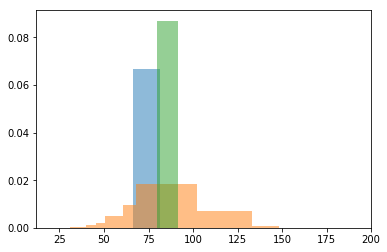

[ 0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0]
0 1 1 66.5
1 -1 0 81.5
-1 0 0 97
[    0    31    76    24    74   600   312  5995 -1952  6361 -9032 -1497
  -668  -318    -6     0]
0 31 1 12
31 76 1 17
76 24 0.666666666667 31
24 74 1 40
74 600 1 45.5
600 312 1 50.5
312 5995 1 60.5
5995 -1952 0.125 68
-1952 6361 0 91
6361 -9032 0 102.5
-9032 -1497 0.166666666667 133
-1497 -668 0.5 148
-668 -318 0.5 163
-318 -6 0.0188679245283 196
-6 0 0 220
[ 0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0]
0 1 1 80
1 -1 0 91.5
-1 0 0 104
[ 0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0]
0 1 1 66.5
1 -1 0 81.5
-1 0 0 97
[    0    27    76    36    79   685   362  6651 -2359  5542 -9146 -1279
  -530  -142    -2     0]
0 27 1 12
27 76 1 17
76 36 0.5 31
36 79 1 40
79 685 1 45.5
685 362 1 50.5
362 6651 1 60.5
6651 -2359 0.166666666667 68
-2359 5542 0 91
5542 -9146 0 102.5
-9146 -1279 0.142857142857 133
-1279 -530 0.5 148
-530 -142 0.333333333333 163
-142 -2 0.0140845070423 196
-2 0 0 220
[ 0  0  0  0  0  1 

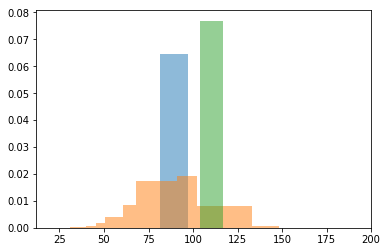

[ 0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0]
0 1 1 81.5
1 -1 0 97
-1 0 0 113
[    0    18    60    25    68   520   213  5454 -1256  6961 -9123 -1809
  -694  -433    -4     0]
0 18 1 12
18 60 1 17
60 25 0.5 31
25 68 1 40
68 520 1 45.5
520 213 0.5 50.5
213 5454 1 60.5
5454 -1256 0.1 68
-1256 6961 0 91
6961 -9123 0 102.5
-9123 -1809 0.2 133
-1809 -694 0.5 148
-694 -433 0 163
-433 -4 0.00925925925926 196
-4 0 0 220
[ 0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0]
0 1 1 104
1 -1 0 117
-1 0 0 131
[ 0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0]
0 1 1 81.5
1 -1 0 97
-1 0 0 113
[    0    17    58    33    68   597   247  6213 -1738  6293 -9441 -1593
  -540  -214     0     0]
0 17 1 12
17 58 1 17
58 33 1 31
33 68 1 40
68 597 1 45.5
597 247 0.5 50.5
247 6213 1 60.5
6213 -1738 0.125 68
-1738 6293 0 91
6293 -9441 0 102.5
-9441 -1593 0.2 133
-1593 -540 0.5 148
-540 -214 0.5 163
-214 0 0 196
[ 0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0]
0 1 1 104
1 -1 0 117
-1 0 0 131
[ 0  0  0  0  0  0 

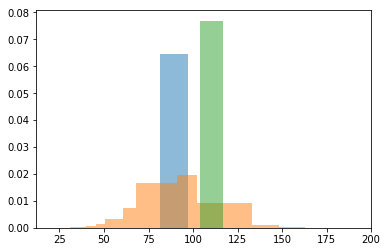

[ 0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0]
0 1 1 81.5
1 -1 0 97
-1 0 0 113
[    0    14    49    19    75   408   182  5030  -994  7762 -9247 -1888
  -867  -527   -16     0]
0 14 1 12
14 49 1 17
49 19 0.5 31
19 75 1 40
75 408 1 45.5
408 182 0.5 50.5
182 5030 1 60.5
5030 -994 0.0833333333333 68
-994 7762 0 91
7762 -9247 0 102.5
-9247 -1888 0.25 133
-1888 -867 0.5 148
-867 -527 0 163
-527 -16 0.03125 196
-16 0 0 220
[ 0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0]
0 1 1 117
1 -1 0 131
-1 0 0 145
[ 0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0]
0 1 1 81.5
1 -1 0 97
-1 0 0 113
[    0    13    48    26    78   448   236  5748 -1316  7116 -9725 -1711
  -662  -294    -5     0]
0 13 1 12
13 48 1 17
48 26 1 31
26 78 1 40
78 448 1 45.5
448 236 1 50.5
236 5748 1 60.5
5748 -1316 0.1 68
-1316 7116 0 91
7116 -9725 0 102.5
-9725 -1711 0.2 133
-1711 -662 0.5 148
-662 -294 0.5 163
-294 -5 0.0172413793103 196
-5 0 0 220
[ 0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0]
0 1 1 117
1 -1 0 131
-1 0

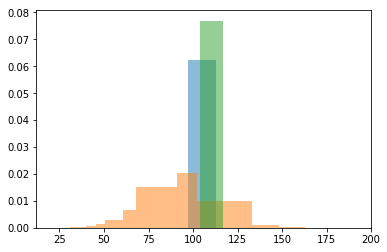

[ 0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0]
0 1 1 97
1 -1 0 113
-1 0 0 131.5
[    0    13    32    34    49   324   186  4562  -695  8474 -9365 -1926
 -1042  -633   -13     0]
0 13 1 12
13 32 1 17
32 34 1 31
34 49 1 40
49 324 1 45.5
324 186 1 50.5
186 4562 1 60.5
4562 -695 0.0714285714286 68
-695 8474 0 91
8474 -9365 0 102.5
-9365 -1926 0.25 133
-1926 -1042 0 148
-1042 -633 0 163
-633 -13 0.0208333333333 196
-13 0 0 220
[ 0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0]
0 1 1 117
1 -1 0 131
-1 0 0 145
[ 0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0]
0 1 1 97
1 -1 0 113
-1 0 0 131.5
[     0     12     28     46     52    359    250   5157   -871   7996
 -10038  -1822   -816   -352     -1      0]
0 12 1 12
12 28 1 17
28 46 1 31
46 52 1 40
52 359 1 45.5
359 250 1 50.5
250 5157 1 60.5
5157 -871 0.0833333333333 68
-871 7996 0 91
7996 -10038 0 102.5
-10038 -1822 0.2 133
-1822 -816 0.5 148
-816 -352 0.5 163
-352 -1 0.00284090909091 196
-1 0 0 220
[ 0  0  0  0  0  0  0  0  0  1 -1  0  0 

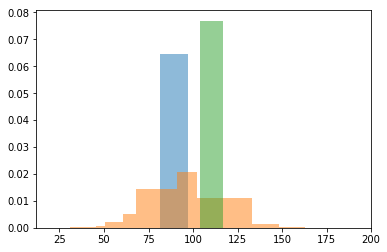

[ 0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0]
0 1 1 81.5
1 -1 0 97
-1 0 0 113
[    0     7    32     1    28   309   175  4022  -282  8876 -9086 -2137
 -1118  -798   -29     0]
0 7 1 12
7 32 1 17
32 1 0.96875 31
1 28 1 40
28 309 1 45.5
309 175 1 50.5
175 4022 1 60.5
4022 -282 0.0333333333333 68
-282 8876 0 91
8876 -9086 0 102.5
-9086 -2137 0.25 133
-2137 -1118 0 148
-1118 -798 0 163
-798 -29 0.037037037037 196
-29 0 0 220
[ 0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0]
0 1 1 104
1 -1 0 117
-1 0 0 131
[ 0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0]
0 1 1 81.5
1 -1 0 97
-1 0 0 113
[    0     7    31     4    36   346   197  4670  -492  8611 -9995 -2039
  -886  -481    -9     0]
0 7 1 12
7 31 1 17
31 4 0.857142857143 31
4 36 1 40
36 346 1 45.5
346 197 1 50.5
197 4670 1 60.5
4670 -492 0.05 68
-492 8611 0 91
8611 -9995 0 102.5
-9995 -2039 0.25 133
-2039 -886 0.5 148
-886 -481 0 163
-481 -9 0.0188679245283 196
-9 0 0 220
[ 0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0]
0 1 1 104
1 -

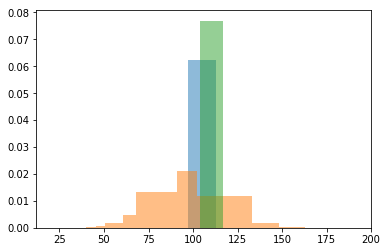

[ 0  0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0]
0 1 1 113
1 -1 0 131.5
-1 0 0 151.5
[    0     3    24     4    36   249   144  3575   -45  9413 -9076 -2086
 -1172 -1039   -29    -1]
0 3 1 12
3 24 1 17
24 4 0.833333333333 31
4 36 1 40
36 249 1 45.5
249 144 1 50.5
144 3575 1 60.5
3575 -45 0.00625 68
-45 9413 0 91
9413 -9076 0.25 102.5
-9076 -2086 0.25 133
-2086 -1172 0 148
-1172 -1039 0 163
-1039 -29 0.0285714285714 196
-29 -1 0.0344827586207 220
[ 0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0]
0 1 1 117
1 -1 0 131
-1 0 0 145
[ 0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0]
0 1 1 97
1 -1 0 113
-1 0 0 131.5
[    0     3    24     4    42   289   167  4157  -145  9153 -9914 -2128
 -1042  -598   -12     0]
0 3 1 12
3 24 1 17
24 4 0.833333333333 31
4 42 1 40
42 289 1 45.5
289 167 1 50.5
167 4157 1 60.5
4157 -145 0.0172413793103 68
-145 9153 0 91
9153 -9914 0 102.5
-9914 -2128 0.25 133
-2128 -1042 0.5 148
-1042 -598 0 163
-598 -12 0.0204081632653 196
-12 0 0 220
[ 0  0  0  0  0  0  0  0 

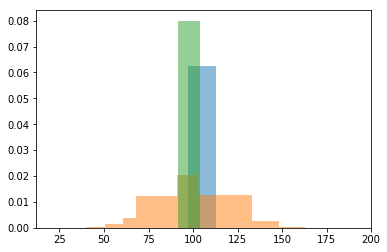

[ 0  0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0]
0 1 1 113
1 -1 0 131.5
-1 0 0 151.5
[    0     2    11    13     8   195   136  3179   222  9552 -8567 -2231
 -1143 -1325   -49    -3]
0 2 1 12
2 11 1 17
11 13 1 31
13 8 1 40
8 195 1 45.5
195 136 1 50.5
136 3179 1 60.5
3179 222 0.928571428571 68
222 9552 1 91
9552 -8567 0.25 102.5
-8567 -2231 0.333333333333 133
-2231 -1143 0 148
-1143 -1325 0 163
-1325 -49 0.037037037037 196
-49 -3 0.0625 220
[ 0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0]
0 1 1 91.5
1 -1 0 104
-1 0 0 117
[ 0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0]
0 1 1 97
1 -1 0 113
-1 0 0 131.5
[    0     2    11    13    12   226   158  3749   174  9365 -9456 -2306
 -1163  -763   -22     0]
0 2 1 12
2 11 1 17
11 13 1 31
13 12 1 40
12 226 1 45.5
226 158 1 50.5
158 3749 1 60.5
3749 174 0.952380952381 68
174 9365 1 91
9365 -9456 0 102.5
-9456 -2306 0.25 133
-2306 -1163 0 148
-1163 -763 0 163
-763 -22 0.0294117647059 196
-22 0 0 220
[ 0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0 

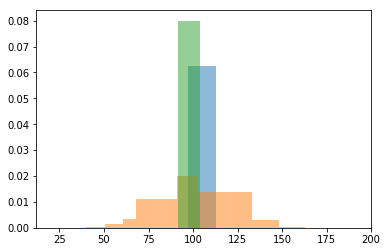

[ 0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0]
0 1 1 97
1 -1 0 113
-1 0 0 131.5
[    0     3     9     7    20   150   151  2785   252  9825 -8036 -2224
 -1412 -1476   -52    -2]
0 3 1 12
3 9 1 17
9 7 1 31
7 20 1 40
20 150 1 45.5
150 151 1 50.5
151 2785 1 60.5
2785 252 0.909090909091 68
252 9825 1 91
9825 -8036 0.25 102.5
-8036 -2224 0.333333333333 133
-2224 -1412 0 148
-1412 -1476 0 163
-1476 -52 0.0357142857143 196
-52 -2 0.0384615384615 220
[ 0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0]
0 1 1 91.5
1 -1 0 104
-1 0 0 117
[ 0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0]
0 1 1 97
1 -1 0 113
-1 0 0 131.5
[    0     3     9     7    23   174   171  3274   310  9930 -9308 -2316
 -1377  -883   -16    -1]
0 3 1 12
3 9 1 17
9 7 1 31
7 23 1 40
23 174 1 45.5
174 171 1 50.5
171 3274 1 60.5
3274 310 0.9 68
310 9930 1 91
9930 -9308 0.25 102.5
-9308 -2316 0.25 133
-2316 -1377 0 148
-1377 -883 0 163
-883 -16 0.0181818181818 196
-16 -1 0.0625 220
[ 0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0  

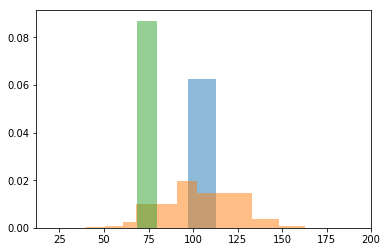

[ 0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0]
0 1 1 97
1 -1 0 113
-1 0 0 131.5
[    0     3     9     5    13   105   109  2334   583  9891 -7591 -2177
 -1338 -1873   -69    -4]
0 3 1 12
3 9 1 17
9 5 1 31
5 13 1 40
13 105 1 45.5
105 109 1 50.5
109 2334 1 60.5
2334 583 0.75 68
583 9891 1 91
9891 -7591 0.25 102.5
-7591 -2177 0.333333333333 133
-2177 -1338 0 148
-1338 -1873 0 163
-1873 -69 0.037037037037 196
-69 -4 0.0588235294118 220
[ 0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0]
0 1 1 57.5
1 -1 0 68.5
-1 0 0 80
[ 0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0]
0 1 1 97
1 -1 0 113
-1 0 0 131.5
[    0     3     9     5    17   115   132  2799   620 10214 -8888 -2445
 -1415 -1130   -35    -1]
0 3 1 12
3 9 1 17
9 5 1 31
5 17 1 40
17 115 1 45.5
115 132 1 50.5
132 2799 1 60.5
2799 620 0.75 68
620 10214 1 91
10214 -8888 0.25 102.5
-8888 -2445 0.333333333333 133
-2445 -1415 0 148
-1415 -1130 0 163
-1130 -35 0.03125 196
-35 -1 0.0285714285714 220
[ 0  0  0  0  1 -1  0  0  0  0  0  0  0  0

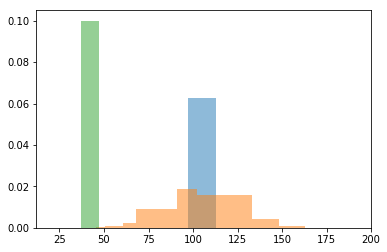

[ 0  0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0]
0 1 1 113
1 -1 0 131.5
-1 0 0 151.5
[    0     1     4    -3    16    75   100  2077   419 10054 -6958 -2076
 -1339 -2252  -114    -4]
0 1 1 12
1 4 1 17
4 -3 0.25 31
-3 16 0 40
16 75 1 45.5
75 100 1 50.5
100 2077 1 60.5
2077 419 0.75 68
419 10054 1 91
10054 -6958 0.25 102.5
-6958 -2076 0.333333333333 133
-2076 -1339 0 148
-1339 -2252 0 163
-2252 -114 0.0526315789474 196
-114 -4 0.0357142857143 220
[ 0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
0 1 1 32
1 -1 0 37
-1 0 0 47
[ 0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0]
0 1 1 97
1 -1 0 113
-1 0 0 131.5
[    0     1     4    -3    16    89   135  2453   499 10541 -8247 -2498
 -1504 -1450   -35    -1]
0 1 1 12
1 4 1 17
4 -3 0.25 31
-3 16 0 40
16 89 1 45.5
89 135 1 50.5
135 2453 1 60.5
2453 499 0.75 68
499 10541 1 91
10541 -8247 0.25 102.5
-8247 -2498 0.333333333333 133
-2498 -1504 0 148
-1504 -1450 0 163
-1450 -35 0.0243902439024 196
-35 -1 0.0285714285714 220
[ 0  1 -1  0  0  0  0  0

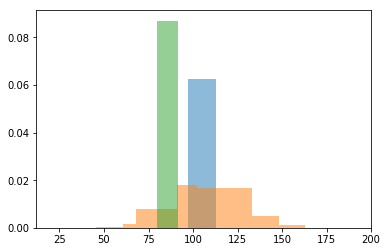

[ 0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0]
0 1 1 97
1 -1 0 113
-1 0 0 131.5
[    0     0     5     4     1    64    77  1715   552  9913 -6136 -2101
 -1370 -2605  -115    -4]
0 5 1 17
5 4 1 31
4 1 0.75 40
1 64 1 45.5
64 77 1 50.5
77 1715 1 60.5
1715 552 0.666666666667 68
552 9913 1 91
9913 -6136 0.25 102.5
-6136 -2101 0.5 133
-2101 -1370 0 148
-1370 -2605 0 163
-2605 -115 0.0454545454545 196
-115 -4 0.0357142857143 220
[ 0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0]
0 1 1 80
1 -1 0 91.5
-1 0 0 104
[ 0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0]
0 1 1 97
1 -1 0 113
-1 0 0 131.5
[    0     0     4     6     1    78    83  2068   685 10582 -7625 -2513
 -1627 -1693   -49     0]
0 4 1 17
4 6 1 31
6 1 0.833333333333 40
1 78 1 45.5
78 83 1 50.5
83 2068 1 60.5
2068 685 0.666666666667 68
685 10582 1 91
10582 -7625 0.25 102.5
-7625 -2513 0.333333333333 133
-2513 -1627 0 148
-1627 -1693 0 163
-1693 -49 0.0294117647059 196
-49 0 0 220
[ 0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0]
0 

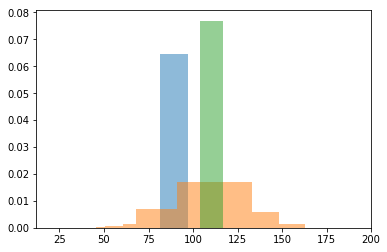

[ 0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0]
0 1 1 81.5
1 -1 0 97
-1 0 0 113
[    0     1     1     1     9    57    47  1469   620  9572 -5427 -1853
 -1312 -3003  -166   -16]
0 1 1 12
1 1 1 17
1 1 1 31
1 9 1 40
9 57 1 45.5
57 47 1 50.5
47 1469 1 60.5
1469 620 0.5 68
620 9572 1 91
9572 -5427 0.25 102.5
-5427 -1853 0.5 133
-1853 -1312 0 148
-1312 -3003 0 163
-3003 -166 0.0555555555556 196
-166 -16 0.1 220
[ 0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0]
0 1 1 104
1 -1 0 117
-1 0 0 131
[ 0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0]
0 1 1 81.5
1 -1 0 97
-1 0 0 113
[    0     1     1     1     9    62    70  1768   775 10389 -6924 -2372
 -1703 -2001   -72    -4]
0 1 1 12
1 1 1 17
1 1 1 31
1 9 1 40
9 62 1 45.5
62 70 1 50.5
70 1768 1 60.5
1768 775 0.5 68
775 10389 1 91
10389 -6924 0.25 102.5
-6924 -2372 0.5 133
-2372 -1703 0 148
-1703 -2001 0 163
-2001 -72 0.037037037037 196
-72 -4 0.0555555555556 220
[ 0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0]
0 1 1 104
1 -1 0 117
-1 0 0 131


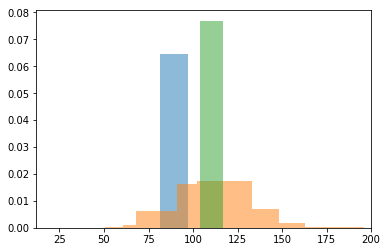

[ 0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0]
0 1 1 81.5
1 -1 0 97
-1 0 0 113
[    0     0     1     5     2    35    58  1225   541  9499 -5013 -1562
  -925 -3606  -248   -12]
0 1 1 17
1 5 1 31
5 2 0.5 40
2 35 1 45.5
35 58 1 50.5
58 1225 1 60.5
1225 541 0.5 68
541 9499 1 91
9499 -5013 0.25 102.5
-5013 -1562 0.333333333333 133
-1562 -925 0 148
-925 -3606 0 163
-3606 -248 0.0714285714286 196
-248 -12 0.05 220
[ 0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0]
0 1 1 117
1 -1 0 131
-1 0 0 145
[ 0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0]
0 1 1 81.5
1 -1 0 97
-1 0 0 113
[    0     0     1     5     2    45    62  1499   727 10373 -6438 -2060
 -1673 -2433  -107    -3]
0 1 1 17
1 5 1 31
5 2 0.5 40
2 45 1 45.5
45 62 1 50.5
62 1499 1 60.5
1499 727 0.5 68
727 10373 1 91
10373 -6438 0.25 102.5
-6438 -2060 0.333333333333 133
-2060 -1673 0 148
-1673 -2433 0 163
-2433 -107 0.0454545454545 196
-107 -3 0.0285714285714 220
[ 0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0]
0 1 1 104
1 -1 0 117
-

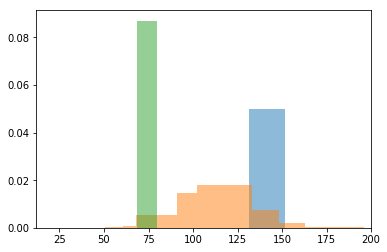

[ 0  0  0  0  0  0  0  0  0  0  0  0  1 -1  0  0]
0 1 1 131.5
1 -1 0 151.5
-1 0 0 173
[    0     0     2     2    -1    27    24  1008   589  8887 -3803 -1488
  -895 -4054  -274   -24]
0 2 1 17
2 2 1 31
2 -1 0.25 40
-1 27 0 45.5
27 24 1 50.5
24 1008 1 60.5
1008 589 1 68
589 8887 1 91
8887 -3803 0.166666666667 102.5
-3803 -1488 0.5 133
-1488 -895 0 148
-895 -4054 0 163
-4054 -274 0.0714285714286 196
-274 -24 0.0909090909091 220
[ 0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0]
0 1 1 68.5
1 -1 0 80
-1 0 0 91.5
[ 0  0  0  0  0  0  0  0  0  0  0  0  1 -1  0  0]
0 1 1 131.5
1 -1 0 151.5
-1 0 0 173
[    0     0     2     2     0    29    45  1200   813 10023 -5431 -2097
 -1591 -2866  -126    -3]
0 2 1 17
2 2 1 31
2 0 1 40
0 29 1 45.5
29 45 1 50.5
45 1200 1 60.5
1200 813 1 68
813 10023 1 91
10023 -5431 0.25 102.5
-5431 -2097 0.5 133
-2097 -1591 0 148
-1591 -2866 0 163
-2866 -126 0.0454545454545 196
-126 -3 0.0238095238095 220
[ 0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0]
0 1 1 68.5
1 -1 0

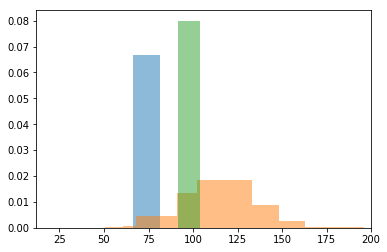

[ 0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0]
0 1 1 66.5
1 -1 0 81.5
-1 0 0 97
[    0     0     1     4    -2    21    26   810   573  8275 -2894 -1118
  -746 -4516  -412   -22]
0 1 1 17
1 4 1 31
4 -2 0.25 40
-2 21 0 45.5
21 26 1 50.5
26 810 1 60.5
810 573 1 68
573 8275 1 91
8275 -2894 0.166666666667 102.5
-2894 -1118 0.5 133
-1118 -746 0 148
-746 -4516 0 163
-4516 -412 0.1 196
-412 -22 0.0555555555556 220
[ 0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0]
0 1 1 104
1 -1 0 117
-1 0 0 131
[ 0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0]
0 1 1 66.5
1 -1 0 81.5
-1 0 0 97
[    0     0     1     4    -1    23    27  1059   631  9599 -4378 -1915
 -1546 -3321  -176    -7]
0 1 1 17
1 4 1 31
4 -1 0.125 40
-1 23 0 45.5
23 27 1 50.5
27 1059 1 60.5
1059 631 1 68
631 9599 1 91
9599 -4378 0.166666666667 102.5
-4378 -1915 0.5 133
-1915 -1546 0 148
-1546 -3321 0 163
-3321 -176 0.0555555555556 196
-176 -7 0.04 220
[ 0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0]
0 1 1 91.5
1 -1 0 104
-1 0 0 117
[ 

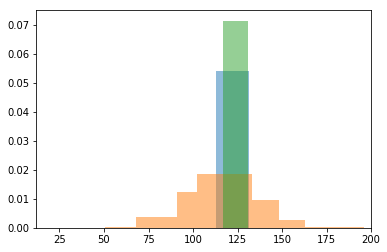

[ 0  0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0]
0 1 1 113
1 -1 0 131.5
-1 0 0 151.5
[    0     0     0     1     0    16    20   628   548  7992 -2454  -796
  -330 -5140  -440   -45]
0 1 1 31
1 0 1 40
0 16 1 45.5
16 20 1 50.5
20 628 1 60.5
628 548 1 68
548 7992 1 91
7992 -2454 0.125 102.5
-2454 -796 0.333333333333 133
-796 -330 0.5 148
-330 -5140 0 163
-5140 -440 0.0909090909091 196
-440 -45 0.111111111111 220
[ 0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0]
0 1 1 131
1 -1 0 145
-1 0 0 163.5
[ 0  0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0]
0 1 1 113
1 -1 0 131.5
-1 0 0 151.5
[    0     0     0     1     0    20    17   815   663  9340 -3829 -1557
 -1499 -3732  -232    -7]
0 1 1 31
1 0 1 40
0 20 1 45.5
20 17 1 50.5
17 815 1 60.5
815 663 1 68
663 9340 1 91
9340 -3829 0.166666666667 102.5
-3829 -1557 0.5 133
-1557 -1499 0 148
-1499 -3732 0 163
-3732 -232 0.0625 196
-232 -7 0.030303030303 220
[ 0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0]
0 1 1 131
1 -1 0 145
-1 0 0 163.5
[ 0  0  0 

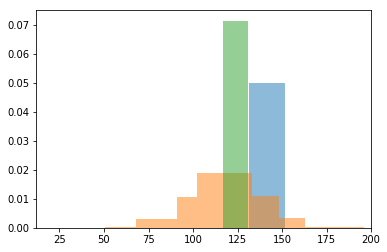

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  1 -1  0]
0 1 1 151.5
1 -1 0 173
-1 0 0 200.5
[    0     0     1     0     1    16     5   554   461  7114 -1385  -434
    28 -5701  -594   -65]
0 1 1 17
1 0 1 31
0 1 1 40
1 16 1 45.5
16 5 0.666666666667 50.5
5 554 1 60.5
554 461 1 68
461 7114 1 91
7114 -1385 0.0833333333333 102.5
-1385 -434 0.333333333333 133
-434 28 0.0625 148
28 -5701 0 163
-5701 -594 0.111111111111 196
-594 -65 0.111111111111 220
[ 0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0]
0 1 1 131
1 -1 0 145
-1 0 0 163.5
[ 0  0  0  0  0  0  0  0  0  0  0  0  1 -1  0  0]
0 1 1 131.5
1 -1 0 151.5
-1 0 0 173
[    0     0     1     0     1    16    14   692   562  8552 -2594 -1408
 -1162 -4350  -304   -20]
0 1 1 17
1 0 1 31
0 1 1 40
1 16 1 45.5
16 14 1 50.5
14 692 1 60.5
692 562 1 68
562 8552 1 91
8552 -2594 0.125 102.5
-2594 -1408 0 133
-1408 -1162 0 148
-1162 -4350 0 163
-4350 -304 0.0714285714286 196
-304 -20 0.0666666666667 220
[ 0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0]
0 1 1 1

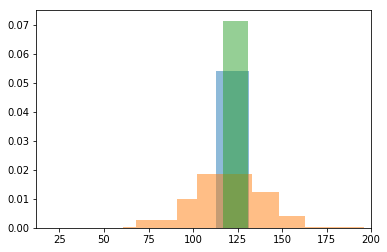

[ 0  0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0]
0 1 1 113
1 -1 0 131.5
-1 0 0 151.5
[    0     0     0     1    -1     7    14   460   302  6858 -1131   -35
   763 -6475  -683   -80]
0 1 1 31
1 -1 0 40
-1 7 0 45.5
7 14 1 50.5
14 460 1 60.5
460 302 1 68
302 6858 1 91
6858 -1131 0.0714285714286 102.5
-1131 -35 0.03125 133
-35 763 0 148
763 -6475 0 163
-6475 -683 0.111111111111 196
-683 -80 0.125 220
[ 0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0]
0 1 1 117
1 -1 0 131
-1 0 0 145
[ 0  0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0]
0 1 1 113
1 -1 0 131.5
-1 0 0 151.5
[    0     0     0     1    -1     7    19   561   448  8207 -2071  -995
  -803 -5013  -338   -22]
0 1 1 31
1 -1 0 40
-1 7 0 45.5
7 19 1 50.5
19 561 1 60.5
561 448 1 68
448 8207 1 91
8207 -2071 0.125 102.5
-2071 -995 0.5 133
-995 -803 0 148
-803 -5013 0 163
-5013 -338 0.0714285714286 196
-338 -22 0.0666666666667 220
[ 0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0]
0 1 1 117
1 -1 0 131
-1 0 0 145
[ 0  0  0  0  0  0  0  0  0  

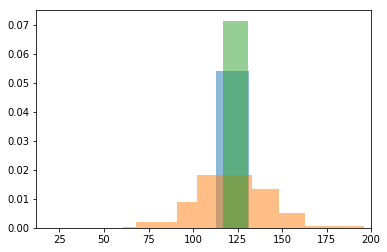

[ 0  0  0  0  0  0  0  0  0  0  0  0  1 -1  0  0]
0 1 1 131.5
1 -1 0 151.5
-1 0 0 173
[    0     0     0     0     0     9     4   315   328  6313  -528    53
  1499 -6984  -921   -88]
0 9 1 45.5
9 4 0.5 50.5
4 315 1 60.5
315 328 1 68
328 6313 1 91
6313 -528 0.0416666666667 102.5
-528 53 0.1 133
53 1499 1 148
1499 -6984 0 163
-6984 -921 0.142857142857 196
-921 -88 0.1 220
[ 0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0]
0 1 1 131
1 -1 0 145
-1 0 0 163.5
[ 0  0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0]
0 1 1 113
1 -1 0 131.5
-1 0 0 151.5
[    0     0     0     0     0     9     9   416   463  7653 -1505  -592
  -357 -5624  -446   -26]
0 9 1 45.5
9 9 1 50.5
9 416 1 60.5
416 463 1 68
463 7653 1 91
7653 -1505 0.0833333333333 102.5
-1505 -592 0.5 133
-592 -357 0 148
-357 -5624 0 163
-5624 -446 0.0833333333333 196
-446 -26 0.0588235294118 220
[ 0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0]
0 1 1 117
1 -1 0 131
-1 0 0 145
[ 0  0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0]
0 1 1 113
1 -1 0 

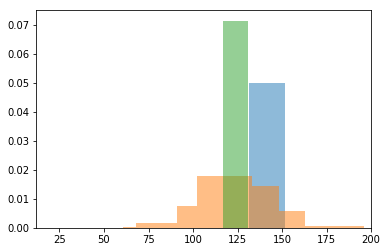

[ 0  0  0  0  0  0  0  0  0  0  0  0  1 -1  0  0]
0 1 1 131.5
1 -1 0 151.5
-1 0 0 173
[    0     0     0     0     1     2     8   276   261  5473   171   594
  2007 -7575 -1080  -136]
0 1 1 40
1 2 1 45.5
2 8 1 50.5
8 276 1 60.5
276 261 1 68
261 5473 1 91
5473 171 0.96875 102.5
171 594 1 133
594 2007 1 148
2007 -7575 0 163
-7575 -1080 0.142857142857 196
-1080 -136 0.142857142857 220
[ 0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0]
0 1 1 117
1 -1 0 131
-1 0 0 145
[ 0  0  0  0  0  0  0  0  0  0  0  0  1 -1  0  0]
0 1 1 131.5
1 -1 0 151.5
-1 0 0 173
[    0     0     0     0     2     1    12   345   395  6827  -713   -41
    54 -6233  -594   -55]
0 2 1 40
2 1 0.5 45.5
1 12 1 50.5
12 345 1 60.5
345 395 1 68
395 6827 1 91
6827 -713 0.05 102.5
-713 -41 0.0588235294118 133
-41 54 0 148
54 -6233 0 163
-6233 -594 0.1 196
-594 -55 0.1 220
[ 0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0]
0 1 1 117
1 -1 0 131
-1 0 0 145
[ 0  0  0  0  0  0  0  0  0  0  0  0  1 -1  0  0]
0 1 1 131.5
1 -1 0 151.5
-

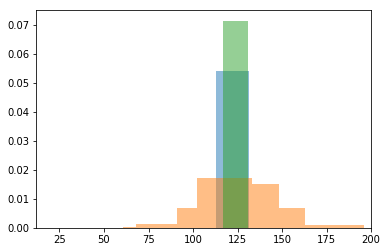

[ 0  0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0]
0 1 1 113
1 -1 0 131.5
-1 0 0 151.5
[    0     0     0     0     0     2     6   220   243  5065   334   966
  2514 -7814 -1375  -159]
0 2 1 45.5
2 6 1 50.5
6 220 1 60.5
220 243 1 68
243 5065 1 91
5065 334 0.933333333333 102.5
334 966 1 133
966 2514 1 148
2514 -7814 0 163
-7814 -1375 0.2 196
-1375 -159 0.125 220
[ 0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0]
0 1 1 131
1 -1 0 145
-1 0 0 163.5
[ 0  0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0]
0 1 1 113
1 -1 0 131.5
-1 0 0 151.5
[    0     0     0     0     0     2     7   287   324  6404  -254    40
   803 -6811  -748   -54]
0 2 1 45.5
2 7 1 50.5
7 287 1 60.5
287 324 1 68
324 6404 1 91
6404 -254 0.0192307692308 102.5
-254 40 0.142857142857 133
40 803 1 148
803 -6811 0 163
-6811 -748 0.111111111111 196
-748 -54 0.0769230769231 220
[ 0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0]
0 1 1 117
1 -1 0 131
-1 0 0 145
[ 0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0]
0 1 1 97
1 -1 0 113
-1 0 0

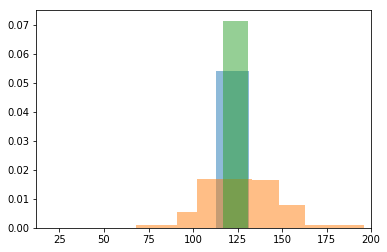

[ 0  0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0]
0 1 1 113
1 -1 0 131.5
-1 0 0 151.5
[    0     0     0     0     1     1     9   145   195  4382   857  1201
  3479 -8430 -1588  -249]
0 1 1 40
1 1 1 45.5
1 9 1 50.5
9 145 1 60.5
145 195 1 68
195 4382 1 91
4382 857 0.8 102.5
857 1201 1 133
1201 3479 1 148
3479 -8430 0 163
-8430 -1588 0.2 196
-1588 -249 0.166666666667 220
[ 0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0]
0 1 1 131
1 -1 0 145
-1 0 0 163.5
[ 0  0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0]
0 1 1 113
1 -1 0 131.5
-1 0 0 151.5
[    0     0     0     0     1     3     7   197   269  5683   283   635
  1471 -7579  -871   -99]
0 1 1 40
1 3 1 45.5
3 7 1 50.5
7 197 1 60.5
197 269 1 68
269 5683 1 91
5683 283 0.95 102.5
283 635 1 133
635 1471 1 148
1471 -7579 0 163
-7579 -871 0.125 196
-871 -99 0.125 220
[ 0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0]
0 1 1 131
1 -1 0 145
-1 0 0 163.5
[ 0  0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0]
0 1 1 113
1 -1 0 131.5
-1 0 0 151.5
[    0     

In [60]:
sigma_range = [20, 40] # np.arange(5, 100, 5)
sigma_dict = {}
idx = 130
for sigma in sigma_range:
    true_dose_list, reco_dose_list, old_reco_dose_list = [], [], []
    mean_energy_list, sigma_energy_list = [], []
    mean_energy_reco_list = []
    mean_temp_list, sigma_temp_list = [], []

    energy_range = np.linspace(10, 400, 100)
    for energy in energy_range:
        # Random data in ToT
        ToTvac = list(np.random.normal(energy, sigma, 1)) #50000)) # + list(np.random.normal(300, 2, 1))
        # ToTal = np.random.uniform(150, 250, 1) 
        ToTal = list(np.random.normal(energy, sigma, 30000)) # + list(np.random.uniform(0, 800, 10000))
        ToTsn = np.random.normal(energy, sigma, 1) # 5000)

        data_vac = getDataAtTSingle(ToTvac, Toffset, slope[idx], offset[idx], Toffset, paramsDict[idx], energy=True)
        data_al = getDataAtTSingle(ToTal, Toffset, slope[idx], offset[idx], Toffset, paramsDict[idx], energy=True)
        data_sn = getDataAtTSingle(ToTsn, Toffset, slope[idx], offset[idx], Toffset, paramsDict[idx], energy=True)
        mean_energy_list.append( np.mean(data_al) )
        sigma_energy_list.append( np.std(data_al) )

        # plt.hist(data_vac, bins=50, density=True, alpha=.5)
        plt.hist(data_vac, bins=binEdgesTh['vac'], density=True, alpha=.5)
        plt.hist(data_al, bins=binEdgesTh['al'], density=True, alpha=.5)
        plt.hist(data_sn, bins=binEdgesTh['sn'], density=True, alpha=.5)
        plt.xlim(12, 200)

        hist_vac, bins = np.histogram(data_vac, bins=binEdgesTh['vac'])
        hist_al, bins = np.histogram(data_al, bins=binEdgesTh['al'])
        hist_sn, bins = np.histogram(data_sn, bins=binEdgesTh['sn'])
        mean_energy_reco_list.append( histMean(binEdgesTh['al'], hist_al) )

        hist = np.hstack((hist_vac, hist_al, hist_sn))
        dose = np.dot(hist, alphaPoly)
        print dose
        plt.show()

        true_dose_list.append( dose )
        reco, old_reco, mean_temp, sigma_temp = temperatureShiftSim(ToTvac, ToTal, ToTsn, dose, debug=False)
        old_reco_dose_list.append( old_reco )
        reco_dose_list.append( reco )
        mean_temp_list.append( mean_temp )
        sigma_temp_list.append( sigma_temp )

    sigma_dict[sigma] = {}
    sigma_dict[sigma]['true_dose'], sigma_dict[sigma]['reco_dose'] = true_dose_list, reco_dose_list
    sigma_dict[sigma]['mean_energy'], sigma_dict[sigma]['mean_energy_reco'] = mean_energy_list, mean_energy_reco_list
    sigma_dict[sigma]['sigma_energy'] = sigma_energy_list
    sigma_dict[sigma]['sigma_temp'] = sigma_temp_list
    sigma_dict[sigma]['old_reco_dose'] = old_reco_dose_list
    sigma_dict[sigma]['mean_temp'] = mean_temp_list

In [61]:
sigma_dict_calib = sigma_dict

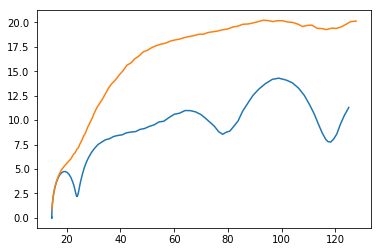

(200,) (200,) (200,) (2200,)


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: The griddata function was deprecated in version 2.2.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: The griddata function was deprecated in version 2.2.


ValueError: x, y and z must be equal-length 1-D arrays

In [62]:
import matplotlib.mlab as mlab
import scipy.spatial

# Create xyz data
xInt, yInt, zInt, dInt = [], [], [], []
for sigma in sorted(sigma_dict_calib.keys()):
    mean_energy_reco = np.asarray(sigma_dict_calib[sigma]['mean_energy_reco']).T
    mean_energy = sigma_dict_calib[sigma]['mean_energy']
    mean_temp = sigma_dict_calib[sigma]['mean_temp']
    sigma_temp = np.asarray(sigma_dict_calib[sigma]['sigma_temp']).flatten()
    sigma_temp[sigma_temp < 0] = 0
    sigma_energy = np.asarray(sigma_dict_calib[sigma]['sigma_energy'])
    mean, sig = mean_energy_reco
    dose = 1. / np.asarray(sigma_dict_calib[sigma]['reco_dose']).flatten()
    # xInt += list(np.asarray(mean_temp).flatten()) 
    xInt += list(mean)
    # yInt += list(sigma_temp) 
    yInt += list(sig)
    dInt += list(dose) # 
    zInt += list(sigma_energy)
    # zInt += [sigma] * len(sig)
    plt.plot(mean, sig)
plt.show()

xInt, yInt, zInt, dInt = np.asarray(xInt), np.asarray(yInt), np.asarray(zInt), np.asarray(dInt)
print xInt.shape, yInt.shape, zInt.shape, dInt.shape

# Regular grid
xi = np.linspace(min(xInt), max(xInt), 100)
yi = np.linspace(min(yInt), max(yInt), 100)
zi = np.linspace(min(zInt), max(zInt), 100)
# tree = scipy.spatial.KDTree()

z_res = mlab.griddata(xInt, yInt, zInt, xi, yi, interp='linear')
# zi = scipy.interpolate.griddata((x, y), z, (xi, yi), method='linear')
di = mlab.griddata(xInt, zInt, dInt, xi, zi, interp='linear')
get_sigma = (lambda mean, sigma: mlab.griddata(xInt, yInt, zInt, mean, sigma, interp='linear'))
get_correction = (lambda mean, sigma: mlab.griddata(xInt, zInt, dInt, mean, sigma, interp='linear'))
print get_sigma(20, 5)

get_corr = (lambda mean, sigma: mlab.griddata(xInt, yInt, dInt, mean, sigma, interp='linear'))
di_ = mlab.griddata(xInt, yInt, dInt, xi, yi, interp='linear')
plt.pcolormesh(xi, yi, di_)
plt.xlabel('Mean $\mu$')
plt.ylabel('Meas. sigma $\sigma_T$')
plt.title('True sigma $\sigma$')
plt.colorbar()
plt.show()

plt.pcolormesh(xi, yi, z_res)
plt.xlabel('Mean $\mu$')
plt.ylabel('Meas. sigma $\sigma_T$')
plt.title('True sigma $\sigma$')
plt.colorbar()
plt.show()

plt.pcolormesh(xi, zi, di)
plt.title('Correction factor')
plt.xlabel('Mean $\mu$')
plt.ylabel('Sigma $\sigma$')
plt.colorbar()
# plt.axis([xmin, xmax, ymin, ymax])
plt.show()

In [63]:
x_, y_, z_ = [], [], []
for i, T in enumerate(TRange):
    x_ += list( np.asarray(mean_energy_list) )
    z_ += list( np.asarray(mean_energy_list) / np.asarray(mean_temp_list)[:,i] )
    y_ += list( [T] * len(mean_energy_list) )
    
xi_ = np.linspace(min(x_), max(x_), 100)
yi_ = np.linspace(min(y_), max(y_), 100)
zi_ = mlab.griddata(x_, y_, z_, xi_, yi_, interp='linear')
    
get_mean = (lambda mean, temp: mlab.griddata(x_, y_, z_, mean, temp, interp='linear'))
plt.pcolormesh(xi_, yi_, zi_)

IndexError: index 0 is out of bounds for axis 1 with size 0

In [320]:
m, s = 49, 20
s = get_sigma(m, s)
print get_mean(20, -50)
print s
print get_corr(m, s)

--
19.2277254296565
10.958203452374345


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: The griddata function was deprecated in version 2.2.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: The griddata function was deprecated in version 2.2.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: The griddata function was deprecated in version 2.2.


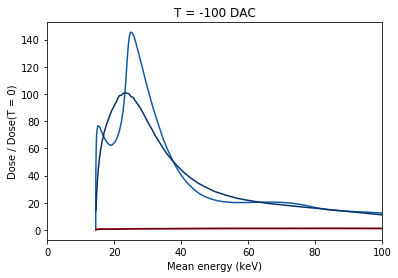

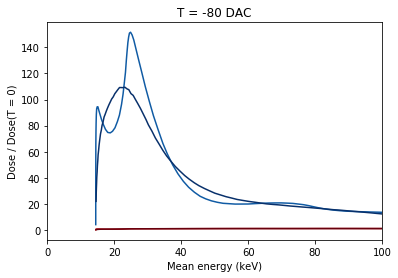

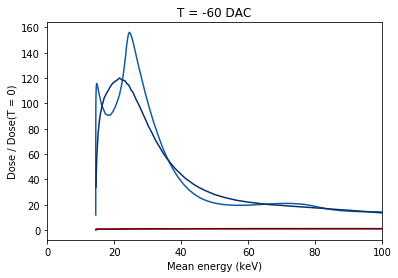

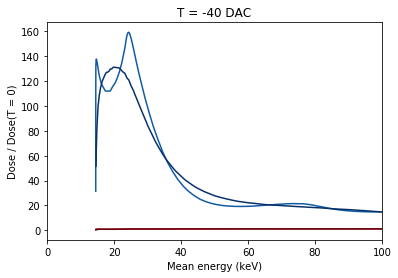

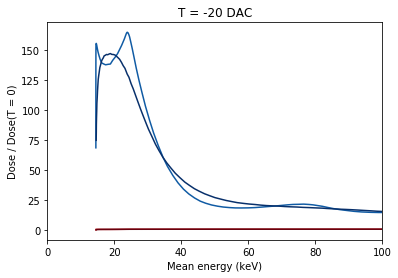

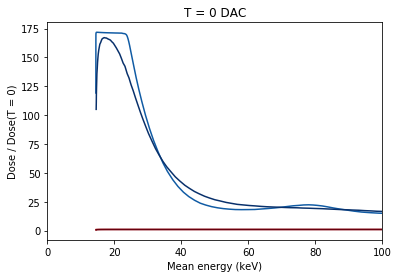

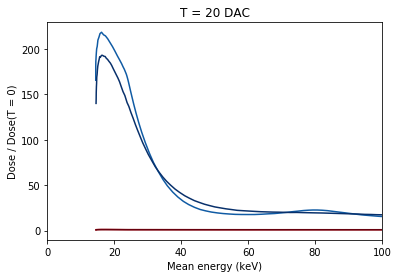

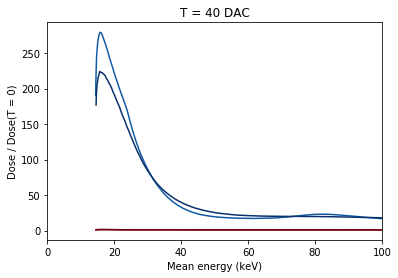

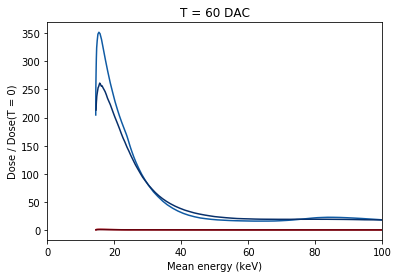

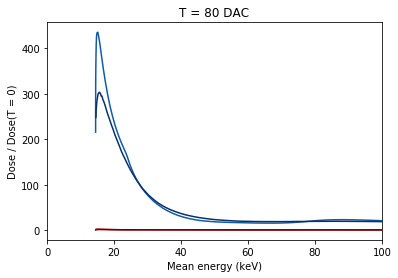

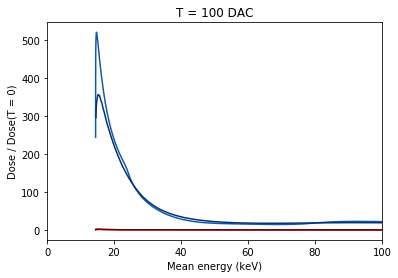

[ 14.5   24.    35.5   42.75  48.    55.5   64.25  79.5   96.75 117.75
 140.5  155.5  179.5  208.   238.5  343.5 ] [  5.   14.    9.    5.5   5.   10.    7.5  23.   11.5  30.5  15.   15.
  33.   24.   37.  173. ]


In [65]:
import scipy.signal
# plt.plot(true_dose_list)

def getColor(c, N, idx):
    import matplotlib as mpl
    cmap = mpl.cm.get_cmap(c)
    norm = mpl.colors.Normalize(vmin=0.0, vmax=N - 1)
    return cmap(norm(idx))

TRange = np.arange(-100, 120, 20)
for T in range(len(TRange)):
    for idx, sigma in enumerate(sorted(sigma_dict.keys())):
        true_dose_list, reco_dose_list = sigma_dict[sigma]['true_dose'], sigma_dict[sigma]['reco_dose']
        mean_energy_list, mean_energy_reco_list = sigma_dict[sigma]['mean_energy'], sigma_dict[sigma]['mean_energy_reco']
        old_reco_dose_list = sigma_dict[sigma]['old_reco_dose']
        mean_temp_list = sigma_dict[sigma]['mean_temp']
    
        # plt.plot(np.asarray(mean_energy_reco_list).T[0], 1. / np.mean(reco_dose_list, axis=1), color=getColor('Blues', len(sigma_dict.keys()) + 5, idx + 5))
        # plt.plot(np.asarray(mean_energy_reco_list).T[0], np.asarray(true_dose_list), color='k')
        plt.plot(np.asarray(mean_energy_reco_list).T[0], np.asarray(reco_dose_list)[:,T], color=getColor('Blues', len(sigma_dict.keys()) + 5, idx + 5))
        plt.plot(np.asarray(mean_energy_reco_list).T[0], np.asarray(old_reco_dose_list)[:,T], color=getColor('Reds', len(sigma_dict.keys()) + 5, idx + 5))

        # plt.plot(np.asarray(mean_energy_list), np.asarray(mean_temp_list)[:,T] / np.asarray(mean_energy_list), color=getColor('Blues', len(TRange) + 5, T + 5))
        
        plt.title('T = %d DAC' % TRange[T])
        plt.xlabel('Mean energy (keV)')
        plt.ylabel('Dose / Dose(T = 0)')
        plt.xlim(0, 100)
        # plt.ylim(0, 0.2)
        
        # plt.plot(np.asarray(mean_energy_reco_list).T[0], np.asarray(mean_energy_reco_list).T[1])
    # plt.savefig('binWidthDivision.svg')
    plt.show()
   
xEdge = binEdgesTh['al'][:-1] + 0.5*np.diff(binEdgesTh['al'])
yEdge = np.diff(binEdgesTh['al'])
print xEdge, yEdge

x = np.linspace(xEdge[0], xEdge[-1], 1000)
# yEdge_interp = scipy.interpolate.interp1d(xEdge, yEdge, kind='linear')
# yEdge_filt = scipy.signal.savgol_filter(yEdge_interp(x), 149, 3)

#yEdge_interp = scipy.interpolate.interp1d(xEdge, yEdge, kind='cubic')
#plt.plot(x, 0.3*yEdge_interp(x) + 0.13*x, ls='--', color='k')
#plt.plot(x, 0.8*yEdge_interp(x) + 0.05*x, ls='--', color='k')
#plt.plot(x, 0.05*yEdge_interp(x) + 0.17*x, ls='--')
# plt.plot(xEdge, yEdge, ls='--', color='k')
# plt.plot(x, 1.1*yEdge_filt, ls='--', color='k')

# plt.xlim(12, 200)
# plt.ylim(0, 50)
# plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in divide
  """Entry point for launching an IPython kernel.


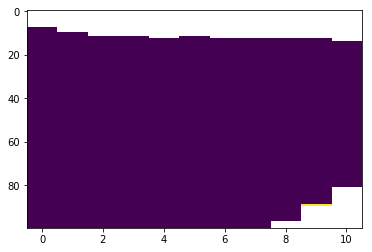

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in divide
  This is separate from the ipykernel package so we can avoid doing imports until


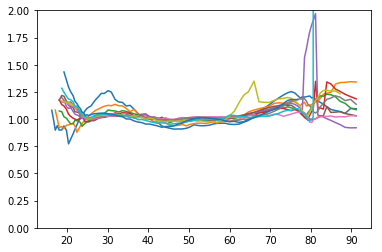

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in divide
  


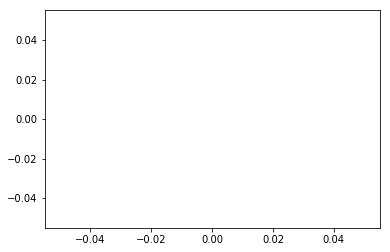

In [244]:
plt.imshow(1./np.asarray(reco_dose_list), aspect='auto')
plt.show()
plt.plot(np.asarray(mean_energy_reco_list).T[0], 1./np.asarray(reco_dose_list))
plt.ylim(0, 2)
plt.show()
plt.plot(np.mean(1./np.asarray(reco_dose_list), axis=0))

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in divide
  


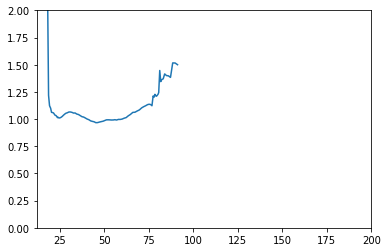

In [245]:
# fix_dose = 1. / np.asarray(reco_dose_list).T[5]
fix_dose = 1. / np.mean(reco_dose_list, axis=1)
plt.xlim(12, 200)
plt.ylim(0, 2)
yEdge_interp3 = scipy.interpolate.interp1d(np.sort(np.asarray(mean_energy_reco_list).T[0]), fix_dose, kind='cubic')
plt.plot(np.asarray(mean_energy_reco_list).T[0], fix_dose)
plt.plot(np.asarray(mean_energy_reco_list).T[0], yEdge_interp3(np.asarray(mean_energy_reco_list).T[0]))

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in divide
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python2.7/dist-packages/numpy/lib/polynomial.py:583: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan]


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  


ValueError: A value in x_new is above the interpolation range.

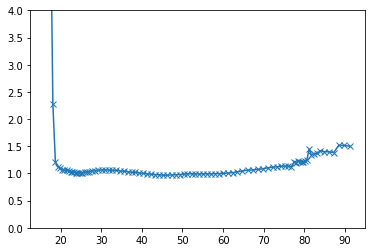

In [246]:
reco_dose_all = np.asarray(np.hstack([sigma_dict[sigma]['reco_dose'] for sigma in sigma_dict.keys()]))
fix_dose = 1. / np.mean(reco_dose_all, axis=1)
plt.plot(np.asarray(mean_energy_reco_list).T[0], 1. / np.mean(reco_dose_all, axis=1), marker='x')
xFit = np.asarray(mean_energy_reco_list).T[0]
fix_dose = fix_dose[xFit < 240]
xFit = xFit[xFit < 240]

p = np.polyfit(xFit, fix_dose, 100)
print p
f_interp = scipy.interpolate.interp1d(xFit, fix_dose, kind='quadratic')

x = np.linspace(20, 200, 1000)
plt.ylim(0, 4)
plt.plot(x, np.poly1d(p)(x))
plt.plot(x, f_interp(x))
plt.show()

plt.plot(xFit, 1 - fix_dose / np.poly1d(p)(xFit), marker='x')

In [172]:
f_interp_bu = f_interp